In [4]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from pyvis.network import Network
import community.community_louvain as community_louvain
from tqdm import tqdm
import time

---

In [3]:
# TODO : 
# Faire fonction de vérification des paires id: community pour le dataframe
# Revoir la méthode de sauvegarde des graphes (qui des anciens graphs)
# 

## Importation des données

In [92]:
project = pd.read_csv("../Data/CSV/Projects/project.csv", sep=";")

In [3]:
organization = pd.read_csv("../Data/CSV/Projects/organization.csv", sep=";")

On importera les pubications après

In [4]:
print(project.shape)
print(organization.shape)

(35381, 20)
(177190, 25)


In [93]:
project.isna().sum()

id                        0
acronym                   0
status                    0
title                     0
startDate                11
endDate                  11
totalCost                 0
ecMaxContribution         0
legalBasis                4
topics                    0
ecSignatureDate           4
frameworkProgramme        0
masterCall                4
subCall                   0
fundingScheme             0
nature                34786
objective                 0
contentUpdateDate         0
rcn                       0
grantDoi                  0
dtype: int64

---

## Création du graph

On récupère les ID unique des projets

In [5]:
project_id = list(project["id"].unique())

Pour chaque projet je récupère les id des organisations qui y participent. Tout ça dans un dictionnaire.

In [6]:
projet_orga = {}
for projet in project_id:
    projet_orga[projet] = list(organization[organization["projectID"] == projet]["organisationID"])

Création d'un graph vide

In [7]:
G = nx.Graph()

Fonction de création du graph (prendre plus d'une heure à faire tourner)

In [9]:
########### /!\ TOURNE INDEFINIEMENT /!\ ##############

yes_counter = 0
for i, tq in zip(range(1, len(projet_orga.keys())), tqdm(range(len(projet_orga.keys())))):
#     print(projet_orga[project_id[i]])
    for t in range(len(projet_orga.keys())):
#         G.add_node(project_id[i - 1])
        G.add_node(project_id[i - 1], label=project_id[i - 1])
        for y in projet_orga[project_id[i - 1]]:
#         print(f"i: {i} | i+1: {projet_orga[project_id[i+1]]} | y: {y}")
            if G.has_edge(project_id[i - 1], project_id[t]) is False:
                for x in projet_orga[project_id[t]]:
            
                    if y == x:
                        yes_counter += 1
                        G.add_edge(project_id[i-1], project_id[t])

G.remove_edges_from(nx.selfloop_edges(G))
# On supprime les boucles du graph car cela n'apporte pas d'information et cela prend de la place

  0%|                                                                              | 8/35381 [00:02<3:31:10,  2.79it/s]


KeyboardInterrupt: 

Pour importer un graph sauvegardé au format .pickle

In [8]:
G = pickle.load(open("../graphs_save/graphe_3_labeled.pickle", "rb"))

In [9]:
G.number_of_nodes()

35381

In [10]:
G.number_of_edges()

9982209

---

## Détection de communauté

### Détection de communauté

In [11]:
start = time.time()

partition = community_louvain.best_partition(G, random_state=42)

print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Execution time: 00:10:30


In [12]:
print(f"Nombre de communautés : {len(set(partition.values()))}")

Nombre de communautés : 4380


On ajoute les communauté en tant qu'attributs aux noeuds du graph

In [13]:
nx.set_node_attributes(G, partition, 'partition')

On ajoute les communautés au DataFrame de données

In [14]:
def dict_to_df(dict_: dict, df: DataFrame, name: str, dtype: str = "int32", join_on: str = "id") -> DataFrame:

    dict_df = pd.DataFrame.from_dict(dict_, orient="index").astype({0:dtype})
    df = df.join(dict_df, on=join_on)
    df.rename({0:name}, axis=1, inplace=True)
    
    return df

In [15]:
project = dict_to_df(partition, project, "Community")

In [16]:
project.head(2)

id    acronym  status  \
0  817296  eDCaseMAN  CLOSED   
1  764717    WinWind  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   

   totalCost ecMaxContribution     legalBasis                 topics  ...  \
0      71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1  2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   

  frameworkProgramme                   masterCall                    subCall  \
0              H2020  H2020-EIC-SMEInst-2018-2020  H2020-SMEInst-2018-2020-1   
1              H2020          H2020-LCE-2016-2017     H2020-LCE-2017-RES-CSA   

  fundingScheme nature                                          objective  \
0         SME-1    NaN  "Electronic discovery (known as e-discovery) i...   
1           CSA    NaN  The overall objective of WinWind is to enhance...   

     contentUpdateDate     rcn        grantDoi Community  
0  2022-08-10 13:07:21  217713  10.3030/817296         0  
1  2022-08-17 10:54:17  211548  10.3030/764717         1  

[2 rows x 21 columns]

### Modification et analyse des communautés

On calcule la proportion du chaque communauté par rapport à tous le data set 

In [17]:
proportions = project['Community'].value_counts(normalize=True).to_frame()
proportions.rename({"Community": "Proportion"}, inplace=True, axis=1)

In [18]:
proportions

Proportion
1       0.222916
13      0.139453
4       0.100082
12      0.068624
9       0.054266
...          ...
1641    0.000028
1642    0.000028
1643    0.000028
1644    0.000028
3       0.000028

[4380 rows x 1 columns]

On recupère l'index (ici les communautés) pour lesquelles la proportion est inférieure à 1% du data set 

In [19]:
index_label = proportions[proportions["Proportion"] <= 0.01].index.to_list()

On modifie la valeur des communautés pour lesquelles la proportion est inférieure à 1%

In [20]:
def community_filter(x: int):
    if x in index_label:
        return -99
    else:
        return x

In [21]:
project["New_Community"] = project["Community"].apply(community_filter)

In [22]:
project.head(3)

id     acronym  status  \
0  817296   eDCaseMAN  CLOSED   
1  764717     WinWind  CLOSED   
2  784994  PentaHelix  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   
2  Multi stakeholder and governance approach for ...  2018-03-01  2021-09-30   

    totalCost ecMaxContribution     legalBasis                 topics  ...  \
0       71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1   2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   
2  1808343,75        1808343,75  H2020-EU.3.3.        EE-09-2016-2017  ...   

                    masterCall                    subCall fundingScheme  \
0  H2020-EIC-SMEInst-2018-2020  H2020-SMEInst-2018-2020-1         SME-1   
1          H2020-LCE-2016-2017     H2020-LCE-2017-RES-CSA           CSA   
2           H2020-EE-2016-2017      H2020-EE-2017-CSA-PPI           CSA   

  nature                                          objective  \
0    NaN  "Electronic discovery (known as e-discovery) i...   
1    NaN  The overall objective of WinWind is to enhance...   
2    NaN  The PentaHelix project is focusing on developi...   

     contentUpdateDate     rcn        grantDoi  Community New_Community  
0  2022-08-10 13:07:21  217713  10.3030/817296          0           -99  
1  2022-08-17 10:54:17  211548  10.3030/764717          1             1  
2  2022-04-11 16:42:12  213566  10.3030/784994          1             1  

[3 rows x 22 columns]

In [23]:
project.shape

(35381, 22)

On crée un dictionnaire avec l'ID des projets et leurs nouvelles communautés pour être ajouté aux attributs des noeuds du graph

In [24]:
new_community = project.set_index('id')["New_Community"].to_dict()

In [25]:
set(new_community.values())

{-99, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17}

In [26]:
print(f"Nombre de communautés après traitement : {len(set(new_community.values()))}")

Nombre de communautés après traitement : 15


On ajoute ces nouvelles communautés au graph ! 

In [27]:
# nx.set_node_attributes(G, new_community, 'new_partition')

On enregistre ce nouveau graph

In [49]:
# pickle.dump(G, open('../graphs_save/graph_3_labeled_new_partition.pickle', 'wb'))

In [50]:
# nx.write_gexf(G, "../graphs_save/graph_3_labeled_new_partition.gexf")

On va changer les noms des communautés :

In [28]:
old_names = set(new_community.values())

changing_names = {}
for name in enumerate(old_names):
    changing_names[name[1]] = name[0]

In [29]:
changing_names

{1: 0,
 4: 1,
 5: 2,
 6: 3,
 7: 4,
 8: 5,
 9: 6,
 10: 7,
 11: 8,
 12: 9,
 13: 10,
 14: 11,
 15: 12,
 17: 13,
 -99: 14}

In [30]:
def change_name(x: int):
    return changing_names[x]

In [31]:
project["New_Community_Name"] = project["New_Community"].apply(change_name)

In [32]:
project.head(3)

id     acronym  status  \
0  817296   eDCaseMAN  CLOSED   
1  764717     WinWind  CLOSED   
2  784994  PentaHelix  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   
2  Multi stakeholder and governance approach for ...  2018-03-01  2021-09-30   

    totalCost ecMaxContribution     legalBasis                 topics  ...  \
0       71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1   2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   
2  1808343,75        1808343,75  H2020-EU.3.3.        EE-09-2016-2017  ...   

                     subCall fundingScheme nature  \
0  H2020-SMEInst-2018-2020-1         SME-1    NaN   
1     H2020-LCE-2017-RES-CSA           CSA    NaN   
2      H2020-EE-2017-CSA-PPI           CSA    NaN   

                                           objective    contentUpdateDate  \
0  "Electronic discovery (known as e-discovery) i...  2022-08-10 13:07:21   
1  The overall objective of WinWind is to enhance...  2022-08-17 10:54:17   
2  The PentaHelix project is focusing on developi...  2022-04-11 16:42:12   

      rcn        grantDoi Community  New_Community New_Community_Name  
0  217713  10.3030/817296         0            -99                 14  
1  211548  10.3030/764717         1              1                  0  
2  213566  10.3030/784994         1              1                  0  

[3 rows x 23 columns]

### Sauvegarde des communautés

Pour sauvegarder le graph au format .pickle

In [33]:
# pickle.dump(G, open('../graphs_save/graphe_3_labeled.pickle', 'wb'))

Pour sauvegarder le graph en format gexf pour l'importer sur Gephi

In [34]:
# nx.write_gexf(G, "../graphs_save/graphe_3_labeled.gexf")

---

## Calcules sur le graph

### Calcules généraux sur le graphe

In [35]:
density = nx.density(G)
density

0.015948826078657382

In [36]:
# Trop long a faire tourner
# clustering_coefficient = nx.transitivity(G)
# clustering_coefficient

### Calcules sur les noeuds

In [37]:
degrees = dict(nx.degree(G))

In [38]:
project = dict_to_df(degrees, project, "Degree")

Distribution des degrés 

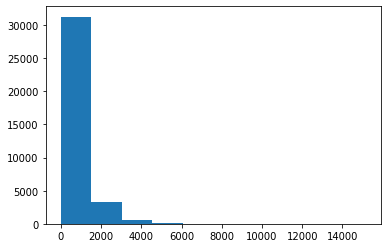

In [39]:
plt.hist(degrees.values())
plt.show()

In [40]:
project.head(3)

id     acronym  status  \
0  817296   eDCaseMAN  CLOSED   
1  764717     WinWind  CLOSED   
2  784994  PentaHelix  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   
2  Multi stakeholder and governance approach for ...  2018-03-01  2021-09-30   

    totalCost ecMaxContribution     legalBasis                 topics  ...  \
0       71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1   2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   
2  1808343,75        1808343,75  H2020-EU.3.3.        EE-09-2016-2017  ...   

  fundingScheme nature                                          objective  \
0         SME-1    NaN  "Electronic discovery (known as e-discovery) i...   
1           CSA    NaN  The overall objective of WinWind is to enhance...   
2           CSA    NaN  The PentaHelix project is focusing on developi...   

     contentUpdateDate     rcn        grantDoi Community New_Community  \
0  2022-08-10 13:07:21  217713  10.3030/817296         0           -99   
1  2022-08-17 10:54:17  211548  10.3030/764717         1             1   
2  2022-04-11 16:42:12  213566  10.3030/784994         1             1   

   New_Community_Name Degree  
0                  14      0  
1                   0    427  
2                   0     74  

[3 rows x 24 columns]

In [41]:
# Trop long a faire tourner

# clustering_coef = nx.clustering(G)
# clustering_coef

In [42]:
degree_centrality = nx.degree_centrality(G)

In [43]:
project = dict_to_df(degree_centrality, project, "Degree_Centrality", dtype="float64")

In [44]:
project.head(2)

id    acronym  status  \
0  817296  eDCaseMAN  CLOSED   
1  764717    WinWind  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   

   totalCost ecMaxContribution     legalBasis                 topics  ...  \
0      71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1  2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   

  nature                                          objective  \
0    NaN  "Electronic discovery (known as e-discovery) i...   
1    NaN  The overall objective of WinWind is to enhance...   

     contentUpdateDate     rcn        grantDoi Community New_Community  \
0  2022-08-10 13:07:21  217713  10.3030/817296         0           -99   
1  2022-08-17 10:54:17  211548  10.3030/764717         1             1   

  New_Community_Name  Degree Degree_Centrality  
0                 14       0          0.000000  
1                  0     427          0.012069  

[2 rows x 25 columns]

Centralité de proximité : cette méthode calcule la centralité d'un noeud en fonction de la distance moyenne à tous les autres noeuds. Plus un noeud est proche des autres noeuds, plus sa centralité est élevée.

In [45]:
# Trop long a faire tourner

# closeness_centrality = nx.closeness_centrality(G)

Centralité de betweenness : cette méthode calcule la centralité d'un noeud en fonction de sa participation aux chemins les plus courts entre tous les autres noeuds. Plus un noeud est sur des chemins courts entre les autres noeuds, plus sa centralité est élevée.

In [46]:
# Trop long a faire tourner

# betweenness_centrality = nx.betweenness_centrality(G)

Centralité de eigenvector : cette méthode calcule la centralité d'un noeud en fonction de la centralité de ses voisins. Les noeuds connectés à des noeuds centraux auront une centralité plus élevée.

In [47]:
# Trop long a faire tourner

# eigenvector_centrality = nx.eigenvector_centrality(G)

### Calcules sur les partitions

On inverse le dictionnaire des partitions

In [48]:
from collections import defaultdict

new_partition = project.set_index('id')["New_Community_Name"].to_dict()
inverted_dict = defaultdict(list)

for key, value in new_partition.items():
    inverted_dict[value].append(key)

In [49]:
subgraphs = {}
for partition_name, nodes in inverted_dict.items():
    subgraphs[partition_name] = nx.induced_subgraph(G, nodes)

In [50]:
subgraphs.keys()

dict_keys([14, 0, 6, 1, 10, 7, 9, 5, 4, 8, 3, 11, 12, 13, 2])

In [51]:
for key in subgraphs.keys():
    print(f"Partition: {key} | Nodes' number: {subgraphs[key].number_of_nodes()} | Edges' number: {subgraphs[key].number_of_edges()}")

Partition: 14 | Nodes' number: 5279 | Edges' number: 13258
Partition: 0 | Nodes' number: 7887 | Edges' number: 1565635
Partition: 6 | Nodes' number: 1920 | Edges' number: 211678
Partition: 1 | Nodes' number: 3541 | Edges' number: 499172
Partition: 10 | Nodes' number: 4934 | Edges' number: 572131
Partition: 7 | Nodes' number: 1689 | Edges' number: 100232
Partition: 9 | Nodes' number: 2428 | Edges' number: 1639611
Partition: 5 | Nodes' number: 1782 | Edges' number: 126960
Partition: 4 | Nodes' number: 972 | Edges' number: 121746
Partition: 8 | Nodes' number: 1034 | Edges' number: 85722
Partition: 3 | Nodes' number: 1489 | Edges' number: 230279
Partition: 11 | Nodes' number: 443 | Edges' number: 76436
Partition: 12 | Nodes' number: 562 | Edges' number: 70680
Partition: 13 | Nodes' number: 535 | Edges' number: 31510
Partition: 2 | Nodes' number: 886 | Edges' number: 239779


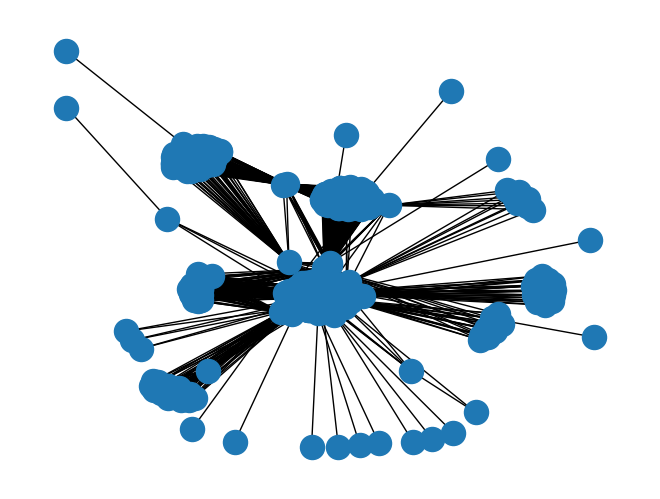

In [75]:
import random
nx.draw(subgraphs[random.choice(list(subgraphs.keys()))])

In [76]:
graph_options = {
    'node_color': 'lightblue',
    'node_size' : 10,
    "edge_color": 'yellow'
}

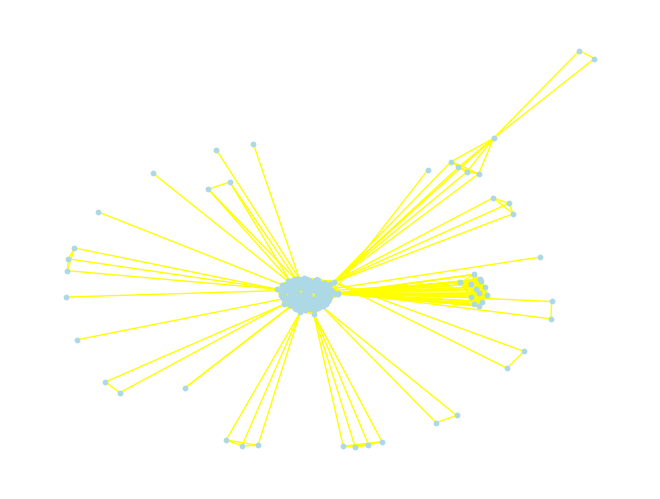

In [77]:
nx.draw(subgraphs[11], **graph_options)

In [52]:
part_metrics = {key:{"density":nx.density(subgraphs[key])} for key in subgraphs.keys()}

In [53]:
part_metrics = {}

for key in subgraphs.keys():
    part_metrics[key] = {
        "density": round(nx.density(subgraphs[key]), 4),
        "mean_degree": round(sum(dict(nx.degree(subgraphs[key])).values()) / subgraphs[key].number_of_nodes(), 4)
#         "mean_subgraph_centrality": round(sum(dict(nx.subgraph_centrality(subgraphs[key])).values()) / subgraphs[key].number_of_nodes(), 4)
#         "tansitity": nx.transitivity(subgraphs[key]) # prend trop de temps
#         "centrality": nx.closeness_centrality(subgraphs[key]) # prend trop de temps
    }

In [54]:
part_metrics

{14: {'density': 0.001, 'mean_degree': 5.0229},
 0: {'density': 0.0503, 'mean_degree': 397.0166},
 6: {'density': 0.1149, 'mean_degree': 220.4979},
 1: {'density': 0.0796, 'mean_degree': 281.9384},
 10: {'density': 0.047, 'mean_degree': 231.9137},
 7: {'density': 0.0703, 'mean_degree': 118.688},
 9: {'density': 0.5565, 'mean_degree': 1350.5857},
 5: {'density': 0.08, 'mean_degree': 142.4916},
 4: {'density': 0.258, 'mean_degree': 250.5062},
 8: {'density': 0.1605, 'mean_degree': 165.8066},
 3: {'density': 0.2079, 'mean_degree': 309.3069},
 11: {'density': 0.7807, 'mean_degree': 345.0835},
 12: {'density': 0.4484, 'mean_degree': 251.5302},
 13: {'density': 0.2206, 'mean_degree': 117.7944},
 2: {'density': 0.6116, 'mean_degree': 541.2619}}

---

## Importation des données de publications

In [84]:
%cd Notebook/

C:\Users\Marin\Desktop\Python\Cours\Cordis\Notebook


In [58]:
publication_0 = pd.read_csv("../Data/CSV/Publications/projectPublications.csv", sep=";")
publication_1 = pd.read_csv("../Data/CSV/Publications/projectPublications_2.csv", sep=";")
publication_2 = pd.read_csv("../Data/CSV/Publications/projectPublications_3.csv", sep=";")
publication_3 = pd.read_csv("../Data/CSV/Publications/projectPublications_4.csv", sep=";")
publication_4 = pd.read_csv("../Data/CSV/Publications/projectPublications_5.csv", sep=";")
publication_5 = pd.read_csv("../Data/CSV/Publications/projectPublications_6.csv", sep=";")

In [59]:
print(publication_0.shape)
print(publication_1.shape)
print(publication_2.shape)
print(publication_3.shape)
print(publication_4.shape)
print(publication_5.shape)

(55001, 16)
(55001, 16)
(55001, 16)
(55001, 16)
(55001, 16)
(26586, 16)


In [60]:
publications_list = [publication_0,
publication_1,
publication_2,
publication_3,
publication_4,
publication_5]

On fusionne tous les dataframes en un seul

In [61]:
publication = pd.DataFrame()
for publi in publications_list:
    publication = pd.concat([publication, publi], axis=0)

### Informations sur les données

In [62]:
publication.shape

(301591, 16)

In [63]:
publication.head()

id                                              title  \
0  823965_1537977_PUBLI  On the Utility of High-Resolution Soil Moistur...   
1  764958_1538020_PUBLI  Thermosensitive hydration of four acrylamide-b...   
2   677120_355435_PUBLI           On property (T) for Aut(F_n) and SL_n(Z)   
3  761042_1539423_PUBLI  Sporulation in solventogenic and acetogenic cl...   
4  871037_1533329_PUBLI  Comprehensive Fragment Screening of the SARS-C...   

            isPublishedAs                                            authors  \
0  Peer reviewed articles  Ait Hssaine, B.; Chehbouni, A.; Er-Raki, S.; K...   
1  Peer reviewed articles  Patrick K. Quoika, Maren Podewitz, Yin Wang, A...   
2  Peer reviewed articles         Marek Kaluba, Dawid Kielak, Piotr W. Nowak   
3  Peer reviewed articles  Mamou Diallo; Servé W. M. Kengen; Ana M. López...   
4  Peer reviewed articles  Berg H, Wirtz Martin MA, Altincekic N, Alshaml...   

                             journalTitle               journalNumber  \
0                          Remote Sensing                         NaN   
1     The Journal of Physical Chemistry B                           2   
2                   Annals of Mathematics  Volume 193 (2021), Issue 2   
3  Applied Microbiology and Biotechnology                         105   
4                 Angew Chem Int Ed Engl.                         NaN   

   publishedYear publishedPages       issn isbn                          doi  \
0         2021.0            NaN  2072-4292  NaN           10.3390/rs13040727   
1         2020.0    9745 - 9756  1520-5207  NaN     10.1021/acs.jpcb.0c07232   
2         2018.0        539-562  0003-486X  NaN  10.4007/annals.2021.193.2.3   
3         2021.0      3533-3557  0175-7598  NaN   10.1007/s00253-021-11289-9   
4         2022.0            NaN  1433-7851  NaN       10.1002/anie.202205858   

   projectID   projectAcronym           collection    contentUpdateDate  \
0     823965            ACCWA  Project publication  2022-09-27 18:18:00   
1     764958         NANOSTEM  Project publication  2022-09-27 18:20:01   
2     677120            INDEX  Project publication  2022-09-30 20:15:15   
3     761042        BIOCONCO2  Project publication  2022-09-27 18:19:56   
4     871037  iNEXT-Discovery  Project publication  2022-09-30 20:17:09   

      rcn  
0  872894  
1  872958  
2  544507  
3  872951  
4  870820

### Traitement sur les données

On calcule le nombre de publications pour chaque projectID

In [64]:
print(len(list(publication["projectID"].value_counts().index)))
pub_project = publication["projectID"].value_counts().to_dict()

19395


In [65]:
pub_project

{633053: 6196,
 681202: 1593,
 696656: 942,
 785219: 876,
 785907: 607,
 881603: 554,
 665778: 512,
 669026: 461,
 654109: 441,
 945539: 428,
 654002: 414,
 654148: 414,
 739551: 409,
 739508: 379,
 692419: 379,
 654305: 378,
 690575: 376,
 643417: 361,
 641816: 351,
 689443: 327,
 789028: 307,
 668995: 305,
 870628: 304,
 761727: 304,
 727872: 295,
 830927: 293,
 654360: 289,
 823717: 279,
 727987: 275,
 663830: 269,
 720270: 267,
 633531: 266,
 654208: 263,
 681228: 251,
 730960: 249,
 654024: 248,
 643476: 243,
 678024: 240,
 692145: 239,
 641122: 238,
 730872: 231,
 664931: 231,
 688995: 230,
 824093: 223,
 633595: 220,
 739593: 218,
 692146: 218,
 691135: 216,
 739582: 215,
 694097: 214,
 713279: 213,
 871149: 211,
 691818: 210,
 713673: 210,
 653706: 207,
 777826: 207,
 692194: 206,
 734922: 205,
 690904: 203,
 691714: 202,
 654168: 201,
 692022: 200,
 712949: 200,
 666881: 199,
 668981: 199,
 733206: 199,
 952215: 198,
 678760: 195,
 713683: 193,
 810980: 192,
 741520: 191,
 817

In [66]:
id_project_publi = list(pub_project.keys())
print(len(id_project_publi))

19395


In [67]:
project[project["id"].isin(id_project_publi)].head(3)

id    acronym      status  \
1  764717    WinWind      CLOSED   
3  841546        RES  TERMINATED   
4  716923  LEVIATHAN      CLOSED   

                                               title   startDate     endDate  \
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   
3  Rights for Ecosystem Services (RES): a framewo...  2020-01-13  2022-01-12   
4  Taming the Leviathan? Legal and Political Acco...  2017-08-01  2022-01-31   

   totalCost ecMaxContribution     legalBasis        topics  ... nature  \
1  2124462,5         2124462,5  H2020-EU.3.3.   LCE-21-2017  ...    NaN   
3  224933,76         224933,76  H2020-EU.1.3.  MSCA-IF-2018  ...    NaN   
4    1184595           1184595  H2020-EU.1.1.  ERC-2016-STG  ...    NaN   

                                           objective    contentUpdateDate  \
1  The overall objective of WinWind is to enhance...  2022-08-17 10:54:17   
3  Is currentIs current legal protection adequate...  2021-12-30 09:44:32   
4  The Euro Crisis has had a transformative effec...  2022-09-08 18:14:15   

      rcn        grantDoi Community New_Community New_Community_Name  Degree  \
1  211548  10.3030/764717         1             1                  0     427   
3  222283  10.3030/841546         1             1                  0     141   
4  206991  10.3030/716923         9             9                  6       9   

  Degree_Centrality  
1          0.012069  
3          0.003985  
4          0.000254  

[3 rows x 25 columns]

Nous n'avons pas tous les ID des projets car ne sont renseignés que les projets ayant publiés. 

In [68]:
def fill_publication(publi: dict, project_id: list):

    for project in project_id:
        if project in list(publi.keys()):
            continue
        else: 
            publi[project] = 0


In [70]:
fill_publication(pub_project, project_id)

La fonction ressortait un ID supplémentaire par rapport au nombre d'ID de projets qui nous avions. <br>
Voici un petit moyent de trouver quel ID est en trop et le supprimer

In [89]:
# Trouver l'ID du projet en trop
count = 0
to_delete = []
for intru in list(pub_project.keys()):
    if intru in project_id:
        continue
#         count += 1
    else: 
        to_delete.append(intru)
        print(to_delete)

In [72]:
# Suppression de ce projet

# del pub_project[743165]
del pub_project[to_delete]

On va ajouter le nombre de publications par projet

In [ ]:
# Quid d'avoir le nomnbre de publications pour faire le graphe ? Cela pourrait-il influer négativemment sur la pertinence
# de notre étude économétrique ? 

On va l'ajouter à notre DataFrame

In [74]:
project = dict_to_df(pub_project, project, "Nb_Publication")

In [75]:
# project.to_csv("../Data/CSV/Projets_updated.csv", index=False)

In [76]:
project.head(3)

id     acronym  status  \
0  817296   eDCaseMAN  CLOSED   
1  764717     WinWind  CLOSED   
2  784994  PentaHelix  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   
2  Multi stakeholder and governance approach for ...  2018-03-01  2021-09-30   

    totalCost ecMaxContribution     legalBasis                 topics  ...  \
0       71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1   2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   
2  1808343,75        1808343,75  H2020-EU.3.3.        EE-09-2016-2017  ...   

                                           objective    contentUpdateDate  \
0  "Electronic discovery (known as e-discovery) i...  2022-08-10 13:07:21   
1  The overall objective of WinWind is to enhance...  2022-08-17 10:54:17   
2  The PentaHelix project is focusing on developi...  2022-04-11 16:42:12   

      rcn        grantDoi Community New_Community New_Community_Name Degree  \
0  217713  10.3030/817296         0           -99                 14      0   
1  211548  10.3030/764717         1             1                  0    427   
2  213566  10.3030/784994         1             1                  0     74   

   Degree_Centrality Nb_Publication  
0           0.000000              0  
1           0.012069              4  
2           0.002092              0  

[3 rows x 26 columns]

---

## Traitement sur le DataFrame | Feature Engineering

On va calculer le temps entres la date de début et de fin du projet

In [77]:
project["Project_Duration"] = (pd.to_datetime(project["endDate"])) - (pd.to_datetime(project["startDate"]))
project["Project_Duration"] = pd.to_numeric(project["Project_Duration"].dt.days, downcast="integer")
# project["Project_Duration"] = project["Project_Duration"].astype("int16")

In [78]:
project.head(2)

id    acronym  status  \
0  817296  eDCaseMAN  CLOSED   
1  764717    WinWind  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   

   totalCost ecMaxContribution     legalBasis                 topics  ...  \
0      71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1  2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   

     contentUpdateDate     rcn        grantDoi Community New_Community  \
0  2022-08-10 13:07:21  217713  10.3030/817296         0           -99   
1  2022-08-17 10:54:17  211548  10.3030/764717         1             1   

  New_Community_Name Degree Degree_Centrality  Nb_Publication Project_Duration  
0                 14      0          0.000000               0            152.0  
1                  0    427          0.012069               4            912.0  

[2 rows x 27 columns]

On va compter le nombre d'organisations par projets

In [79]:
print(len(list(organization["projectID"].value_counts().index)))
orgas_dict = organization["projectID"].value_counts().to_dict()

35381


In [80]:
project = dict_to_df(orgas_dict, project, "Nb_Orga")

On peut aussi compter le nombre d'organisations privées / publiques comme features

In [81]:
project.head(3)

id     acronym  status  \
0  817296   eDCaseMAN  CLOSED   
1  764717     WinWind  CLOSED   
2  784994  PentaHelix  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   
2  Multi stakeholder and governance approach for ...  2018-03-01  2021-09-30   

    totalCost ecMaxContribution     legalBasis                 topics  ...  \
0       71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1   2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   
2  1808343,75        1808343,75  H2020-EU.3.3.        EE-09-2016-2017  ...   

      rcn        grantDoi Community New_Community New_Community_Name Degree  \
0  217713  10.3030/817296         0           -99                 14      0   
1  211548  10.3030/764717         1             1                  0    427   
2  213566  10.3030/784994         1             1                  0     74   

  Degree_Centrality Nb_Publication  Project_Duration Nb_Orga  
0          0.000000              0             152.0       1  
1          0.012069              4             912.0      12  
2          0.002092              0            1309.0      11  

[3 rows x 28 columns]

Compter le nombres de nationalités par projet

In [82]:
nationalities = organization.groupby("projectID")
nationalities = nationalities["country"].nunique()

In [83]:
# nationalities["country"].agg(pd.Series.mode)

In [84]:
project = project.join(nationalities, on="id")

In [85]:
project.head(3)

id     acronym  status  \
0  817296   eDCaseMAN  CLOSED   
1  764717     WinWind  CLOSED   
2  784994  PentaHelix  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   
2  Multi stakeholder and governance approach for ...  2018-03-01  2021-09-30   

    totalCost ecMaxContribution     legalBasis                 topics  ...  \
0       71429             50000  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1   2124462,5         2124462,5  H2020-EU.3.3.            LCE-21-2017  ...   
2  1808343,75        1808343,75  H2020-EU.3.3.        EE-09-2016-2017  ...   

         grantDoi Community New_Community New_Community_Name Degree  \
0  10.3030/817296         0           -99                 14      0   
1  10.3030/764717         1             1                  0    427   
2  10.3030/784994         1             1                  0     74   

  Degree_Centrality Nb_Publication Project_Duration  Nb_Orga country  
0          0.000000              0            152.0        1       1  
1          0.012069              4            912.0       12       6  
2          0.002092              0           1309.0       11       5  

[3 rows x 29 columns]

In [86]:
def regularisation(x):
    
    return x.replace(",", ".")

In [87]:
project['totalCost'] = project['totalCost'].apply(regularisation)
project['totalCost'] = project['totalCost'].astype("float64")

In [88]:
project['ecMaxContribution'] = project['ecMaxContribution'].apply(regularisation)
project['ecMaxContribution'] = project['ecMaxContribution'].astype("float64")

In [1]:
#TODO: Compter nombre établissement universitaire / recherche par projet

---

## Visualisation

In [101]:
project_encoded = pd.get_dummies(project_tmp, columns=["status"])

In [102]:
%cd ..
%cd Scripts/
from mannwhitney_test import mannwhitney_u_test
%cd ..
%cd Notebook

C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré\Scripts
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré\Notebook


In [103]:
res = mannwhitney_u_test(project_tmp.drop(columns=['id', 'acronym', 'status', 'title', 'startDate', 'endDate', 
       'legalBasis', 'topics', 'ecSignatureDate',
       'frameworkProgramme', 'masterCall', 'subCall', 'fundingScheme',
       'nature', 'objective', 'contentUpdateDate', 'rcn', 'grantDoi']))

Community: 0
Community: 1
Community: 2
Community: 3
Community: 4
Community: 5
Community: 6
Community: 7
Community: 8
Community: 9
Community: 10
Community: 11
Community: 12
Community: 13
Community: 14


In [31]:
project.head(3)

id     acronym  status  \
0  817296   eDCaseMAN  CLOSED   
1  764717     WinWind  CLOSED   
2  784994  PentaHelix  CLOSED   

                                               title   startDate     endDate  \
0  Defendable legal cases through an affordable, ...  2018-05-01  2018-09-30   
1  Winning social acceptance for wind energy in w...  2017-10-01  2020-03-31   
2  Multi stakeholder and governance approach for ...  2018-03-01  2021-09-30   

    totalCost  ecMaxContribution     legalBasis                 topics  ...  \
0    71429.00           50000.00  H2020-EU.2.3.  EIC-SMEInst-2018-2020  ...   
1  2124462.50         2124462.50  H2020-EU.3.3.            LCE-21-2017  ...   
2  1808343.75         1808343.75  H2020-EU.3.3.        EE-09-2016-2017  ...   

         grantDoi Community New_Community New_Community_Name Degree  \
0  10.3030/817296         0           -99                 14      0   
1  10.3030/764717         1             1                  0    427   
2  10.3030/784994         1             1                  0     74   

  Degree_Centrality Nb_Publication Project_Duration  Nb_Orga country  
0          0.000000              0            152.0        1       1  
1          0.012069              4            912.0       12       6  
2          0.002092              0           1309.0       11       5  

[3 rows x 29 columns]

In [34]:
project.columns

Index(['id', 'acronym', 'status', 'title', 'startDate', 'endDate', 'totalCost',
       'ecMaxContribution', 'legalBasis', 'topics', 'ecSignatureDate',
       'frameworkProgramme', 'masterCall', 'subCall', 'fundingScheme',
       'nature', 'objective', 'contentUpdateDate', 'rcn', 'grantDoi',
       'Community', 'New_Community', 'New_Community_Name', 'Degree',
       'Degree_Centrality', 'Nb_Publication', 'Project_Duration', 'Nb_Orga',
       'country'],
      dtype='object')

In [53]:
project["nature"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
35376    NaN
35377    NaN
35378    NaN
35379    NaN
35380    NaN
Name: nature, Length: 35381, dtype: object

In [105]:
def saveXLSX(dictionary: dict): 
    sheets = list(dictionary.keys())

    name = "../Data/clustering.xlsx"

    with pd.ExcelWriter(name, engine="xlsxwriter") as writer: 
        for sheet in sheets:
            sheets_name = "Cluster_" + str(sheet)
            dictionary[sheet].to_excel(writer, sheet_name=sheets_name, startcol=0)

In [106]:
saveXLSX(res)

On discrétise le cout des projets pour afficher leur distribution

In [ ]:
project['cost_interval'] = pd.qcut(project['totalCost'], q=10)

In [ ]:
import matplotlib.pyplot as plt

project['cost_interval'].value_counts().sort_index().plot.bar()
plt.xlabel('Cost Interval')
plt.ylabel('Frequency')
plt.show()


In [3]:
project['totalCost'].plot.density()
plt.xlabel('Cost')
plt.ylabel('Density')
plt.show()

NameError: name 'project' is not defined

Calcule et affichage de la matrice de corrélationd des variables numériques.

In [ ]:
corr_matrix = project.drop(columns=['id', 'acronym', 'status', 'title', 'startDate', 'endDate', 
       'legalBasis', 'topics', 'ecSignatureDate',
       'frameworkProgramme', 'masterCall', 'subCall', 'fundingScheme',
       'nature', 'objective', 'contentUpdateDate', 'rcn', 'grantDoi']).corr()

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.show()

---

## R&D part

Immport des packages

In [110]:
# !pip install gensim
# !pip install nltk

  Using cached gensim-4.3.0-cp39-cp39-win_amd64.whl (24.0 MB)
  Using cached Cython-0.29.32-py2.py3-none-any.whl (986 kB)
  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)
  Using cached FuzzyTM-2.0.5-py3-none-any.whl (29 kB)
  Using cached pyFUME-0.2.25-py3-none-any.whl (67 kB)
  Using cached simpful-2.9.0-py3-none-any.whl (30 kB)
  Using cached fst-pso-1.8.1.tar.gz (18 kB)
  Using cached miniful-0.0.6.tar.gz (2.8 kB)
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20445 sha256=247f5d885b3e7a9aa8256afafb0652efff5ad78fb2347550bc188b45128f3223
  Stored in directory: c:\users\marin\appdata\local\pip\cache\wheels\99\66\48\d7ce0c6927f6abf167bbcdee537affc7b92c03632f78028411
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3530 sha256=ef3c501ae2af61d0aa1659467b1455dfbe20d7054ab6512065954e5bfd0cd02a
  Stored in directory: c:\users\marin\appdata\local\pip\cache\wheels\d9\c7\71\db1d4646d963b34c530667501d3d6f34c0825eaffae2f0f2cb
Successfu

In [5]:
%cd ..
%cd Scripts/
from topic_modeling import topicModeling
%cd ..
%cd Notebook

C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré\Scripts
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré
C:\Users\Marin\Desktop\Cours\M2\S1\Projet tuteuré\Notebook


In [3]:
project_tmp = pd.read_csv("../Data/CSV/projects_tmp.csv")

In [4]:
topicModeling(project_tmp, "title")

Texte :  Defendable legal cases through an affordable, easy, integrated and reliable case management software
Topic :  quantum
Texte :  Winning social acceptance for wind energy in wind energy scarce regions
Topic :  quantum
Texte :  Multi stakeholder and governance approach for SECAP development and implementation
Topic :  quantum
Texte :  Rights for Ecosystem Services (RES): a framework to protect the environment and sustainable local communities in the EU.
Topic :  quantum
Texte :  Taming the Leviathan? Legal and Political Accountability in 'Post-Crisis' EU Economic Governance
Topic :  quantum
Texte :  Smart Choices für innovative regional ecosystems. The Power of Connectivity, Entrepreneurship and Science & Research.
Topic :  quantum
Texte :  Global Ecological Custodianship: Innovative International Environmental Law for the Anthropocene
Topic :  quantum
Texte :  Trillium Bridge II - Reinforcing the Bridges and Scaling up EU/US Cooperation on Patient Summary
Topic :  quantum
Texte 

Texte :  A Human City Platform for town and city councils to foster citizen engagement
Topic :  quantum
Texte :  Gender SMART Science Management of Agriculture and life sciences, including Research and Teachning
Topic :  quantum
Texte :  Security controversies: exploring the governance of knowledge, innovation and techno-scientific risks
Topic :  quantum
Texte :  SKYTUNEUP: THE ULTIMATE PLATFORM TO OPTIMIZE AND SECURE THE USE OF PUBLIC CLOUD TO ORGANIZATIONS
Topic :  quantum
Texte :  Sustainable Management of Industrial Heritage as a Resource for Urban Development
Topic :  quantum
Texte :  Common Framework for a European Life Cycle based Asset Management Approach for transport infrastructure networks
Topic :  quantum
Texte :  Fairness and the Moral Mind
Topic :  quantum
Texte :  A Global Value Chain of Research and Innovation: Governance and Power in designing research for sustainable mineral-material uses
Topic :  quantum
Texte :  How the third wave of global judicial (and social) act

Texte :  Why farm and field size matters: Exploring their role for food security and sustainable agriculture in South America
Topic :  quantum
Texte :  Evolutionary history and ecological adaptations of ammonia oxidizing Thaumarchaeota.
Topic :  quantum
Texte :  Ecological Modelling of the Greenland Ice Sheet Surface Ecosystem
Topic :  quantum
Texte :  Promoting the internAtional competitiveness of European Remote Sensing companies through Cross-cluster collaboration
Topic :  quantum
Texte :  Thermally efficient, cost-reduced nanostructured foams for vacuum insulation panels
Topic :  quantum
Texte :  Thermal phenotypes and behavioural syndromes as predictors of resilience to climate change in European freshwater fish
Topic :  quantum
Texte :  Rivers as leak in the terrestrial C sink
Topic :  quantum
Texte :  Between degradation and conservation: The carbon balance of the Chinese karst ecosystem
Topic :  quantum
Texte :  Hydraulic functional traits as determinants of forest function and

Texte :  Risk Based Consenting of Offshore Renewable Energy Projects
Topic :  quantum
Texte :  Does climate change enhance the nanoparticle toxicity of freshwater biofilms?
Topic :  quantum
Texte :  Drying river networks – Understanding and mitigating drought impacts on river ecosystem functioning and biodiversity (MetaDryNet)
Topic :  quantum
Texte :  ARCGATE: maximizing the potential of Arctic Ocean Gateway array
Topic :  quantum
Texte :  Twinning for the advancement of data-driven multidisciplinary research into hydro-climatic extremes to support risk assessment and decision making
Topic :  quantum
Texte :  Predicting the impacts of climate change and management actions for the invasiveness of alien species in Europe
Topic :  quantum
Texte :  Climate Variability and Security Threats
Topic :  quantum
Texte :  A sustainable highly efficient cultivation system that produces plant-based, organic, and healthy food ingredients
Topic :  quantum
Texte :  Enabling carbon accounting of trees 

Texte :  resIlieNT EneRgy systems for climAte Change and susTaInable develOpmeNt
Topic :  quantum
Texte :  FOOD 2030 Flagship Conference on Research and Innovation for Food and Nutrition Security and Quality Empowerment
Topic :  quantum
Texte :  Molecular Characterisation of Anthropogenic Secondary Organic Aerosols.
Topic :  quantum
Texte :  Mixotrophy among small marine phytoflagellates – prevalence and impact on prokaryotic communities
Topic :  quantum
Texte :  Eco-efficient and Healthy Commercial Deep Fryer
Topic :  quantum
Texte :  SQ Building – Solving the Trilemma of Comfort, Energy and Operational Costs in Buildings
Topic :  quantum
Texte :  Supply of dense water to the overflows across the Greenland-Scotland Ridge
Topic :  quantum
Texte :  Risk Assessment and MOnitoring for BRIdges under Scour hazard
Topic :  quantum
Texte :  Consultation Forum for Sustainable Energy in the Defence and Security Sector  (CF SEDSS) Phase II
Topic :  quantum
Texte :  Quantifying the impact of clim

Texte :  Developing a unified spatial modelling strategy that accounts for interactions between species at different marine trophic levels, and different types of survey data.
Topic :  quantum
Texte :  'Farming God's Way': Cultivation and religious practice in contemporary South Africa
Topic :  quantum
Texte :  Energy efficient Mortgage Market Implementation Plan
Topic :  quantum
Texte :  Land Use and Climate Change Attribution for biodiversity impact assessments
Topic :  quantum
Texte :  Coastal and shallow-water monitoring through innovative low-cost technologies for blue growth in the Mediterranean
Topic :  quantum
Texte :  Forecasting RangE dYnamics of Alien species under climate change.
Topic :  quantum
Texte :  A Multi-Scale Earth Observation Indicator System for Land Degradation Assessment of Transitional Mediterranean Climates
Topic :  quantum
Texte :  Epigenetic mechanisms controlling hypoxia and pathogen Stress responses in plants
Topic :  quantum
Texte :  SIMPLA - Sustainabl

Texte :  Opening the cycling and walking tracking potential
Topic :  quantum
Texte :  PRS, a disruptive technology for the industrial repair of large series of reusable plastic articles in the circular economy
Topic :  quantum
Texte :  Sustainable Datacenters Through Immersed Computing
Topic :  quantum
Texte :  Reusable, returnable packaging for e-commerce
Topic :  quantum
Texte :  Development of Advanced Functional Absorbent Products
Topic :  quantum
Texte :  New approach to decentralized production of electricity, water supply and Internet connection, in full autonomy and off-grid
Topic :  quantum
Texte :  Grassfibre raw material and grasspaper products for the retail, paper and packaging industry, helping to reduce plastic and textile pollution and CO2 emissions on a global scale
Topic :  quantum
Texte :  Eco-innovative building products for sustainable construction in a circular economy
Topic :  quantum
Texte :  Hive PRO Protein Factories for a Circular Economy
Topic :  quantum
Tex

Texte :  Swap.com On-line department store for Massive Amount of Pre-owned Items
Topic :  quantum
Texte :  NEXT GENERATION OF ENERGY PERFORMANCE CONTRACTING
Topic :  quantum
Texte :  Greenrail, innovative and sustainable railway sleepers: the greener solution for railway sector
Topic :  quantum
Texte :  Market maturation of a packaging concept for sustainable and resource efficient food packaging
Topic :  quantum
Texte :  open INnovation Ecosystems for Do It Together process
Topic :  quantum
Texte :  ECO-INNOVATIVE PROCESSING TECHNOLOGY FOR BETTER QUALITY AND SHELF LIFE OF FISH PRODUCTS
Topic :  quantum
Texte :  Transformative adaptation towards ocean equity
Topic :  quantum
Texte :  autonomous Multi-electric Recycling Process line
Topic :  quantum
Texte :  Leveraging online services to enhance the efficiency and transparency of recycling and trading of metal throughout the EU.
Topic :  quantum
Texte :  CONTINUED
Topic :  quantum
Texte :  The Greenest Tissue Paper in the World
Topic : 

Texte :  INNOVATIVE AND DISRUPTIVE DRY-VERMICOMPOSTING TOILET CONCEIVED FOR EU STOREYS BUILDINGS
Topic :  quantum
Texte :  European Framework Initiative for Energy and Environmental Efficiency in the ICT Sector
Topic :  quantum
Texte :  European City Calculator: Prospective modelling tool supporting public authorities in reaching climate neutrality
Topic :  quantum
Texte :  Voluntary certification scheme for waste treatment
Topic :  quantum
Texte :  Towards a circular economy: Eliminate waste through an open platform that facilitates material passports
Topic :  quantum
Texte :  Mushroom and biogas production in a circular economy
Topic :  quantum
Texte :  X-Ray Fluorescence, Shape recognition & Machine Learning for Efficient and Economic Recycling of Mixed Metals from Co-mingled Waste.
Topic :  quantum
Texte :  Intelligent Freshtag Labels for Supply Chain Temperature Monitoring
Topic :  quantum
Texte :  The Demography of Sustainable Human Wellbeing
Topic :  quantum
Texte :  TECHNOLOGY 

Texte :  Sustainable Energy Investing and Financing Activation
Topic :  quantum
Texte :  Helping SMEs take the first steps into the Blockchain
Topic :  quantum
Texte :  Proof-of-Concept of a nanobody targeting Osteopontin to inhibit colorectal cancer development
Topic :  quantum
Texte :  Local Training Network on REgenerative medicine and Stem Cell technology in UtrEcht
Topic :  quantum
Texte :  Manufacturing and testing of an allogeneic gamma delta T cell therapy for the treatment of cancer
Topic :  quantum
Texte :  A revolutionary regenerative therapy for management of chronic inflammatory diseases based on neonatal Mesenchymal Stem Cells
Topic :  quantum
Texte :  Pbx proteins as pioneer factors promoting signal specificity in mesodermal differentiation
Topic :  quantum
Texte :  Cardiac micro-engineered tissue for high-throughput screening
Topic :  quantum
Texte :  Functional analysis of Alternative Polyadenylation during neuronal differentiation at single cell resolution
Topic :  qu

Texte :  Bilayered ON-Demand Scaffolds: On-Demand Delivery from induced Pluripotent Stem Cell Derived Scaffolds for Diabetic Foot Ulcers
Topic :  quantum
Texte :  Title of Proposal: Restoring the immune system homeostasis and organ function in severe community acquired pneumonia- induced sepsis through adipose derived allogeneic stem cells (SEPCELL Proje
Topic :  cell
Texte :  Transcriptional reprogramming of Clock at Shoot Apical Meristem in regulating plant organogenesis and growth.
Topic :  quantum
Texte :  Improving therapy of NPM1-mutated AML
Topic :  quantum
Texte :  Characterization of RTEL1 mutations in Hoyeraal-Hreidarsson Syndrome
Topic :  quantum
Texte :  Respirable Advanced Therapeutics for Cystic Fibrosis & other Lung Diseases
Topic :  quantum
Texte :  Dinoflagellate phytotoxins exploitation
Topic :  quantum
Texte :  SmartHeart, a 3D in vitro assay for improved assessment of cardiac drug efficacy and toxicity
Topic :  quantum
Texte :  novel bioreactor Platform for reprOduc

Texte :  Plant lipidome remodelling during cold acclimation
Topic :  quantum
Texte :  Exploring lamin-lipid interactions and the loss of nuclear structural integrity as the molecular determinants of human aging
Topic :  quantum
Texte :  Disruptive platform for sustainable and low-cost amino acid production
Topic :  quantum
Texte :  Cultivated barnacle offspring – the solution for realizing marine aquaculture growth
Topic :  quantum
Texte :  Sea harvesting in the transition from hunter-gatherer to farmer societies. Archeological microscopic and molecular approaches to shell midden stratigraphy
Topic :  quantum
Texte :  Compound-Specific Radiocarbon Analysis to Date Prehistoric Human Cultural Change
Topic :  quantum
Texte :  Engineering Extracellular Matrices for Controlling Structure and Dynamics of Lipid Bilayer Membranes
Topic :  quantum
Texte :  Nanoscale Analytical Methods to gain insight into the Initiation of Short-Term Memory
Topic :  quantum
Texte :  Control of disease tolerance

Texte :  Beta cell GABA secretion: route, physiological function, and potential for pharmacological modulation in diabetes therapy
Topic :  quantum
Texte :  Rhizosphere microbiome recruitment by plants : Expansion of microRNA roles
Topic :  quantum
Texte :  Transgenerational Ecophysiological Responses to Multiple Stressors in a changing Ocean
Topic :  quantum
Texte :  mRNA cap regulation and function in CD8 T cells
Topic :  quantum
Texte :  Patented advanced low-cost multiwell cell-culture system for in-vitro physiologically relevant biomarker screening
Topic :  quantum
Texte :  The Emergence of a Science of Vegetation in Early Modern Natural Philosophy and the Sciences of Life: From Cesalpino to Malpighi
Topic :  quantum
Texte :  Beyond super-resolution: ultra-resolution imaging provides solutions for synapse physiology and brain pathology
Topic :  quantum
Texte :  Defining the role of Arp2/3 complex diversity at multiple scales of biology
Topic :  quantum
Texte :  The interaction and

Texte :  Development and Application of a New Class of Halogenated Reagents to Commercially Valuable Targets
Topic :  quantum
Texte :  A novel cost-effective process to produce prebiotics from by-products of the ethanol industry
Topic :  quantum
Texte :  Automated mini-invasive surgical approach to the treatment of mitral insufficiency
Topic :  quantum
Texte :  Contribution of distinct pyramidal cell types in hippocampal area CA1 to episodic memory formation
Topic :  quantum
Texte :  “Alcohol-impaired driving PREVENTion and personal authentication by a vehicle ignition interlock system“
Topic :  quantum
Texte :  Hierarchical surface patterns from dissolution-reaction-crystallisation mediated evaporation controlled self-assembly (DRC-ECA) and its antimicrobial coating application
Topic :  quantum
Texte :  Customised lipid supplementation of culture media for efficient in vitro cell culture applications
Topic :  quantum
Texte :  Low cost, water Soluble, Injection Moulded polyvinyl alcoho

Topic :  quantum
Texte :  Development and market launch of novel technology for production of nutritionally complete plant proteins called FIDOs - “Functional (Protein) Isolates Derived from Oilseeds”.
Topic :  quantum
Texte :  In vivo Directed Evolution of Ribulose-1,5-Bisphosphate Carboxylase/Oxygenase in Saccharomyces cerevisiae Using an Orthogonal DNA Replication System
Topic :  quantum
Texte :  Design for Resource and Energy efficiency in cerAMic kilns
Topic :  quantum
Texte :  Understanding the molecular mechanisms controlling the orientation of plant cell divisions
Topic :  quantum
Texte :  High Efficiency Distributed Power Plant
Topic :  quantum
Texte :  Turning unexploited food waste into biomethane supplied through local filling stations network
Topic :  quantum
Texte :  Transforming the biodiesel industry to meet Europe’s need for sustainable aviation fuel: business feasibility study, technical validation and real-world demonstration
Topic :  quantum
Texte :  Demonstration o

Texte :  Multi-Material Thermoplastic high pressure Nitrogen Tanks for Aircraft
Topic :  quantum
Texte :  Feasibility of Bio-based Propylene Glycol
Topic :  quantum
Texte :  Centric Reciprocating Compressor
Topic :  quantum
Texte :  Soakback Assessment using LAttice Boltzmann Method and Aerothermal Nodal-network for the Design of the Engine-bay Region
Topic :  quantum
Texte :  Extending On-Demand wheel Drive to On-Road applications
Topic :  quantum
Texte :  Novel technology for biobutanol production
Topic :  quantum
Texte :  Transformation of kraft lignin into a biodegradable biopolymer
Topic :  quantum
Texte :  Smart Valve, low cost, low weight and high reliability for tank and cargo compartment inerting systems.
Topic :  quantum
Texte :  Increased energy efficiency, flexibility and reduction of green-house gases using thermal battery
Topic :  quantum
Texte :  Hypermutated tumors: insight into genome maintenance and cancer vulnerabilities provided by an extreme burden of somatic mutat

Texte :  EFFICIENT INDUSTRIAL GENERATION OF HIGH-PURITY O2 IN IONIC MEMBRANE MODULES
Topic :  quantum
Texte :  Awareness Raising and capacity building Increasing ADoption of EGNSS in urbaN mobility Applications and services
Topic :  quantum
Texte :  First stabilisation device to enable rotation-free and rotation-controlled  lifting and loading of cargo and goods by cranes or helicopters  to make transportation more efficient, reliable and safe
Topic :  quantum
Texte :  Feasibility assessment on the GreenFlux Service  Operations Platform for Smart Charging (GSOP-SC)
Topic :  quantum
Texte :  Smart Tanks for Space
Topic :  quantum
Texte :  INTEGRAL COST-EFFICIENT SYSTEM FOR SMART NAVIGATION OF THE VESSEL
Topic :  quantum
Texte :  Development of innovative automated fibre placement machine for composite fuselage manufacturing with high performance hybrid materials
Topic :  quantum
Texte :  Improving resource efficiency through a protective film for hose reel irrigation
Topic :  quantum
Te

Texte :  Fuel injection from subcritical to supercritical P-T conditions: a unified methodology for coupled in-nozzle flow, atomisation and air-fuel mixing processes
Topic :  quantum
Texte :  Chemical Recycling for the New Plastic Economy
Topic :  quantum
Texte :  Diode Die Fatigue Characterisation and Testing
Topic :  quantum
Texte :  Boosting the efficiency of current agricultural atomisers by using ultrasonics emitters
Topic :  quantum
Texte :  Building a lasting expert network that delivers evidence-based recommendations for Vital Urban Nodes along TEN-T Corridors
Topic :  quantum
Texte :  Prototyping emerging bio-based products from lignocellulose by zero-waste pathways
Topic :  quantum
Texte :  Optimizing Logistic Fleets with Machine Learning to Enable Sustainable On-Demand Deliveries in Cities
Topic :  quantum
Texte :  Shape-shifting of vesicles induced by artificial tubular networks
Topic :  quantum
Texte :  A unique Lead Acid Battery (LAB) recycling technology to reduce CO2 em

Texte :  Organic Ionic Plastic Crystals Nanocomposites for Safer Batteries
Topic :  quantum
Texte :  Natural nEUROactive Mechanical mETAmaterials
Topic :  quantum
Texte :  DNA TRUSTAG - A paradigm shift in authentication technologies
Topic :  quantum
Texte :  Composite tooling for business jet lower wing stiffened panel manufacturing
Topic :  quantum
Texte :  Unique, low-cost, low-footprint, reusable hybrid carrier bag system that enables food to be kept cold/frozen for up to 24 hours
Topic :  quantum
Texte :  Fast-Forwarding to the Future of On-Demand Urban Water Transportation
Topic :  quantum
Texte :  Collaborative RObotic Solution for Advanced Inspection of Complex Composite parts
Topic :  quantum
Texte :  Thermoelectric oxide composites: design through controlled interactions.
Topic :  quantum
Texte :  Nanoporous and Nanostructured Materials for Medical Applications
Topic :  quantum
Texte :  Digital fabrication and integration of Material reuse for environmentally friendly cementi

Texte :  REsearch on ThermoPlastic repAIRs
Topic :  quantum
Texte :  Design and Realization of equipped engine compartments including cowling for a fast compound rotorcraft
Topic :  quantum
Texte :  Automation of hand lay up manufacturing process for composites stiffeners
Topic :  quantum
Texte :  COld sprayed COating on COmposite
Topic :  quantum
Texte :  Neurological evaluation with simple tools to track evolution and perform early detection of neurodegenerative issues
Topic :  quantum
Texte :  Smart secure system to share resources between OWners AND BOrrowers in a peer-to-peer collaborative consumption market
Topic :  quantum
Texte :  Automated 3D Thermal Imaging of Industrial Plants and Residential Buildings by Drones
Topic :  quantum
Texte :  Rapid quality assessment of wood-based materials through spectroscopy
Topic :  quantum
Texte :  Provision of services to enhance the innovation management capacities of SMEs in the East of England - 2014
Topic :  quantum
Texte :  Automatic F

Texte :  Non-contact precision measurement system for structural health monitoring
Topic :  quantum
Texte :  100% recovery and RECYCLing of construction vehicle crAwler TRACKs into constituent rubber and steel for sustainable raw material supply
Topic :  quantum
Texte :  Ultralight and ultrasafe adaptable 3-wheeler
Topic :  quantum
Texte :  In-K Strain System: Carbon Nanotube ink based realization of ultraflexible composite  strain sensors
Topic :  quantum
Texte :  Innovative digital, multi-parametric and predictable calculation model for the production of fibre reinforced 3D printed parts for aviation applications according to ISO9100
Topic :  quantum
Texte :  Miniature colon spectral scanner that gives real-time automatic alerts for pathological findings.
Topic :  quantum
Texte :  (Harmonised Amphenol Radiall Project) - A next generation high density  modular electrical interconnect solution.
Topic :  quantum
Texte :  Radically innovative technology for efficient manufacturing of pre

Texte :  High Performance Nano-structured Composites for Tooling Industry
Topic :  quantum
Texte :  Testing Advanced Basic Structures with novel Low-Cost Solutions
Topic :  quantum
Texte :  Blocknetwork - Fusing Big Data and Implementing Novel Cyber Security Solutions
Topic :  quantum
Texte :  Accurate Full-Field 3D Shape Measurement Technique of Specular Surfaces by Phase-to-Depth Deflectometry
Topic :  quantum
Texte :  Worker 4.0 – Connected. Empowered. Safe and Healthy. The first intelligent and interoperable platform based on AI and wearable/IoT devices for real-time workers safety and health monitoring
Topic :  quantum
Texte :  Evaluation of LAminate composite Distortion by an Integrated Numerical-Experimental approach
Topic :  quantum
Texte :  REVOLUTIONARY ELECTROMAGNETIC ENDOSCOPY ACCESSORY TO AUTOMATIZE POLYP DETECTION
Topic :  quantum
Texte :  Multi-core fibre passive and active devices: 3D shape sensors and laser sources
Topic :  quantum
Texte :  A disruptive smartphone appl

Texte :  HIGH DATA RATE SIGNAL GENERATION FOR 5G WIRELESS COMMUNICATIONS
Topic :  quantum
Texte :  A study to assess the feasibility of commercialising a new antenna system, currently at TRL7, for the Global mobile user market.
Topic :  quantum
Texte :  Introducing the world’s first system for in-air haptic feedback, through ultrasound MEMs arrays
Topic :  quantum
Texte :  TimeAnalyzer in real-time networks
Topic :  quantum
Texte :  5G DRIVEn Resource Efficient Mobile Aggregation Networks
Topic :  quantum
Texte :  ICT-based ENERgy Grid Implementation – Smart and Efficient
Topic :  quantum
Texte :  5G Solutions for European Citizens
Topic :  quantum
Texte :  ULTRA ACCURATE WORLD TIMING SERVICES
Topic :  quantum
Texte :  Research Collaboration and Mobility for Beyond 5G Future Wireless Networks
Topic :  quantum
Texte :  High Frequency FET employing 2D materials for gas sensing
Topic :  quantum
Texte :  Automated inspection tool to unveil defects in raw Gallium Nitride (GaN) and Silicon C

Texte :  Me-Check - Screening of the dry eye syndrome
Topic :  quantum
Texte :  FAST-RESPONSIVE and LONG-LASTING TRANSPARENT PHOTOCHROMIC FILMS
Topic :  quantum
Texte :  Compact, high-power, frequency-converted diode laser systems (CoDiS)
Topic :  quantum
Texte :  Adapter for a commercial grade camera or a smart phone to perform  depth resolved imaging
Topic :  quantum
Texte :  Validation of a Novel Diagnostic Biomarker for Dry Eye Syndrome based in nucleotides detection
Topic :  quantum
Texte :  A novel approach of organ preservation using anti-necrosis agent before transplantation.
Topic :  quantum
Texte :  Cracking the neural code of human object vision
Topic :  quantum
Texte :  A smart hyperspectral system for early, non-invasive diagnosis of retinal disease
Topic :  quantum
Texte :  Developing a cure for retinitis pigmentosa due to Usher syndrome
Topic :  quantum
Texte :  Feature-gating in superior colliculus
Topic :  quantum
Texte :  In vivo histology using femtosecond laser mult

Texte :  A novel solution to eliminate long wires during Intraoperative Neurophysiological Monitoring [WIONM] - Phase 1
Topic :  quantum
Texte :  Physiological consequences of Protocadherin-10 sumoylation on neuronal function.
Topic :  quantum
Texte :  T-cell-induced immune programming and degeneration of the neuronal tissue during chronic autoimmunity
Topic :  quantum
Texte :  Imaging Functional Integration Of Newborn Neurons Into Neural Circuits Of The Axolotl Brain
Topic :  quantum
Texte :  In-toto imaging of C. elegans larval development using adaptive optics light-sheet microscopy
Topic :  quantum
Texte :  Pathogenetic pathways in age-related neurodegenerations as novel therapeutic targets for Parkinson’s disease
Topic :  quantum
Texte :  Hippocampus Extracellular Space Simulator Project (HESSP)
Topic :  quantum
Texte :  Chromatin accessibility landscape and transcription changes in recognition memory after visual imprinting in chicks
Topic :  quantum
Texte :  Polarized light as a

Texte :  The molecular and cellular logic of vertebrate neural development
Topic :  quantum
Texte :  a novel drug for prevention and treatment peripheral neuropathy symptoms
Topic :  quantum
Texte :  Memory Enhancing and Learning System
Topic :  quantum
Texte :  Neurobiology of sensory disturbances induced by ciguatoxins
Topic :  quantum
Texte :  BrainPatch – Breakthrough non-invasive brain stimulation using AI
Topic :  quantum
Texte :  Modulation of the glymphatic system: a novel tool for drug delivery to the central nervous system
Topic :  quantum
Texte :  Multicentric Language Markers of NeuroDegeneration
Topic :  quantum
Texte :  DYNAMIC BRAIN FUNCTION: Towards the Understanding and Treatment of Brain Disorders
Topic :  quantum
Texte :  Vienna International Postdoctoral Program
Topic :  quantum
Texte :  Light induced spatially EXact and genetically encoded labeling of immune cells for monitoring of lOng Distance and Ultra-compartment Shuttling during autoimmunity and chronic inflam

Texte :  A dynamic database of relevant technologies of bio-waste utilisation
Topic :  quantum
Texte :  Bone Surgery Preparation AIde
Topic :  quantum
Texte :  The first portable, low-cost, robotized scanner microscope that converts any smartphone into a high quality and intelligent tele-microscopy image diagnosis system
Topic :  quantum
Texte :  Prudenta: Electronic Solution for Safer Drugs
Topic :  quantum
Texte :  INDustrial TECHnologies 2018 - innovative industries for smart growth
Topic :  quantum
Texte :  Commercialisation of TRACS, An Artificial Intelligence Inspired, Text Response Automation system for Customer Support
Topic :  quantum
Texte :  Innovation Associate for OIP
Topic :  quantum
Texte :  Defining new waste traceability standards for the green Demolition and Construction industry
Topic :  quantum
Texte :  The first holistic restaurant forecasting tool to reduce food waste by predicting future demand
Topic :  quantum
Texte :  JAM: vehicle predictive maintenance through

Texte :  Soft launch for the first thinbking music player
Topic :  quantum
Texte :  AI that composes complex instrumental music for movies, games, advertising and other types of digital media
Topic :  quantum
Texte :  Detection of Early seismic signal using ARtificiaL Intelligence
Topic :  quantum
Texte :  Development and Commercialisation of an Intelligent Wearable Platforms to Stabilise Hand Tremors in Parkinson’s Disease and Essential Tremor
Topic :  quantum
Texte :  Create a business plan for implementing the data-analysis software DatenBerg Backpack in the manufacturing site in the rubber processing industry.
Topic :  quantum
Texte :  AI boosting airport capacity
Topic :  quantum
Texte :  EUROPES FIRST SCALABLE MOBILE MAPPING SOLUTION WHICH EMPOWERS ALL BUSINESSES AND INSTITUTIONS TO ACCESS ESSENTIAL GEO-SPATIAL DATA
Topic :  quantum
Texte :  AutoMatic and Personalized Mental HealthCare Solution
Topic :  quantum
Texte :  We help employees to adopt digital solutions
Topic :  quantu

Texte :  engineering ligand-REceptor INteractions FOR Molecular communicATIONs
Topic :  quantum
Texte :  Strongly correlated phenomena in twisted bilayers of graphene and transition metal dichacogenides
Topic :  quantum
Texte :  Green and straightforward process for the synthesis of Graphene-based nanomaterials.
Topic :  quantum
Texte :  Quick and cost-effective integrated web platform for forest inventories
Topic :  quantum
Texte :  Ultrapermeable Atomically-Thin Membranes for Molecular Separations
Topic :  quantum
Texte :  Unique Light-Matter Interactions with Two-Dimensional Materials
Topic :  quantum
Texte :  The first manufacturing process to obtain reduced graphene oxide at large-scale
Topic :  quantum
Texte :  Environment-Friendly and Cost-Effective Production of Graphene Nano Platelets for Composite Applications
Topic :  quantum
Texte :  Microsatellite radar network for fast update Arctic ice surveillance.
Topic :  quantum
Texte :  Choreographing Emigration: Japanese Tango Musi

Texte :  Multimodal neuroimaging of mechanisms supporting memory-based predictions in the human brain
Topic :  quantum
Texte :  Search And Rescue Aid and Surveillance using High EGNSS Accuracy
Topic :  quantum
Texte :  Neural Spectral Image Decoding
Topic :  quantum
Texte :  e-Solar Performance Analysis and data Collection for Energy Monitoring: an innovative solution based on measures correlation between an autonomous ground-based solar sensor and Earth observation data
Topic :  quantum
Texte :  Developing methods to model local area temporal domestic electricity demand
Topic :  quantum
Texte :  GlucoBeam: A portable device for pain-free glucose self-monitoring in diabetic patients
Topic :  quantum
Texte :  Non-linearity to improve and analyze functional maps for geometric data.
Topic :  quantum
Texte :  International Energy Agency support action for clean energy transitions in emerging economies
Topic :  quantum
Texte :  Melanoma Early Warning System
Topic :  quantum
Texte :  Measuri

Texte :  Improving the Effectiveness of the Capabilities (IEC) in EU conflict prevention
Topic :  quantum
Texte :  The role of chromatin in the long-term adaptation of plants to abiotic stress
Topic :  quantum
Texte :  Climate-resilient pathways for the development of concrete infrastructure: adaptation, mitigation and sustainability
Topic :  quantum
Texte :  KAM and Innovation services for SMEs in Lombardia and Emilia-Romagna
Topic :  quantum
Texte :  Advanced Transmission System for Bicycles
Topic :  quantum
Texte :  Harnessing the power of high altitude winds - the biggest energy resource yet unexploited by humankind
Topic :  quantum
Texte :  Palaeolimnological assessment of methane emissions from lakes in changing environment using stable isotopes
Topic :  quantum
Texte :  Sustainable exploitation of biomass for bioenergy from marginal lands in Europe
Topic :  quantum
Texte :  Innovative system for Bioinspired Atmospheric Water Generation without Input Energy
Topic :  quantum
Texte

Texte :  White-Box Self-Programming Mechanisms
Topic :  quantum
Texte :  eNd to End scalable and dynamically reconfigurable oPtical arcHitecture for application-awarE SDN cLoud datacentErs
Topic :  quantum
Texte :  TRANSPARENT APPLICATION DEPLOYMENT IN A SECURE, ACCELERATED AND COGNITIVE CLOUD CONTINUUM
Topic :  quantum
Texte :  A unified network, Computational and stOrage resource Management framework targeting end-to-end Performance optimization for secure 5G muLti-tEchnology and multi-Tenancy Environments
Topic :  quantum
Texte :  Scalable Software Defined Network Architectures for Cooperative Live Media Production exploiting Virtualised Production Resources and 5G Wireless Acquisition
Topic :  quantum
Texte :  Gridded Ion Engine Standardised Electric Propulsion Platforms
Topic :  quantum
Texte :  PERIOD - PERASPERA In-Orbit Demonstration
Topic :  quantum
Texte :  SATELLITE-BASED ADS-B FOR LOWER SEPARATION-MINIMA APPLICATION (SALSA)
Topic :  quantum
Texte :  Space Qualification and 

Topic :  quantum
Texte :  WELCOME: PAN-EUROPEAN WEB ENTREPRENEURSHIP AND STARTUP ECOSYSTEM
Topic :  quantum
Texte :  Pilot scale demonstration of novel CO2 co-polymerisation catalysts in the PU polyol market
Topic :  quantum
Texte :  Enhance innovation management capacities in Andalusian SMEs. CESEAND InnoAses 2017-18.
Topic :  quantum
Texte :  Atom-Tunneling in Chemistry
Topic :  quantum
Texte :  Nanostructured anode catalyst layer for oxygen evolution reaction based on a novel thin-film architecture
Topic :  quantum
Texte :  Unrestricted Divide-Expand-Consolidate Coupled Cluster Methods for Large Open-Shell Molecules
Topic :  quantum
Texte :  Gain by Strain: Precise Cuts of Cyclopropanes as Key to Molecular Complexity
Topic :  quantum
Texte :  EES Innovation CSA
Topic :  quantum
Texte :  Disrupting fine chemicals manufacturing with catalyst-coated tube reactors
Topic :  quantum
Texte :  Metal-Organic Cages for Catalysis Applications
Topic :  quantum
Texte :  EEN Scotland EIMC
Topic :

Texte :  SCIENCE HOTEL 'HUMANIMAL'
Topic :  quantum
Texte :  Platform for Innovation of Procurement and Procurement of Innovation
Topic :  quantum
Texte :  EU-TOPIA: TOWARDS IMPROVED SCREENING FOR BREAST, CERVICAL AND COLORECTAL CANCER IN ALL OF EUROPE
Topic :  quantum
Texte :  Automated framework for rapid simulations of high-detail brain models
Topic :  quantum
Texte :  Dissecting the cellular and molecular dynamics of bone marrow fibrosis for improved diagnostics and treatment
Topic :  quantum
Texte :  A social application, which helps to generate ideas, solve problems while using the cyber-space and cyber-society
Topic :  quantum
Texte :  The World’s Most Secure Cryptocurrency Safeguarding Solution
Topic :  quantum
Texte :  Advanced devices for the Reduction of CArbon DIoxide and Artificial photosynthesis
Topic :  quantum
Texte :  Rapid access to functionalized cyclobutanes via ring expansion strategies
Topic :  quantum
Texte :  The Combination of Electrochemistry and Nickel Cataly

Texte :  Magnetic micromachines based on protocell design and engineering
Topic :  quantum
Texte :  Integrated method for treating a wide range of industrial waste waters based on magnetic settling and catalytic oxidation
Topic :  quantum
Texte :  Air Blade Life Extension
Topic :  quantum
Texte :  1,2-Dicarbofunctionalization of Alkenes by Merging Photoredox and Transition-Metal Catalysis
Topic :  quantum
Texte :  A novel, cost-, time- and energy-efficient, electric hammer to replace the traditional hydraulic hammer
Topic :  quantum
Texte :  Energy Behaviour Change driven by plug-and-play-and-forget ICT and Business Models focusing on complementary currency for Energy Efficiency for the Wider Population
Topic :  quantum
Texte :  Boron chemistry in a new light: exploring the radical reactivity of boronate complexes through photochemical strategies
Topic :  quantum
Texte :  Photo-ElectroCatalysis: New activation paradigm
Topic :  quantum
Texte :  Unity
Topic :  quantum
Texte :  Platinum-

Texte :  Solar Dinitrogen Activation
Topic :  quantum
Texte :  Smart Sensor System for Food Safety, Quality Control and Resource Efficiency in the Food Processing Industry
Topic :  quantum
Texte :  Understanding the interaction between metal nanoparticles and biological membranes
Topic :  quantum
Texte :  Molecular machines based on coiled-coil protein origami
Topic :  quantum
Texte :  Spatiotemporal control of neuroinfection by meningeal macrophages
Topic :  quantum
Texte :  Assessing Sectoral Perspectives on Climate Transitions to support the Global Stocktake and subsequent NDCs
Topic :  quantum
Texte :  MagnifiCOF - Shaping Covalent Organic Frameworks for Industrial Applications
Topic :  quantum
Texte :  Mechanical Chirality: Synthesis, Properties and Applications at a New Horizon in Supramolecular Stereochemistry
Topic :  quantum
Texte :  Dinuclear Gold Catalysis: A New Platform for Cross-Coupling Reactions
Topic :  quantum
Texte :  Cities as Arenas of Political Innovation in the S

Texte :  Assessing the role of ribosomes and mRNA translation in shaping the inflammatory response
Topic :  quantum
Texte :  TEStabiliTy pAttern-driven weB appLication sEcurity and privacy testing
Topic :  quantum
Texte :  FIBER-optic sensors for Smart Thermal Ablation at Radiofrequency
Topic :  quantum
Texte :  Information Theory for Low-Latency Wireless Communications
Topic :  quantum
Texte :  INTEGRATION AND PROPAGATION OF IMMUNOLOGICAL SIGNALS DURING CANCER AND INFECTION
Topic :  quantum
Texte :  Liquid biopsies and Imaging for improved cancer care
Topic :  quantum
Texte :  Expanding and extending gene therapy of monogenic diseases of the haematopoietic system
Topic :  quantum
Texte :  Antibiotic Distribution and Recovery in Tissue
Topic :  quantum
Texte :  Fecal miRNAs, new mediators of host-microbiota interaction in Inflammatory Bowel Disease
Topic :  quantum
Texte :  P53-dependent Metabolic and Epigenetic Reprogramming in Carcinogenesis
Topic :  quantum
Texte :  A mimetic implan

Topic :  quantum
Texte :  Neural mechanisms of spectral context effects on auditory processing
Topic :  quantum
Texte :  Chromatographic micro-column development for pharmaceutical applications in zebraFish
Topic :  quantum
Texte :  New RAN TEchniques for 5G UltrA-dense Mobile networks
Topic :  quantum
Texte :  Intelligent Hybrid Thermo-Chemical District Networks
Topic :  quantum
Texte :  Toward a new generation of miniature multifrequency antennas using multiresonance platform based on subwavelength structures inspired by advanced metamaterials
Topic :  quantum
Texte :  Implementation of ACT in Daily Life
Topic :  quantum
Texte :  Super-resolution genomic mapping for the microbiome
Topic :  quantum
Texte :  How to deal with how you feel: Understanding and training context-dependent emotion regulation
Topic :  quantum
Texte :  Microbes in the city: a metagenomic trait-based analysis of microbial metacommunity structure along urbanization gradients
Topic :  quantum
Texte :  Development 

Texte :  Vortex sheets - from new intuitions to crucial questions.
Topic :  quantum
Texte :  Multi-functional DUAL PHOSphorus-based organoCATalysts for stereoselective ring-opening polymerisation
Topic :  quantum
Texte :  Sparse Robust Expander with Applications in Combinatorial Embedding Problems
Topic :  quantum
Texte :  Relative Rank Theory: A Computational Model of Preferences, Choices, Attitudes and Opinions
Topic :  quantum
Texte :  Queer Interventions on Self-Harm in Prison
Topic :  quantum
Texte :  Neoliberal Terror: The Radicalisation of Social Policy in Europe
Topic :  quantum
Texte :  Discovery of new herbicides through an exploration of the chemistry and biology of the naturally occurring phyllostictines
Topic :  quantum
Texte :  Tokens and their Cultural Biography in Athens from the Classical Age to the End of Antiquity
Topic :  quantum
Texte :  Large Discrete Structures
Topic :  quantum
Texte :  Plant metallothioneins as potential players in food security
Topic :  quantum

Texte :  New method to mechano-spectroscopically investigate the transient evolution of a complex-fluid's microstructure subjected to a non-linear deformation or flow
Topic :  quantum
Texte :  Next generation Pass-By Noise approaches for new powertrain vehicles
Topic :  quantum
Texte :  Mental Health Promotion and Intervention in Occupational Settings: MENTUPP
Topic :  quantum
Texte :  Synthesis of Spirooxindoles and INdoles pharmaceuticals using Metal-Organic Frameworks
Topic :  quantum
Texte :  A new approach to revealing the composition of kimberlite melts and their deep mantle source
Topic :  quantum
Texte :  Spatial non-market VAluation for Biodiversity policy
Topic :  quantum
Texte :  GlioDx - Blood platelet-based monitoring and treatment optimisation for glioblastoma patients
Topic :  quantum
Texte :  The Proton Size Puzzle: Testing QED at Extreme Wavelengths
Topic :  quantum
Texte :  The Social Epistemology of Argumentation
Topic :  quantum
Texte :  How the expression of moral 

Texte :  'Fostering Resilience' in Front-line Environmental Management Practice: A Multi-Sited Ethnography of Novel Constellations of Environmental Value in Practice
Topic :  quantum
Texte :  Solving large systems of polynomial equations by using multi-linear algebra tools
Topic :  quantum
Texte :  Plasticity of the Predictive Mind
Topic :  quantum
Texte :  Spatial dependencies of storm surges and global risk assessment.
Topic :  quantum
Texte :  Disentangling metaphase chromosome organisation one chromosome at a time
Topic :  quantum
Texte :  Boosting motor learning through sleep and targeted memory reactivation in ageing and Parkinson’s disease
Topic :  quantum
Texte :  Commonsense and Anticipation enriched Learning of Continuous representations sUpporting Language UnderStanding
Topic :  quantum
Texte :  Urban networks: multidisciplinary research into the formation of early urban societies in Campania (Italy)
Topic :  quantum
Texte :  Synthesising Inductive Data Models
Topic :  quant

Texte :  A hybrid framework to characterize SLiM Mimicry by Leishmania (SMILE) parasites.
Topic :  quantum
Texte :  Development of a new CRISPR-Cas3-based tool for large genomic deletions
Topic :  quantum
Texte :  Four-dimensional physical modeling and numerical simulation of the early mouse embryo morphogenesis.
Topic :  quantum
Texte :  Defining the mechanism of the dual spindle assembly and alignment in the mammalian zygote
Topic :  quantum
Texte :  HCA|Organoid: Pilot action to establish a multi-tissue human organoid platform within the Human Cell Atlas as a booster of future disease-centric, mechanistic, and translational research
Topic :  quantum
Texte :  Cabin nOise reductioN ground Checked by nEw loudspeakeR exciTatiOn
Topic :  quantum
Texte :  Conflict and Cooperation in the EU Heterarchical Legal System
Topic :  quantum
Texte :  Exploring the human gut microbiome at strain resolution
Topic :  quantum
Texte :  Next generation single molecule protein fluorescence
Topic :  quant

Topic :  quantum
Texte :  Elastic Metamaterial-aided impulse aerodynamic Force measurement techniques
Topic :  quantum
Texte :  Virtual building acoustics: a robust and efficient analysis and optimization framework for noise transmission reduction
Topic :  quantum
Texte :  Water Forced in Hydrophobic Nano-Confinement: Tunable Solvent System
Topic :  quantum
Texte :  QUANTIFYING THE EXTENT FUNGAL MYCORRHIZAL COMMUNITIES AFFECT ORCHID NICHE BREADTH AND GEOGRAPHICAL DISTRIBUTION
Topic :  quantum
Texte :  Magnetic Doping of 3D Dirac Semimetals
Topic :  quantum
Texte :  a.r.t.e.s. EUmanities - European Graduate School for the Humanities Cologne
Topic :  quantum
Texte :  SAFEguard of Critical heAlth infrastructure
Topic :  quantum
Texte :  Understanding how biotic interactions influence the distribution of epiphytic orchids in tropical forests: An integrated network approach.
Topic :  quantum
Texte :  Investigating the interplay between VWF, platelets, and neutrophil extracellular traps in p

Texte :  Bringing added value to agriculture and forest sectors by closing the research and innovation divide
Topic :  quantum
Texte :  Whole-plant Assessment of Innovative, Sustainable and Energy-efficient Future Layouts of Wastewater Treatment Plants
Topic :  quantum
Texte :  Synergistic engineering of anti-tumor immunity by synthetic biomaterials
Topic :  quantum
Texte :  Drug repurposing for inhibiting pathogenic biofilms and potentiating the activity of antibiotics
Topic :  quantum
Texte :  Nanomethods to understand what makes an endogenous protein immunogenic
Topic :  quantum
Texte :  Join Us to Optimize Health Through Cohort Research
Topic :  quantum
Texte :  Agents of Change: Women Editors and Socio-Cultural Transformation in Europe (1710-1920)
Topic :  quantum
Texte :  Novel Echoes. Ancient Novelistic Receptions and Concepts of Fiction in Late Antique and Medieval Secular Narrative from East to West
Topic :  quantum
Texte :  Software Enhanced Research iN Transient kinetics
Top

Texte :  The earliest migration of Homo sapiens in Southern Europe: understanding the biocultural processes that define our uniqueness
Topic :  quantum
Texte :  Resilient Synthetic Vision for Advanced Control Tower Air Navigation Service Provision
Topic :  quantum
Texte :  CO-creating sustainable and competitive FRuits and vEgetableS’ value cHains in Europe
Topic :  quantum
Texte :  Bottom-up initiatives and anti-corruption technologies: how citizens use ICTs to fight corruption
Topic :  quantum
Texte :  Galactic archeology with high temporal resolution
Topic :  quantum
Texte :  Quantifying urban mines in Europe and related implications for the metal-energy-climate change nexus
Topic :  quantum
Texte :  COOPeration of bioeconomy clusters for bio-based knowledge transfer via Innovative Dissemination techniques in the primary production sector
Topic :  quantum
Texte :  A holistic structural analysis method for cultural heritage structures conservation
Topic :  quantum
Texte :  exhumed fo

Texte :  European Knowledge repository for  best agricultural practices
Topic :  quantum
Texte :  Pathophysiology of platelet-derived Interleukin 1
Topic :  quantum
Texte :  Learning to bracket broadly
Topic :  quantum
Texte :  Financial Governance: Policy Implementation and Solidarity through EU funding
Topic :  quantum
Texte :  Bioprinting on-chip microphysiological models of humanized kidney tubulointerstitium
Topic :  quantum
Texte :  The impact of 'free' digital offers on individual behavior and its implications for consumer and data protection laws
Topic :  quantum
Texte :  ASSISTED LIVING TECHNOLOGIES FOR THE HEALTH TOURISM SECTOR
Topic :  quantum
Texte :  Towards Guaranteeing the Right to Effective Assistance of Defence Counsel in Member States in Trans-border Criminal Cases
Topic :  quantum
Texte :  Self Conversation in Virtual Reality Embodiment to Enhance Healthier Lifestyles Among Obese People
Topic :  quantum
Texte :  Speedmeter: Quantum back-action noise-free interferomet

Texte :  International network for Leveraging sUccessful Cultural heritage Innovations and Diplomacy, cApacity building and awaREness raising
Topic :  quantum
Texte :  High efficient localized photon sources
Topic :  quantum
Texte :  An innovative solution to tackle food waste through the collaborative power of ICT networks
Topic :  quantum
Texte :  Applying silicon solar cell technology to revolutionize the design of thin-film solar cells and enhance their efficiency, cost and stability
Topic :  quantum
Texte :  Intranet of Neurons: A Minimally-invasive and High-capacity Transcranial Telemetry Network for Large-scale Brain-wide Neural Recordings
Topic :  quantum
Texte :  Magnetoelectric Ultra-low-power Spin-wave Transducers
Topic :  quantum
Texte :  Smart Reconfigurable photovoltaic modules for Building Integrated PhotoVoltaic applications
Topic :  quantum
Texte :  Zero damage Ultra-Low-K etch using the precursor CONDensation technique
Topic :  quantum
Texte :  Coexistence and conflic

Texte :  Stressfully Transmitted Diseases: How your partner’s past stress affects your current and future health
Topic :  quantum
Texte :  Understanding the light-fastness of heritage Turkey Red textiles through modern dye chemistry and historical dyeing technology to inform sustainable display and access
Topic :  quantum
Texte :  GRAvitational waves from Neutron stars: Investigating Transient Emission
Topic :  quantum
Texte :  Molecular epidemiology of Bacillus anthracis: novel data and techniques for local surveillance in Tanzania
Topic :  quantum
Texte :  Mechanisms and Consequences of Attributing Socialness to Artificial Agents
Topic :  quantum
Texte :  MMP and Mirrors via Maximal Modification Algebras
Topic :  quantum
Texte :  Differential costs of social living in nature
Topic :  quantum
Texte :  Intergenerational transfer of ageing: effects of maternal age at breeding on offspring performance
Topic :  quantum
Texte :  Pathways to Heritage: Community heritage and  the archaeology

Texte :  Response of Earth system to extreme palaeoclimatic and palaeoenvironmental changes: A multiproxy study of the aftermath of the Toarcian hyperthermal
Topic :  quantum
Texte :  Characterization of the role of netrin-1 in the regulation of the Epithelial-to-Mesenchymal Transition during tumor progression.
Topic :  quantum
Texte :  Easy-to-Implement Energy-Based Control Design for Systems of Conservation Laws
Topic :  quantum
Texte :  Understanding the influence of human and organizational factors on surgeon performance to enhance patient outcomes: experimental evaluation of a customized coaching program
Topic :  quantum
Texte :  Innovative stormwater asset management in future cities
Topic :  quantum
Texte :  From Liouville to Kolmogorov: 2d quantum gravity, noise sensitivity and turbulent flows
Topic :  quantum
Texte :  Cross-layer cognitive optimization tools & methods for the lifecycle support of dependable CPSoS
Topic :  quantum
Texte :  Investigating Dishonesty with Experime

Texte :  The Next 100 Optimizing Compilers
Topic :  quantum
Texte :  Comparative genomics of sugar-eating bats: Implications for the genetics of glucose metabolism and diabetes
Topic :  quantum
Texte :  High performance low cost electric propulsion system development
Topic :  quantum
Texte :  Fashioning Georgian Englishness: Race, National Identity, and Codes of Proper Behaviour
Topic :  quantum
Texte :  MUltiplex Government Networks Analysis and InvestigatiOn
Topic :  quantum
Texte :  Models of noncommutative differential geometries
Topic :  quantum
Texte :  Textuality and Diversity: A Literary History of Europe and its Global Connections, 1545-1659
Topic :  quantum
Texte :  Atomistic to Molecular to Bulk Turbulence
Topic :  quantum
Texte :  Statistical Host Identification As a Test of Dark Energy
Topic :  quantum
Texte :  Resolution Pharmacology and Physiology of MCTR in Arthritis
Topic :  quantum
Texte :  Multifunctional graphene/silicone nacre-like composite films
Topic :  quantum


Texte :  Hyaluronan-rich matrices crosslinked with collagen-like peptides for 3D culture of ovarian cancer cells
Topic :  quantum
Texte :  Savage Warfare: A Cultural History of British and American Colonial Campaigns 1885-1914
Topic :  quantum
Texte :  The Cultural Logic of Honor and Social Interaction: A Cross-Cultural Comparison
Topic :  quantum
Texte :  System  for  detection of  Threat Agents in  Maritime Border  Environment
Topic :  quantum
Texte :  Microbiota and Resolvins in Arthritis
Topic :  quantum
Texte :  Numbers in the brain: the impact of brain lateralization on numerical abilities
Topic :  quantum
Texte :  Legitimacy, Sovereignty and the Public Sphere
Topic :  quantum
Texte :  Bootstrap and Uniqueness for Form Factors and the S-matrix
Topic :  quantum
Texte :  Wearable technologists Engage with Artists for Responsible innovation
Topic :  quantum
Texte :  The Divine Tragedy of Securing the Sacred: Religion, Security and Nationalism in Southeast Asia
Topic :  quantum
Texte

Texte :  Mechanism of nucleosome assembly during DNA replication
Topic :  quantum
Texte :  Steering organic farming transition
Topic :  quantum
Texte :  Illuminating neural microcircuitry underlying flicker resonance in the visual cortex
Topic :  quantum
Texte :  Visualisation of translation initiation reaction on single mRNA molecules in vivo
Topic :  quantum
Texte :  Coordination of regional dopamine release in the striatum during habit formation and compulsive behaviour
Topic :  quantum
Texte :  Migrant youth mobility in Europe: patterns, processes and consequences
Topic :  quantum
Texte :  The ERA Chair for Translational Genomics and Personalized Medicine
Topic :  quantum
Texte :  Prediction and Anticipation of Actions: Modelling How We Foresee the Others
Topic :  quantum
Texte :  Integrated Network of Sleep-Optimizing Modules for Norm-Informed Adaptive Behavioural, Environmental And Therapeutic Internet Training
Topic :  quantum
Texte :  Women, Photography and Resistance in Transn

Topic :  quantum
Texte :  Phenotypic screening the host antimicrobial responses towards the eradication of Mycobacterium tubercuosis
Topic :  quantum
Texte :  Scientific Excellence in Animal Reproductive Medicine and Embryo Technology
Topic :  quantum
Texte :  Postdoctoral Programme in Bioengineering Excellence Scientific Training
Topic :  quantum
Texte :  EMpowerment through liquid Integration of Migrant Youth in vulnerable conditions
Topic :  quantum
Texte :  Probing and controlling the three-dimensional organoid mechanobiology
Topic :  quantum
Texte :  Engineering kidney organoids to study the interplay between Tissue Mechanics and Metabolism: from development to disease
Topic :  quantum
Texte :  Engineering epithelial shape and mechanics: from synthetic morphogenesis to biohybrid devices
Topic :  quantum
Texte :  Cost Effective Neural Technique for Alleviation of Urban Flood Risk
Topic :  quantum
Texte :  Mechanical regulation of cellular behaviour in 3D viscoelastic materials
Topi

Texte :  Cracking the Translation Regulatory Code
Topic :  quantum
Texte :  Photoelectrochemical Hydrogen Production from H2S in a Regenerative Scrubber
Topic :  quantum
Texte :  The outstanding challenge in solid mechanics: engineering structures subjected to extreme loading conditions
Topic :  quantum
Texte :  MAKing Sustainable development and WELL-being frameworks work for policy analysis
Topic :  quantum
Texte :  Comprehensive experimental and computational mechanical characterisation of metastatic vertebrae
Topic :  quantum
Texte :  Novel Dark Matter Searches with Top Quarks at the Large Hadron Collider
Topic :  quantum
Texte :  Rural-Urban Outlooks: Unlocking Synergies
Topic :  quantum
Texte :  SHADOWS: Tackling Undeclared Work in the European Union
Topic :  quantum
Texte :  Sustainable finance for sustainable agriculture and fisheries
Topic :  quantum
Texte :  Reconstructing wiring rules of in vivo neural networks using simultaneous single-cell connectomics and transcriptomics


Topic :  quantum
Texte :  Through the eye of a mosquito: theoretical modelling of vector-borne zoonotic pathogens
Topic :  quantum
Texte :  The Neural and Network Dynamics of Social Influence Across Adolescence
Topic :  quantum
Texte :  Towards a neural and cognitive architecture of consciousness
Topic :  quantum
Texte :  Rejection Regimes: An Ethnographic Study of the Social Life of Intra-EU Border Regimes
Topic :  quantum
Texte :  Marriage, Migration and Sexuality: African Migrants in Interracial Same-sex Partnerships
Topic :  quantum
Texte :  Separation Technology for A Million Peaks
Topic :  quantum
Texte :  Enabling the transferability of cycling innovations and assessment of its implications
Topic :  quantum
Texte :  Unconditional parental regard: Its nature and its consequences
Topic :  quantum
Texte :  Competition, time pressure, public speaking and multitasking: The role of willingness and ability to cope with pressure in explaining individual differences and inequality in car

Texte :  Ecosystem response to drought: unravelling the unexplored role of plant-soil feedback
Topic :  quantum
Texte :  Ecological and Evolutionary consequences of predator-prey phenological match-mismatch driven by climate change
Topic :  quantum
Texte :  The Disrupted Society: mapping the societal effects of blockchain technology diffusion
Topic :  quantum
Texte :  The impact of recent retrotransposon invasions on the evolution of human neural gene expression
Topic :  quantum
Texte :  The daily governance of transit migration in Turkey at European Union borders: The two-way influence of Turkish-European Union border and migration management practices
Topic :  quantum
Texte :  The Reconfiguration of Whiteness in China: Privileges, Precariousness, and Racialized Performances
Topic :  quantum
Texte :  A multi-sited and transnational study of transitions towards post-fossil fuel societies
Topic :  quantum
Texte :  The Epistemic and Dynamic Aspects of Polarization.
Topic :  quantum
Texte

Texte :  Role of Apolipoproteins L in immunity and disease
Topic :  quantum
Texte :  Trade Agreements and Supply Chains
Topic :  quantum
Texte :  Tools to Carve out Conformal Field Theories
Topic :  quantum
Texte :  The Effects of Broadband Internet on Mental Health
Topic :  quantum
Texte :  At a Crossroads of Bantu Expansions: Present and Past Riverside Communities in the Congo Basin, from an Integrated Linguistic, Anthropological and Archaeological Perspective
Topic :  quantum
Texte :  ALTERNATIVE SPLICING NETWORKS IN PANCREATIC BETA CELLS
Topic :  quantum
Texte :  Disentangling the stringent response to engineer novel anti-persister drugs
Topic :  quantum
Texte :  Tracking and Targeting Tumor States at single-cell resolution in real time in vivo
Topic :  quantum
Texte :  Political Economy with Many Parties: Strategic Electorate and Strategic Candidates
Topic :  quantum
Texte :  Gender, emotions and national identities: a new perspective on the abortion debates in Italy (1971-1981).


Texte :  Effective Methods in Tame Geometry and Applications in Arithmetic and Dynamics
Topic :  quantum
Texte :  Elucidating the Molecular Mechanism of  Myoblast Fusion in Vertebrates
Topic :  quantum
Texte :  Surrounded by Science: Learning paths towards science proficiency
Topic :  quantum
Texte :  VISUALIZATION OF TOPOLGICAL STATES IN PRISTINE NANOWIRES
Topic :  quantum
Texte :  Decoding the host-pathogen interspecies crosstalk at a multiparametric single-cell level
Topic :  quantum
Texte :  Organizing, Promoting and ENabling HEritage Re-use through Inclusion, Technology, Access, Governance and Empowerment
Topic :  quantum
Texte :  Cross-evolutionary dissection of the functional plasticity of the ribosomal epitranscriptome
Topic :  quantum
Texte :  Analysis, Design and Experimental Evolution of Novel Carbon Fixation Pathways
Topic :  quantum
Texte :  Molecular Quantum Machines
Topic :  quantum
Texte :  From Local Elements to Globally Ordered TOPological states of matter
Topic :  qu

Texte :  Sputtering-deposition of metallic nanoparticles onto chiral ionic liquids and applications in enantioselective hydrogenation
Topic :  quantum
Texte :  Organo-Catalytic Nanoparticles  for Organic Synthesis
Topic :  quantum
Texte :  Diabetes Immunoengineering: Redesigning Encapsulated Cell Transplant Therapies
Topic :  quantum
Texte :  Development of computational and experimental noise assessment and suppression methodologies for the next generation of silent distributed propulsion configurations
Topic :  quantum
Texte :  A topological approach to electron correlation in density-functional theories
Topic :  quantum
Texte :  Enantioselective Nickel-Catalyzed trans-Carbometallative Couplings and Cyclizations
Topic :  quantum
Texte :  Big Medical Data Use in Primary Care: an ethnographic, socio-technical, investigation of challenges and opportunities
Topic :  quantum
Texte :  Generation and Application of Nucleophilic Allylmetal Species by Catalytic 1,4-Metal Migration
Topic :  qu

Texte :  Therapeutic antibody drug monitoring using bioluminescent sensors proteins and a smartphone
Topic :  quantum
Texte :  Intra and inter-generational effects of heatwaves on sexually selected traits and reproductive success
Topic :  quantum
Texte :  Enhanced brown adipose tissue activity using nanotechnology approaches
Topic :  quantum
Texte :  Study of the role of mitophagy and lysosomal biogenesis in COX deficiency: a new model for drug discovery
Topic :  quantum
Texte :  TOWARD A PHILOSOPHICAL RETHINKING OF TRANSLATION: Effects of Translation in a Contemporary European Space
Topic :  quantum
Texte :  Self-selection of a multivalent nanosystem for carbohydrate recognition
Topic :  quantum
Texte :  Photo(electro)catalytic Nitrogen Fixation
Topic :  quantum
Texte :  Surface-supported Molecular ARchiTectures: THEory Meets Experiment
Topic :  quantum
Texte :  Geophysical Roots Observation for Water savING in arboriculture, viticulture and agronomy
Topic :  quantum
Texte :  Nanogran

Topic :  quantum
Texte :  Elucidating the mechanism of mechanotransduction through YAP and TAZ
Topic :  quantum
Texte :  Dissecting the crosstalk between metabolism and transcriptional regulation in pluripotent stem cells.
Topic :  quantum
Texte :  The Recycling of waste heat through the Application of Nanofluidic ChannelS: Advances in the Conversion of Thermal to Electrical energy
Topic :  quantum
Texte :  Structure and dynamics of glasses: using novel X-ray tools to push the boundaries of how we understand them
Topic :  quantum
Texte :  Do Cardiac Health: Advanced New Generation Ecosystem
Topic :  quantum
Texte :  European Doctorate in Indium Phosphide PIC Fabrication Technology
Topic :  quantum
Texte :  3D MUltidisciplinary tools for the Simulation of In-flight iCing due to High Altitude Ice Crystals
Topic :  quantum
Texte :  Shaped Hybrid Forward Error Correction
Topic :  quantum
Texte :  Stimuli Responsive Materials for the Rapid Detection and Treatment of Healthcare Associated In

Texte :  Support to the Vice-Presidents of the ERC Scientific Council 2019
Topic :  quantum
Texte :  Money, Rituality and Tombs in northern Italy during Late antiquity
Topic :  quantum
Texte :  Identification and characterisation of new class of PI3K modulators in oncology
Topic :  quantum
Texte :  The History of Merging Compact-Object Binaries
Topic :  quantum
Texte :  Writing on the Margins: Graffiti in Italy (7th–16th centuries)
Topic :  quantum
Texte :  The relationship between cristae shape and mitochondrial protein import in mitochondrial disease models
Topic :  quantum
Texte :  Compositional Approximate Reasoning via Bialgebraic Semantics
Topic :  quantum
Texte :  Insect social parasites: behavioural genomics models for understanding the basis of phenotypic evolution
Topic :  quantum
Texte :  Modelling cortical information flow during visuomotor adaptation as active inference in the human brain
Topic :  quantum
Texte :  Vision and Navigation in Mouse Cortex
Topic :  quantum
Text

Texte :  European Network linking informatics and genomics of helper T cells
Topic :  quantum
Texte :  The INTERnAtional network on Crisis Translation
Topic :  quantum
Texte :  The Silence of States in International Law
Topic :  quantum
Texte :  The Flexible Genome: understanding the genetic regulation of Phenotypic Plasticity.
Topic :  quantum
Texte :  Combined operando spectroscopy with model-based experimental design to study the mechanism of catalytic surface reactions
Topic :  quantum
Texte :  Looking at it from a different angle: The role of viewpoint-dependency in traumatic intrusions.
Topic :  quantum
Texte :  Enriched Minimal Expressivism and Higher-Order Concepts
Topic :  quantum
Texte :  Evolution of opsin genes in guppies (Poecilia reticulata) relative to male colour: a window into the genetics of mate choice
Topic :  quantum
Texte :  Art / culture / economy to democratize society.  Research in placemaking for alternative narratives
Topic :  quantum
Texte :  Policy analysis

Texte :  Fundamental understanding of reactive nitrogen in the global upper troposphere
Topic :  quantum
Texte :  Understanding the diversity of galaxy morphology in the era of large spectroscopic surveys
Topic :  quantum
Texte :  Promoting Youth Scientific Career Awareness and it Attractiveness through Multi-stakeholder Co-operation
Topic :  quantum
Texte :  Development of a prototype clinical photoacoustic scanner for use in plastic and reconstructive surgery
Topic :  quantum
Texte :  Dynamic Information Acquisition, Experimentation, and Communication
Topic :  quantum
Texte :  The Degradation of Complex Modern Polymeric Objects in Heritage Collections: A System Dynamics Approach
Topic :  quantum
Texte :  PROcess intensification through the development of innovative MEmbranes and CAtalysts
Topic :  quantum
Texte :  Development of Electromechanical Actuators and Electronic control Units for Flight Control Systems
Topic :  quantum
Texte :  Supernova dust: production and survival rates
T

Texte :  Feasibility demonstration of 3D printing for a new efficient production method of mm-wave waveGUIDE antenna
Topic :  quantum
Texte :  High-performance data-centric stack for big data applications and operations
Topic :  quantum
Texte :  A Collective Awareness Platform for Promoting Dark Skies in Europe
Topic :  quantum
Texte :  Innovative Distributed Electrical Network
Topic :  quantum
Texte :  Flexible Heat and Power, Connecting heat and power networks by harnessing the complexity in distributed thermal flexibility.
Topic :  quantum
Texte :  New Buildings Energy Renovation Business Models incorporating dual energy services
Topic :  quantum
Texte :  Champion e-government appLications to increAse tRust, accountabIlity and TransparencY in public services
Topic :  quantum
Texte :  Empowering Citizens to TrAnsform European PubLic Administrations
Topic :  quantum
Texte :  first RESponder-Centered support toolkit for operating in adverse and infrastrUcture-less EnviRonments
Topic : 

Texte :  Was Sex Inflexible? Practices, Knowledge, Techniques, and Technologies of “Sex Change” Embodiment in Argentina during the Twentieth Century
Topic :  quantum
Texte :  Quantum Metamaterials: A Theoretical and Computational Approach Towards Seamlessly Integrated Hybrid Classical/Quantum Nano-structures
Topic :  quantum
Texte :  Chemotactic Super-Selective Targeting of Gliomas
Topic :  quantum
Texte :  Governance principles and mEthods enabling deCision maKers to manage and regulate the changing mObility systems
Topic :  quantum
Texte :  Service Programing and Orchestration for Virtualized Software Networks
Topic :  quantum
Texte :  Quantitatively deciphering a novel metabolic pathway triggered by sulfide gas
Topic :  quantum
Texte :  Astroglial control of axonal excitability, adaptation and  analogue signalling
Topic :  quantum
Texte :  The ‘Citizenship Industry’: Commodified citizenship, the corporate sector and global inequality
Topic :  quantum
Texte :  Populist rebellion agai

Topic :  quantum
Texte :  Achieving a new European Energy Awareness.
Topic :  quantum
Texte :  Co-creating resIlient and susTaInable food systEms towardS FOOD2030
Topic :  quantum
Texte :  Discontinuities in CO2 Storage Reservoirs
Topic :  quantum
Texte :  Pore-scale simulations to study the interaction of DIffusioPHORESis, flow and transport through porous media
Topic :  quantum
Texte :  Dynamic behaviour of composite materials for next generation aeroengines
Topic :  quantum
Texte :  FAke News discovery and propagation from big Data ANalysis and artificial intelliGence Operations
Topic :  quantum
Texte :  PharmaLedger
Topic :  quantum
Texte :  FI-GLOBAL: Building and supporting a global open community of FIWARE innovators and users
Topic :  quantum
Texte :  PeRsOnalized Integrated CARE Solution for Elderly facing several short or long term conditions and enabling a better quality of LIFE
Topic :  quantum
Texte :  Towards p-type conductivity in In0.5Ga0.5N nanocolumns on a Si (100) su

Texte :  The Global and Local Organization of Production
Topic :  quantum
Texte :  Blending Stoichiometric and Metabolic Theories from Genes to Populations: Resource Stochiometry and Temperature Effects on Consumers with Contrasting Life-history Strategies
Topic :  quantum
Texte :  GreenCharge
Topic :  quantum
Texte :  Outsourcing cancer immunity to healthy donors
Topic :  quantum
Texte :  Translational Traditions and Imaginaries: A Comparative History of Petrarch’s Canzoniere in French and English
Topic :  quantum
Texte :  The evolutionary origins and consequences of human-commensalism in Passer sparrows
Topic :  quantum
Texte :  4DSpace: integrated study for space weather at high latitudes
Topic :  quantum
Texte :  Images in Exile:Gender and representations among Syrian Kurdish women in Norway
Topic :  quantum
Texte :  Differentiation: Clustering Excellence
Topic :  quantum
Texte :  Outcomes and Causal Inference in International Comparative Assessments
Topic :  quantum
Texte :  The n

Texte :  Confronting Obesity: Co-creating policy with youth
Topic :  quantum
Texte :  Human, technical and political factors for better coordination and support of e-health in Africa
Topic :  quantum
Texte :  An integrated hypothesis for cognitive and positive symptoms in schizophrenia
Topic :  quantum
Texte :  Micro-level Politics of Peace
Topic :  quantum
Texte :  Novelties, Biases, and Landscapes in Evolution
Topic :  quantum
Texte :  Relativistic and Dynamic effects in Computational NMR Spectroscopy of transition-metal complexes
Topic :  quantum
Texte :  Societal openness, normative flux, and the social modification of heritability
Topic :  quantum
Texte :  Authoritarianism and Messianic Conceptions of Politics in Turkey 1850-2015
Topic :  quantum
Texte :  Pentecostalism and Social media in Brazil: Faith and the digital production of gendered, racialized and class-based Pentecostal bodies
Topic :  quantum
Texte :  An innovative Cylindrical Gas Electron Multiplier Inner Tracker for 

Texte :  Women Writing Saints: Proto-feminist Discourses in Religious texts written by Women in Counter-Reformation Italy
Topic :  quantum
Texte :  Soviet Ellipses: Omissions as Techniques of Border Transgression in Photography, Literature, and Everyday Life
Topic :  quantum
Texte :  Macroscopic Behavior of Many-Body Quantum Systems
Topic :  quantum
Texte :  Towards Precision Psychiatry
Topic :  quantum
Texte :  Incremental Sound Change in Oslo (ISC-Oslo)
Topic :  quantum
Texte :  Ethnicity-Based Parenting for Child’s Online Safety/Risks
Topic :  quantum
Texte :  Disequilibirum metamorphism of stressed lithosphere
Topic :  quantum
Texte :  Optoelectronics with Complex van der Waals Heterostructures
Topic :  quantum
Texte :  Advanced Reduced Order Methods with Applications in Computational Fluid Dynamics
Topic :  quantum
Texte :  A probabilistic framework for assessing polar wander – Constraining paleolongitude in deep time
Topic :  quantum
Texte :  Neuromicronica: Modular behavioural n

Texte :  Revisiting funerary practices: A methodological approach to the study of funerary sequences and social organisation in the Neolithic Near East, integrating forensic experiments in archaeo-anthropology
Topic :  quantum
Texte :  Bioinspired Nanostructures by Self-assembly of Amphiphilic Non-peptide Helical Foldamers in Aqueous Environment
Topic :  quantum
Texte :  Study on Environmental and GenomeWide predictors of early structural brain Alterations in Young students
Topic :  quantum
Texte :  MANufacture et Innovation avec FIbres de CArbone recyclées (Manufacturing and Innovation with Recycled Carbon Fibers)
Topic :  quantum
Texte :  Early-life influences on suicidal ideation, suicide attempts and suicide mortality: a life-course perspective to inform prevention
Topic :  quantum
Texte :  Asymmetric Catalysis with Chiral Silylium Cations
Topic :  quantum
Texte :  A Wearable Sensor for Hormones Based on a Native Microbial Sensing
Topic :  quantum
Texte :  Experimental and numerica

Texte :  Speciation and bioavailability of heavy metal cadmium (Cd) in the soil-plant system: a novel approach combining stable isotope geochemistry and experimental spectroscopy.
Topic :  quantum
Texte :  Micro-botanical Analyses at Cenozoic fossil localities from East Africa: new insights into the evolution of savannas in Africa from 50 million years
Topic :  quantum
Texte :  Generation of therapeutic antibodies targeting type 2 Innate Lymphoid cells in asthma
Topic :  quantum
Texte :  SMART: Small Medicines Advanced Research Training
Topic :  quantum
Texte :  Groundwater effects on coastal ecosystems
Topic :  quantum
Texte :  Holomorphic Dynamics connecting Geometry, Root-Finding, Algebra, and the Mandelbrot set
Topic :  quantum
Texte :  Climate change and evolution: effects on phenotypic plasticity and genetic pattern
Topic :  quantum
Texte :  Promoting building retrofits in the private residential sector through One-Stop-Shops in Germany
Topic :  quantum
Texte :  Structure-activit

Texte :  Face Off. Understanding Ancient Masks
Topic :  quantum
Texte :  CrowdLaw: Towards a More Inclusive Lawmaking Through Technology
Topic :  quantum
Texte :  The Role of the Ethnic Majority in Integration Processes: Attitudes and Practices towards Immigrants in Catalan Institutions
Topic :  quantum
Texte :  Revisiting the Seventeenth-Century Republic of Letters
Topic :  quantum
Texte :  Strategic Uncertainty in Economic Environments
Topic :  quantum
Texte :  A Theory of Reference for Distributional Semantics
Topic :  quantum
Texte :  Market Power and Secular Macroeconomic Trends
Topic :  quantum
Texte :  Resilience and Adaptation in Drylands. Identifying past water management practices for drought-resistant crops
Topic :  quantum
Texte :  The Implications of Selective Information Sampling for Individual and Collective Judgments
Topic :  quantum
Texte :  EUTOPIA - Transformation of Research and Innovation
Topic :  quantum
Texte :  Global Policy Uncertainty and International Asset M

Texte :  Novel Cell Migration Assay Based on Microtissue Technology and Tissue-Specific Matrices
Topic :  quantum
Texte :  Study of the distribution of gluons and quarks inside the nucleon through ultra-peripheral collisions
Topic :  quantum
Texte :  Prevalence and Experience of Diagnostic Shifts in Youth Mental Healthcare
Topic :  quantum
Texte :  Artificial Intelligence and advanced Data Analytics for Law Enforcement Agencies
Topic :  quantum
Texte :  Resilient and Secure Multi-controller Communication Platform for 5G Networks
Topic :  quantum
Texte :  Smart Network Operator Platform enabling Shared, Integrated and more Sustainable Urban Freight Logistics
Topic :  quantum
Texte :  Developing the Next Generation of Research Leaders in Precision Oncology
Topic :  quantum
Texte :  Spatial Practices in Art and ArChitecture for Empathetic EXchange (SPACEX)
Topic :  quantum
Texte :  Legal Architectures: The Influence of New Environmental Governance Rules on Environmental Compliance
Topic :

Texte :  VISUAL TRUST. Reliability, accountability and forgery in scientific, religious and social images
Topic :  quantum
Texte :  Real-Time ThermoTronics: handling fluctuations, dynamics and dissipation for smart radiative thermal management
Topic :  quantum
Texte :  Catalan European Researchers' Night
Topic :  quantum
Texte :  Predictive mOdelling Tools to evaluate the Effects of Climate change on food safeTy and spoilage
Topic :  quantum
Texte :  Technology Evolution in Regional Economies
Topic :  quantum
Texte :  Animal and Human Nutrition Benefits of Nature Identical Vitamin E
Topic :  quantum
Texte :  circular RNA Biology Training Network: from biogenesis to biomarkers
Topic :  quantum
Texte :  Microwave driven ion trap quantum computing
Topic :  quantum
Texte :  Homogenous dynamics, arithmetic and equidistribution
Topic :  quantum
Texte :  Interlinked Process, Product and Data Quality framework for Zero-Defects Manufacturing
Topic :  quantum
Texte :  Ancient Mesopotamian Priest

Texte :  Highly Competent and Safe Titanium(IV) Therapeutic Frameworks that are Cancer Targeted based on Complex 1, 2, and 3D Chemical Architectures
Topic :  quantum
Texte :  Mechanistic principles of regulation by small RNAs
Topic :  quantum
Texte :  Smart Markets via Computation
Topic :  quantum
Texte :  From Peripheralized to Cell- and Organelle-Targeted Medicine: The 3rd Generation of Cannabinoid-1 Receptor Antagonists for the Treatment of Chronic Kidney Disease
Topic :  quantum
Texte :  Using Bariatric Surgery to Discover Weight-Loss Independent Mechanisms Leading to the Reversal of Fatty Liver Disease
Topic :  quantum
Texte :  Textiles and the Making of Israeli Modernism: From the Zionist Bauhuas to Feminist Art
Topic :  quantum
Texte :  The emergence of Modern Hebrew as a case-study of linguistic discontinuity
Topic :  quantum
Texte :  Treatment of EGFR over-expressing cancers by targeted non-viral delivery of PolyIC
Topic :  quantum
Texte :  Helically-Locked π-Conjugated Oligom

Texte :  FLIGHT PHASE ADAPTIVE AERO-SERVO-ELASTIC AIRCRAFT DESIGN METHODS
Topic :  quantum
Texte :  Adding Simulation to the Corporate ENvironmenT for Additive Manufacturing
Topic :  quantum
Texte :  Demystifying the Quark-Gluon Plasma
Topic :  quantum
Texte :  Highly Reactive Low-valent Aluminium Complexes and their Application in Synthesis and Catalysis
Topic :  quantum
Texte :  A Body Scan for Cancer Detection using Quantum Technology
Topic :  quantum
Texte :  Nanostructure-based label-free biomolecular binding kinetics assay
Topic :  quantum
Texte :  Exploiting the Tumor Proteome Activity Status for Future Cancer Therapies
Topic :  quantum
Texte :  Towards Intelligent Cognitive AUVs
Topic :  quantum
Texte :  Tracking Information in Quantum Networks
Topic :  quantum
Texte :  Advancing Lactobacillus’ beneficial potential
Topic :  quantum
Texte :  Versatile Platform for Handling Nanographenes
Topic :  quantum
Texte :  Moduli of Crystals and K3 Surfaces
Topic :  quantum
Texte :  Full F

Texte :  Process Simulation and Tool Compensation Methodology for High Temperature Composite Processes
Topic :  quantum
Texte :  Roads to memory: Studying the regulation of lymphocyte stemness by fate mapping of single T and NK cells
Topic :  quantum
Texte :  Big Data for 4D Global Urban Mapping – 10^16 Bytes from Social Media to EO Satellites
Topic :  quantum
Texte :  Optoacoustic sensors for early disease detection and monitoring
Topic :  quantum
Texte :  Modelling Emerging Transport Solutions for Urban Mobility
Topic :  quantum
Texte :  Multidisciplinary ADjoint-based Enablers for LArge-scale INdustrial dEsign in aeronautics
Topic :  quantum
Texte :  Evidence-Based Assessment in Psychotherapy (EBAP) Study
Topic :  quantum
Texte :  HYDROGEN MEETING FUTURE NEEDS OF LOW CARBON MANUFACTURING VALUE CHAINS
Topic :  quantum
Texte :  Composite mould tool based on 3D printing
Topic :  quantum
Texte :  Personalised Image-based Computational Modelling Framework to Forecast Prostate Cancer
Topi

Texte :  Enhanced Mould for Thermoplastic Fuselage in and out of Autoclave Consolidation
Topic :  quantum
Texte :  Synthetic Active Droplets Inspired by Life
Topic :  quantum
Texte :  Robotic self/other distinction for interaction under uncertainty
Topic :  quantum
Texte :  Directed Evolution of Metalloenzymes through Electrochemical Droplet Microarrays
Topic :  quantum
Texte :  A diagnostic device for personalized determination of vitamin B6 status and health
Topic :  quantum
Texte :  The threats and solutions to urban tree pests and pathogens in a changing climate
Topic :  quantum
Texte :  Attosecond Electron Dynamics in MOlecular Systems
Topic :  quantum
Texte :  FLOw COntrol TEChniques Enabling Increased Pressure Ratios in Aero Engine Core Compressors for Ultra-High Propulsive Efficiency Engine Architectures
Topic :  quantum
Texte :  Enantioselective Light-induced Catalysis for Organic Synthesis
Topic :  quantum
Texte :  Solar-to-Chemical Energy Conversion with  Advanced Nitride Se

Texte :  Forever Open infrastructure across (X) all transport modes
Topic :  quantum
Texte :  GENERATE ENERGY EFFICIENT ACTING AND RESULTS AT SMALL & MEDIUM ENTERPRISES
Topic :  quantum
Texte :  Centre of Advanced Materials Research and Technology Transfer CAMART²
Topic :  quantum
Texte :  Actively Enhanced Cognition based Framework for Design of Complex Systems
Topic :  quantum
Texte :  Developing the next generation Macro-Algae based biofuels for transportation via advanced bio-refinery processes
Topic :  quantum
Texte :  INITIATIVE TO SUPPORT, PROMOTE, AND INTEGRATE RESEARCHERS@RISK IN EUROPE
Topic :  quantum
Texte :  High-reliability Low-latency Communications with Network Coding
Topic :  quantum
Texte :  Valorisation of mushroom agrowastes to obtain high value products
Topic :  quantum
Texte :  Dried Blood Spot sampling at home in Therapeutic Drug Monitoring
Topic :  quantum
Texte :  Greening the Poles: Science, the Environment, and the Creation of the Modern Arctic and Antarctic


Texte :  Patterns in Random Tilings
Topic :  quantum
Texte :  Unique Method for a Neutron Electric Dipole Moment Search using a Pulsed Beam
Topic :  quantum
Texte :  A toolbox for fitness landscapes in evolution
Topic :  quantum
Texte :  Chemical Space for Antimicrobials on a Peptide Basis
Topic :  quantum
Texte :  Integrated Cybersecurity Solution for the Vulnerability Assessment, Monitoring and Protection of Critical Energy Infrastructures
Topic :  quantum
Texte :  PROgrade metamorphism MOdeling: a new petrochronological and compuTING framework
Topic :  quantum
Texte :  Conquering a New Paradigm for Addressing Ion Detection in Real Scenarios
Topic :  quantum
Texte :  Connectivity Correlate of Molecular Pathology in Neurodegeneration
Topic :  quantum
Texte :  Dancing in the Dark
Topic :  quantum
Texte :  Large scale wind tunnel turboprop aircraft model integrating morphing devices for aerodynamic experimental assessment
Topic :  quantum
Texte :  Centre of Excellence for Autonomous and

Texte :  fiEld Line helIcity and Solar eruptivITY
Topic :  quantum
Texte :  The Metallization Conditions of Element One
Topic :  quantum
Texte :  The regulatory GENomE of SWine and CHicken: functional annotation during development
Topic :  quantum
Texte :  Investigating protective mechanisms of gut bacteria in C. elegans models of Parkinson’s disease
Topic :  quantum
Texte :  The Quantum Geometric Langlands Topological Field Theory
Topic :  quantum
Texte :  The Epidemiological Revolution
Topic :  quantum
Texte :  Realizing Europe’s Soft Power in External Cooperation and Trade
Topic :  quantum
Texte :  SPACE TRAFFIC MANAGEMENT FOR XXI CENTURY SPACE OPERATIONS
Topic :  quantum
Texte :  Risk assessment of plaque rupture and future cardiovascular events (CVENT) by multi-spectral photoacoustic imaging
Topic :  quantum
Texte :  Non-compact Chern-Simons Theory, Positive Representations, and Cluster Varieties
Topic :  quantum
Texte :  Behavioral Based Forwarding
Topic :  quantum
Texte :  Polit

Texte :  Dynamic ubiquitin signalling coordinates transcriptional reprogramming in plant immunity
Topic :  quantum
Texte :  Novel Characterisation Platform for Formulation Industry
Topic :  quantum
Texte :  Accurate, Rapid, Robust and Economical diagnostic technoliogieS for Tuberculosis
Topic :  quantum
Texte :  Evolutionary genomics: new perspectives and novel medical applications
Topic :  quantum
Texte :  Stereoretentive-Enantioconvergent Catalysis: A New Concept in Asymmetric Synthesis
Topic :  quantum
Texte :  Exploiting low dimensional models in sensing, computation and signal processing
Topic :  quantum
Texte :  The escaping B chromosome: a tool for dissecting the mechanisms of Paternal Genome Elimination
Topic :  quantum
Texte :  NEw Science from the phase space of old stellar SYstems
Topic :  quantum
Texte :  Molecular Magnets: Coordination Cages, Frameworks and Multifunctional Materials
Topic :  quantum
Texte :  Modelling the genomic landscapes of selection and speciation
Topi

Texte :  NOTsoQUANTUM: Realistic simulations of polaritonic chemistry
Topic :  quantum
Texte :  Theory for A Unified descRiption of nUclear Structure
Topic :  quantum
Texte :  Autonomously Healable Thermoplastic Polymer Coatings based on Cooperative Interactions
Topic :  quantum
Texte :  AeronautiCal Cyber INtrusion dEtection mechanism
Topic :  quantum
Texte :  Maternal immune response to allogeneic embryos
Topic :  quantum
Texte :  Centre of Excellence in IT Science and Technology
Topic :  quantum
Texte :  Towards Efficient and Stable Perovskite Light-Emitting Diodes
Topic :  quantum
Texte :  Wearable Electroactive Fabrics Integrated in Garments
Topic :  quantum
Texte :  Deploying High Capacity Dense Small Cell Heterogeneous Networks
Topic :  quantum
Texte :  Compressed Sensing Techniques for Wireless Sensor Networks
Topic :  quantum
Texte :  Towards Stable and Highly Efficient Tin-based Perovskite Solar Cells
Topic :  quantum
Texte :  Soft Amphibious MicroRobot fabricated by Additive

Texte :  Characterising the Gene Regulatory Networks Governing Photosynthesis: From Basic Understanding to Targeted Engineering
Topic :  quantum
Texte :  A targeted knockout screen for identification of Leishmania membrane transporters required for infection of macrophages
Topic :  quantum
Texte :  Algebraic Foundations of Supersymmetric Quantum Field Theory
Topic :  quantum
Texte :  Genetic and Small Molecule Modifiers of Lysosomal Function
Topic :  quantum
Texte :  Temporal structures of gender inequalities in Asian and Western welfare regimes
Topic :  quantum
Texte :  Translation of adaptive optical microscopy expertise to the commercial domain
Topic :  quantum
Texte :  Nanoscale Aromaticity and Supramolecular Electronic Materials
Topic :  quantum
Texte :  Between rediscovery and recreation: Renaissance accounts of medieval Italian vernacular literary tradition (1476-1530)
Topic :  quantum
Texte :  Bacterial motion in polymer solutions and biogels
Topic :  quantum
Texte :  Nanoengin

Texte :  Forced Migration and Development
Topic :  quantum
Texte :  Metrology Excellence Academic Network for Smart Grids
Topic :  quantum
Texte :  Highest Precision QCD predictions for a new era in Higgs boson phenomenology
Topic :  quantum
Texte :  External Control of Liquid Nanofilms for Switchable Friction and Adhesion
Topic :  quantum
Texte :  CULTURAL POLICY AND CHORAL-HISTORICAL IDENTITY IN THE CHORAL/MUSICAL LIFE OF OXFORD UNIVERSITY COLLEGES AND HALLS IN THE 21ST CENTURY
Topic :  quantum
Texte :  CATALYTIC ENANTIOSELECTIVE DESYMMETRIZATION OF PHOSPHORUS (V) CENTERS
Topic :  quantum
Texte :  The Politics of Wealth Inequality and Mobility in the Twenty-First Century
Topic :  quantum
Texte :  Lubricating Cartilage: exploring the relation between lubrication and gene-regulation to alleviate osteoarthritis
Topic :  quantum
Texte :  From Kurdistan to Europe: Kurdish Literary, Artistic and Cultural Activism by Kurdish Women Intellectuals
Topic :  quantum
Texte :  Hydrogen Bonding Pha

Topic :  quantum
Texte :  Understanding information for legal protection of people against information-induced harms
Topic :  quantum
Texte :  Development and drought responses of tomato exodermis
Topic :  quantum
Texte :  Enhancing the EU's Transboundary Crisis Management Capacities: Strategies for Multi-Level Leadership
Topic :  quantum
Texte :  Predicting the evolution of complex phage-host interactions
Topic :  quantum
Texte :  Investing in 'Welcoming Spaces' in Europe: revitalizing shrinking areas by hosting non-EU migrants
Topic :  quantum
Texte :  Greenhouse gases to valuable liquid chemicals:  High-flux zeolite membrane-based reactor for the efficient conversion of CH4 and CO2
Topic :  quantum
Texte :  Mechano-Regulation of Proteins at Low Forces:  Paving the Way for Therapeutic Interventions
Topic :  quantum
Texte :  Molecular Adhesion and Interactions in the Nervous system
Topic :  quantum
Texte :  Uncovering the machinery for the sorting of  newly synthesized proteins into t

Texte :  Trinity Long Room Hub Visiting Research Fellows COFUND programme
Topic :  quantum
Texte :  Computer-aided Van der Waal Heterostructure Device Design using Unique Response to Electric Fields
Topic :  quantum
Texte :  Design and manufacture of sustainable materials for additive manufacturing technologies
Topic :  quantum
Texte :  Wireless Software and Hardware platforms for Flexible and Unified radio and network controL
Topic :  quantum
Texte :  Targeting iNKT cell and adipocyte crosstalk for control of metabolism and body weight
Topic :  quantum
Texte :  Development of a chemotherapeutic gel for glioblastoma multiforme treatment
Topic :  quantum
Texte :  Structural characterization of immune signaling protein TIGIT using x-ray crystallography and cryo-electron microscopy
Topic :  quantum
Texte :  Artificial micro-vehicles with life-like behaviour
Topic :  quantum
Texte :  Open dynamics of interacting and disordered quantum systems
Topic :  quantum
Texte :  'Science as Applied t

Texte :  Custom-Made Ontology Based Data Access
Topic :  quantum
Texte :  Surface modulation of wounds: heal by inhalants! Novel drug-based treatment for excessive scars and chronic wounds.
Topic :  quantum
Texte :  Music and Late Medieval European Court Cultures: Towards a Trans-Disciplinary and Post-National Cultural Poetics of the Performative Arts
Topic :  quantum
Texte :  Ultrastrong Composites through Polymers Interlocked with carbon NanoTubes
Topic :  quantum
Texte :  Electrically Tunable Functional Lanthanide Nanoarchitectures on Surfaces
Topic :  quantum
Texte :  Open quantum dynamics via Periodically Refreshed Baths
Topic :  quantum
Texte :  Accessing Electron-Phonon interactions of two-dimensional Metal Organic Frameworks by Ultrabroadband Terahertz Spectroscopy based on the Spintronic Trilayer Emitter
Topic :  quantum
Texte :  IMDEA Nanociencia Postdoctoral Training Programme in Nanoscience
Topic :  quantum
Texte :  Targeting SWI/SNF complex function in cancer
Topic :  quan

Texte :  TWINNING for a Comprehensive Clinical Centre for the Diagnosis and Treatment of Parkinson's Disease
Topic :  quantum
Texte :  Functional magnetic resonance imaging of the cervical spinal cord at 7 Tesla
Topic :  quantum
Texte :  ONCOWORM: Using functional genomics in highly regenerative flatworms to find novel cancer genes
Topic :  quantum
Texte :  Biocatalysis for Sustainable Chemistry – Understanding Oxidation/Reduction of Small Molecules by Redox Metalloenzymes via a Suite of Steady State and Transient Infrared Electrochemical Methods
Topic :  quantum
Texte :  Targeting epigenetic demethylases: development of covalent inhibitors and PROTACs (Proteolysis Targeting Chimeras).
Topic :  quantum
Texte :  An Information Theoretic Approach to Improving the Reliability of Weather and Climate Simulations
Topic :  quantum
Texte :  Nano Impacts for Biomedical and Environmental Analysis
Topic :  quantum
Texte :  Wireless Optical/Radio TErabit Communications
Topic :  quantum
Texte :  Ph

Topic :  quantum
Texte :  eHealth in Rheumatology
Topic :  quantum
Texte :  Deep Earth Mantle Phase Transition Maps: Studied by Time-Resolved Experiments
Topic :  quantum
Texte :  A structure-function analysis to discover how receptor conformations and interactions determine semaphorin-neuropilin-plexin signalling outputs.
Topic :  quantum
Texte :  Expanding the chemical biology toolkit for the studies of histone post-translational modifications (PTMs)
Topic :  quantum
Texte :  Molecular mechanisms of rhomboid-like proteins in human immunity
Topic :  quantum
Texte :  Power of Algorithms in Discrete Optimisation
Topic :  quantum
Texte :  Boundaries of Science:  Medieval Condemnations of Philosophy as Heresy
Topic :  quantum
Texte :  Enantioselective Synthesis of Madangamine Alkaloids via Organocatalytic Desymmetrization
Topic :  quantum
Texte :  Feeding Anglo-Saxon England: The Bioarchaeology of an Agricultural Revolution
Topic :  quantum
Texte :  A bird’s (social) life: development and

Texte :  Old crops for new insights: agricultural systems of broomcorn and foxtail millet cultivation in Iberia
Topic :  quantum
Texte :  The European Fiscal-Military System 1530-1870
Topic :  quantum
Texte :  The ‘Declining Significance of Gender’ Reexamined: Cross-Country Comparison of Individual and Structural Aspects of Gender Inequality
Topic :  quantum
Texte :  Regioselective Hydrogen Bonding Phase Transfer Catalysis
Topic :  quantum
Texte :  Development and commercialisation of a new purification system for contaminant-free radiocarbon dating
Topic :  quantum
Texte :  In Situ Observation of Batteries for Extending Lifetime
Topic :  quantum
Texte :  Combinatorial Applications of Random Processes and Expansion
Topic :  quantum
Texte :  Prefrontal plasticity underpinning resilience against cognitive ageing.
Topic :  quantum
Texte :  Systems approach of URban enviRonmEnts and heALth
Topic :  quantum
Texte :  Natural Product-Inspired Therapies for Leishmaniasis and Chagas Disease
Top

Texte :  Emptiness: Living Capitalism and Democracy After (Post)Socialism
Topic :  quantum
Texte :  Network Techniques for Interaction Quenches
Topic :  quantum
Texte :  Children Born of War - Past, Present and Future
Topic :  quantum
Texte :  Comprehensive identification of host factors involved in the early steps of HIV infection.
Topic :  quantum
Texte :  Straining electromechanical coupling in layered crystals to new extremes
Topic :  quantum
Texte :  Provenance for Data-Intensive Systems
Topic :  quantum
Texte :  An Information Theory of Simple Interaction
Topic :  quantum
Texte :  Bayesian Networks and Non-Rational Expectations
Topic :  quantum
Texte :  DNA4Science: Citizen-science data collection for ethical data re-use
Topic :  quantum
Texte :  Elucidating natural bilayer lipid environments
Topic :  quantum
Texte :  Site-selective chemical pyrophosphorylation of proteins using tag-and-modify approach.
Topic :  quantum
Texte :  MILLIKELVIN VISUALISATION OF TOPOLOGICAL ORDER
Topi

Texte :  An Optimization Framework for Trajectory Based Operations
Topic :  quantum
Texte :  CLIMATE ASSESSMENT OF INNOVATIVE MITIGATION STRATEGIES TOWARDS OPERATIONAL IMPROVEMENTS IN AVIATION
Topic :  quantum
Texte :  Hybridizing Creative Writing Research: A Creatical Self-Portrait
Topic :  quantum
Texte :  Force-responsive Deformable User Interfaces
Topic :  quantum
Texte :  Solar Sailing for Space Situational Awareness In the Lunar System
Topic :  quantum
Texte :  Twinning Open Data Operational
Topic :  quantum
Texte :  An EEG calibration toolkit for monitoring rehabilitation of stroke patients.
Topic :  quantum
Texte :  Twinning for an Offshore Wind Energy Partnership
Topic :  quantum
Texte :  BACterial conversion of CO2 and renewable H2 inTO bioFUELs
Topic :  quantum
Texte :  The eco-evolutionary costs and benefits of CRISPR-Cas systems, and their effect  on genome diversity within populations
Topic :  quantum
Texte :  Emotion regulation in adolescents at risk for depression
Topic

Texte :  Developing high-performance recycled carbon fibre reinforced plastics with tailored mechanical, fracture and fatigue properties using state-of-the-art nano-modification technology
Topic :  quantum
Texte :  European Scalable Complementary Offshore Renewable Energy Sources
Topic :  quantum
Texte :  Towards Richer Online Music Public-domain Archives
Topic :  quantum
Texte :  Virus Spread in Networks
Topic :  quantum
Texte :  Control without Trust: A Distributionally Robust Approach
Topic :  quantum
Texte :  Advanced Engine Off Navigation
Topic :  quantum
Texte :  Resource Efficient Automatic Conversion of High-Altitude Wind
Topic :  quantum
Texte :  A novel control paradigm for large-scale hybrid networks
Topic :  quantum
Texte :  Exploring Thermoelectric and Spintronic properties of Molecular Devices
Topic :  quantum
Texte :  Flow Visualization Based Pressure
Topic :  quantum
Texte :  Topological Atlas: Mapping Contemporary Borderscapes
Topic :  quantum
Texte :  Enable Ancillary

Texte :  A Computational Design Approach to Haptic Synthesis
Topic :  quantum
Texte :  Understanding and improving the sustainability of agro-ecological farming systems in the EU
Topic :  quantum
Texte :  PhotoCloth: A framework to synthesize real-time photorealistic cloth animation from video input.
Topic :  quantum
Texte :  Effects of climate change on adult body size: Towards an integrative approach to understand the underlying mechanisms, the consequences across the lifespan, and improve our predictive ability
Topic :  quantum
Texte :  NUCLEUS - New Understanding of Communication, Learning and Engagement in Universities and Scientific Institutions
Topic :  quantum
Texte :  A Hybrid Reactor for Solar CO2 and N2 Conversion Coupled to WasteWater Treatment
Topic :  quantum
Texte :  Vulnerability of soil organic carbon to climate change in permafrost and dryland ecosystems
Topic :  quantum
Texte :  Networking, partnerships and tools to enhance in situ conservation of European plant gene

Texte :  AI powered Digital twin for lighting infrastructure in the context of front-end Industry 4.0
Topic :  quantum
Texte :  Strain-stiffening polymer structures for orthotics
Topic :  quantum
Texte :  Safe Unmanned Robotic Ensembles
Topic :  quantum
Texte :  Research, Demonstration, and Commercialisation of DC Microgrid Technologies
Topic :  quantum
Texte :  Technology Review of Alternative and Novel Sources of Clean Energy with Next-generation Drivetrains
Topic :  quantum
Texte :  Health Emergency Response in Interconnected Systems
Topic :  quantum
Texte :  SUstainability-driven international/intersectoral Partnership for Education and Research on modelling next generation CONCRETE
Topic :  quantum
Texte :  Unravelling the mechanism of nuclear transport using optical nanopores
Topic :  quantum
Texte :  Ultralight membrane structures towards a sustainable environment
Topic :  quantum
Texte :  Designer Quantum Materials Out of Equilibrium
Topic :  quantum
Texte :  Metal Organic Fram

Texte :  Silicon-Organic Hybrid Transceivers for Terabit/s Data Network
Topic :  quantum
Texte :  Nanomaterials for conservation of European architectural heritage developed by research on characteristic lithotypes
Topic :  quantum
Texte :  Advanced Self-sorting and Supramolecular Polymers
Topic :  quantum
Texte :  HYPHEN: Hybrid Photonic Engines for Massive Cloud Connectivity
Topic :  quantum
Texte :  Multidimensional CRISPR/Cas mediated engineering of plant breeding
Topic :  quantum
Texte :  Educating Europe`s Future Engineers in  Next Generation Heavy Duty Mobile Machinery: Artificial Intelligence driven Robotisation, Energy Efficiency and Process Optimisation
Topic :  quantum
Texte :  Integrated Nitrogen Studies in Africa
Topic :  quantum
Texte :  ACTINIDE BOND properties in gas, liquid and solid state
Topic :  quantum
Texte :  Peptide arrays as a high throughput pre-screening tool
Topic :  quantum
Texte :  DEPLOYMENT OF DEEP ENHANCED GEOTHERMAL SYSTEMS FOR SUSTAINABLE ENERGY BUSIN

Texte :  Operational Network of Individual Observation Nodes
Topic :  quantum
Texte :  Energy Game for Awareness of energy efficiency in social housing communities
Topic :  quantum
Texte :  Artificial Intelligence based cybersecurity for connected and automated vehicles
Topic :  quantum
Texte :  INNovative Cost Improvements for BALANCE of Plant Components of Automotive PEMFC Systems
Topic :  quantum
Texte :  Low dimensional semiconductors for optically tuneable solar harvesters
Topic :  quantum
Texte :  Statistical modeling for Optimization Mobility
Topic :  quantum
Texte :  Foundations of Efficient Lattice Cryptography
Topic :  quantum
Texte :  Static Analysis for the VErification of Spreadsheets
Topic :  quantum
Texte :  Enhance Aircraft Performance and Optimisation through utilisation of Artificial Intelligence
Topic :  quantum
Texte :  IceXL: Advanced modeling and slicing software for additive manufacturing
Topic :  quantum
Texte :  Novel Strategies to Fight Child Sexual Exploitati

Texte :  Cost effective self-management of urinary incontinence addressed to women across Europe
Topic :  quantum
Texte :  Effect size and power for neuroimaging.
Topic :  quantum
Texte :  Custom architecturally defined 3D stem cell derived functional human neural networks for transformative progress in neuroscience and medicine
Topic :  quantum
Texte :  Quantum Metrology in Applications
Topic :  quantum
Texte :  Quantum-Enhanced Optical Magnetometers
Topic :  quantum
Texte :  Probing nanoscale and femtosecond fluctuations in high temperature superconductors
Topic :  quantum
Texte :  Bloch Oscillations, Wannier-Stark Localisation and Coherent Terahertz Emission in Twisted Graphene Superlattices
Topic :  quantum
Texte :  Optical valley Hall effect in gapped graphene for infrared and terahertz light photodetection
Topic :  quantum
Texte :  Light-Atom Interactions in Nanophotonic Structures
Topic :  quantum
Texte :  Boosting Brain-Computer Communication with high Quality User Training
Top

Texte :  OBSERVATORY OF THE DYNAMICS OF INTERACTIONS BETWEEN SOCIETIES AND ENVIRONMENT IN THE AMAZON
Topic :  quantum
Texte :  Fluid dynamics of planetary cores: formation, heterogeneous convection and rotational dynamics
Topic :  quantum
Texte :  Mixing interfaces as reactive hotspots of porous media flows: theoretical upscaling, experimental imaging and field scale validation
Topic :  quantum
Texte :  The Urban Revolution and the Political
Topic :  quantum
Texte :  Identification and characterization of bacterial effectors that interfere with Transcriptional Gene Silencing in Arabidopsis
Topic :  quantum
Texte :  Two-dimensional magnetism in correlated systems
Topic :  quantum
Texte :  Hybrid Indium Phosphide on Silicon nanophotonics for ultimate laser diodes, flip-flops and memories
Topic :  quantum
Texte :  The function of membrane tethering in plant intercellular communication
Topic :  quantum
Texte :  Homeostatic Plasticity beyond the critical period
Topic :  quantum
Texte :  Cul

Texte :  Quantitative brain network biomarkers for patient-specific diagnostics in idiopathic generalized epilepsy
Topic :  quantum
Texte :  Nanomechanical spin-to-photon transduction in silicon
Topic :  quantum
Texte :  Transparent, Reliable and Unbiased Smart Tool for AI
Topic :  quantum
Texte :  Monsoons of Asia caused Greenhouse to Icehouse Cooling
Topic :  quantum
Texte :  Testing and Evaluating Sophisticated information and communication Technologies for enaBling scalablE smart griD Deployment
Topic :  quantum
Texte :  Synaptic Switching with Halide Perovskites
Topic :  quantum
Texte :  Multi-contact Collaborative Humanoids in Aircraft Manufacturing
Topic :  quantum
Texte :  Measuring the open to closed beauty ratio in heavy-ion collisions at LHC
Topic :  quantum
Texte :  Quantum Metrology Electrical Triangle
Topic :  quantum
Texte :  Becoming a Martyr in Early Modern South India: The Memory of Tēvacakāyam between Jesuit Mission and Tamil Popular Culture.
Topic :  quantum
Texte :

Texte :  Poultry and PIg Low-input and Organic production systems’ Welfare
Topic :  quantum
Texte :  Mathematical Modelling and Optimization of Programmable 5G Networks
Topic :  quantum
Texte :  Development of biomolecular tools for the spatiotemporal photocontrol of AMPA receptors mobility
Topic :  quantum
Texte :  Spatio-temporal control of the Src kinase activation through Optogenetics in Cell invasion
Topic :  quantum
Texte :  Optoelectronic of narrow band gap nanocrystals
Topic :  quantum
Texte :  Dynamic mechanisms and functional roles of synaptic plasticity in memory
Topic :  quantum
Texte :  Chromatin function in DNA Double Strand breaks repair: Prime, repair and restore DSB Inducible via AsiSI
Topic :  quantum
Texte :  Magnetic, electric-field and light induced control of spin-polarized supercurrents: fundamentals for an offbeat electronics
Topic :  quantum
Texte :  Advanced and Reusable Theory for the In Silico-optimization of composite electrode fabrication processes for rec

Texte :  Distributed Biological Algorithms
Topic :  quantum
Texte :  Targeting integrin signaling in tumour-associated macrophages to combat cancer progression and resistance
Topic :  quantum
Texte :  Motivic Cohomology of Schemes
Topic :  quantum
Texte :  On- and offline-Networks for Event Aware Topological detection
Topic :  quantum
Texte :  Homeomorphisms in symplectic topology and dynamics
Topic :  quantum
Texte :  Optimal SIC substR ates for Integrated Microwave and Power CircuitS
Topic :  quantum
Texte :  Minimal Size Thermal and Electrical Energy Storage System for In-Situ Residential Installation
Topic :  quantum
Texte :  Sensing soil processes for improved crop nitrogen bioavailability
Topic :  quantum
Texte :  Commercial feasibility of a quantitative ultrasound medical device: a patient-specific decision support system for the estimation of dental implant stability
Topic :  quantum
Texte :  SmarT mObility, media and e-health for toURists and citizenS
Topic :  quantum
Texte : 

Texte :  Ressource recovery from industrial waste water by cutting edge membrane technologies
Topic :  quantum
Texte :  InteGrated and PHysically Optimised Battery System for Plug-in Vehicles Technologies
Topic :  quantum
Texte :  Inherently Flexible X-Ray Imaging Detector using Single Photon Avalanche Photodiodes and Scintillating Fibres
Topic :  quantum
Texte :  Evaluation into Practice to Achieve Targets for Energy Efficiency
Topic :  quantum
Texte :  Technology Advancement of Ocean energy devices through Innovative Development of Electrical systems to increase performance and reliability
Topic :  quantum
Texte :  Intuitive Self-Inspection Techniques using Augmented Reality for construction, refurbishment and maintenance of energy-efficient buildings made of prefabricated components
Topic :  quantum
Texte :  Innovation Eco-system to Accelerate the Industrial Uptake of Advanced Surface Nano-Technologies.
Topic :  quantum
Texte :  Decentralised Qualifications' Verification and Managem

Topic :  quantum
Texte :  Growth Welfare Innovation Productivity
Topic :  quantum
Texte :  Focused Ultrasound Therapy Using Robotics Approaches towards 2020
Topic :  quantum
Texte :  ICT Inducement Prizes Design for Innovation and Entrepreneurship
Topic :  quantum
Texte :  Creation Of new value chain Relations through novel Approaches facilitating Long-term Industrial Symbiosis
Topic :  quantum
Texte :  Functional characterization of specialized metabolites from gut microbiomes
Topic :  quantum
Texte :  Agile Co-Creation of Robots for Ageing
Topic :  quantum
Texte :  Slovak Centre of Excellence in Ion Beam and Plasma Technologies for Materials Engineering and Nanotechnology
Topic :  quantum
Texte :  Wireless Brain-Connect inteRfAce TO machineS: B-CRATOS
Topic :  quantum
Texte :  Democratic Efficacy and the Varieties of Populism in Europe
Topic :  quantum
Texte :  Cell-inspired particle-based intelligent microrobots
Topic :  quantum
Texte :  Pilot line for micro-transfer-printing of fun

Texte :  An innovative people localisation system for safe evacuation of large passenger ships
Topic :  quantum
Texte :  PLAsticiTY of Perceptual space Under Sensorimotor interactions
Topic :  quantum
Texte :  Twinning towards the Russian-Armenian University’s scientific excellence and innovation capacity in nanomaterials for quantum information and quantum optics
Topic :  quantum
Texte :  Leveraging Multiphase Flow and Physical Chemistry to Engineer the Next Generation of Flotation Processes
Topic :  quantum
Texte :  Understanding negative gas adsorption in highly porous networks for the design of pressure amplifying materials
Topic :  quantum
Texte :  Autonomous Soft Robots Without Electronics
Topic :  quantum
Texte :  Single cell omics of the Oligodendrocyte Lineage in develOpment and disease
Topic :  quantum
Texte :  HeartBIT_4.0 - Application of innovative Medical Data Science technologies for heart diseases.
Topic :  quantum
Texte :  Synthesis of CONJUGAted Two-DimensIonal Supram

Texte :  Trustable architectures with acceptable residual risk for the electric, connected and automated cars
Topic :  quantum
Texte :  A pH-Responsive Bionanohybrid Nanofibrous Wound Dressing
Topic :  quantum
Texte :  In-silico Development- and Clinical-Trial-Platform for Testing in-situ Tissue Engineered Heart Valves
Topic :  quantum
Texte :  Hybrid Variable Geometry Ejector Cooling and Heating System for Buildings Driven by Solar and Biomass Heat
Topic :  quantum
Texte :  Antimicrobial Integrated Methodologies for orthopaedic applications
Topic :  quantum
Texte :  Development of “smart” amplifiers of reactive oxygen species specific to aberrant polymorphonuclear neutrophils for treatment of inflammatory and autoimmune diseases, cancer and myeloablation.
Topic :  quantum
Texte :  The origin, distribution, and dissemination of the apple microbiome
Topic :  quantum
Texte :  Multizonal scaffold system based on collagen and copper doped mesoporous bioactive glass microspheres for dual re

Texte :  International cooperation on Raw materials
Topic :  quantum
Texte :  Flexible production cell for Hybrid Joining
Topic :  quantum
Texte :  TrustEE – innovative market based Trust for Energy Efficiency investments in industry
Topic :  quantum
Texte :  Microplastics in Europe's freshwater ecosystems: From sources to solutions
Topic :  quantum
Texte :  Indium-Phosphide Pilot Line for up-scaled, low-barrier, self-sustained, PIC ecosystem
Topic :  quantum
Texte :  Open network of hyper connected logistics clusters towards Physical Internet
Topic :  quantum
Texte :  A neuroprosthesis to restore the vagal-cardiac closed-loop connection after heart transplantation
Topic :  quantum
Texte :  Improve biorefinery operations through process intensification and new end products
Topic :  quantum
Texte :  Social, complementary or community virtual currencies transfer of knowledge to SME: a new era for competitiveness and entrepreneurship
Topic :  quantum
Texte :  Improving Cold Chain Energy E

Topic :  quantum
Texte :  Optimised Electric Network Architectures and Systems for More-Electric Aircraft
Topic :  quantum
Texte :  Development of a World-Level Neuroengineering Research Centre by European Twinning
Topic :  quantum
Texte :  Anatomically Precise Revolutionary Implant for bone Conserving Osteoarthritis Treatment
Topic :  quantum
Texte :  Building an Intelligent System of Insights and Action for 5G Network Management
Topic :  quantum
Texte :  Converged Heterogeneous Advanced 5G Cloud-RAN Architecture for Intelligent and Secure Media Access
Topic :  quantum
Texte :  Enhanced real time services for an optimized multimodal mobility relying on cooperative networks and open data
Topic :  quantum
Texte :  Enabling a Mobility Back-End as a Robust Service
Topic :  quantum
Texte :  Bio-based recyclable, reshapable and repairable (3R) fibre-reinforced EpOXY composites for automotive and construction sectors.
Topic :  quantum
Texte :  Big Data Analytics for Time Critical Mobility Fo

Texte :  Bacterial small RNAs networks unravelling novel features of transcription and translation
Topic :  quantum
Texte :  Understanding the onset and impact of Aquatic Resource Consumption in Human Evolution using novel Isotopic tracerS
Topic :  quantum
Texte :  Virocellular hybrids and epigenomic changes as driving factors of infection driven cancers.
Topic :  quantum
Texte :  Plants in search of water: physiological and molecular interplay between root hydraulics and architecture during drought stress
Topic :  quantum
Texte :  Simulating particle acceleration within black hole magnetospheres
Topic :  quantum
Texte :  Towards a sustainable agro-food INDUstry: Capacity building programmes in Energy efficiency
Topic :  quantum
Texte :  The role of social behaviour in mate choice
Topic :  quantum
Texte :  Survival of Hadean REmnants in a Dynamic mantle
Topic :  quantum
Texte :  Elliptic Combinatorics: Solving famous models from combinatorics, probability and statistical mechanics, via

Texte :  How does surprise influence cognition and behavior?
Topic :  quantum
Texte :  Encompassing Training in fUnctional Disorders across Europe
Topic :  quantum
Texte :  Pancreatic cancer AI for genomics and personalized Medicine
Topic :  quantum
Texte :  Reasoning about Physical properties Of security Protocols with an Application To contactless Systems
Topic :  quantum
Texte :  Launching high-resolution relaxometry - A powerful new analytical tool for industry
Topic :  quantum
Texte :  An integrated framework to investigate the genetics of changing environments
Topic :  quantum
Texte :  Authority and Innovation in Early Franciscan Thought (c. 1220-56)
Topic :  quantum
Texte :  Particle dynamics in the flow of complex suspensions
Topic :  quantum
Texte :  Topographic effects in planetary fluid cores: application to the Earth-Moon system
Topic :  quantum
Texte :  In Blockchain We Trust(Less):  The Future of Distributed Governance
Topic :  quantum
Texte :  Quantum superiority with co

Texte :  SYnergy of integrated Sensors and Technologies for urban sEcured environMent
Topic :  quantum
Texte :  Financial Transparency Platform for the Public Sector
Topic :  quantum
Texte :  Smart Protein for a Changing World. Future-proof alternative terrestrial protein sources for human nutrition encouraging environment regeneration, processing feasibility and consumer trust and accepta
Topic :  quantum
Texte :  Training the new generation of industrial doctorates in the transition towards bio-based value circles
Topic :  quantum
Texte :  Flexible Pilot Scale Manufacturing of Cost-Effective Nanocomposites through Tailored Precision Nanoparticles in Dispersion
Topic :  quantum
Texte :  Photonic Wafer-Level Integration Packaging and Test
Topic :  quantum
Texte :  Dementia: Intersectorial Strategy for Training and Innovation Network for Current Technology (DISTINCT)
Topic :  quantum
Texte :  Development and application of ion-sensors for multi-analyte detection
Topic :  quantum
Texte :

Topic :  quantum
Texte :  Frontier Research on the Dielectric Properties of Biological Tissue
Topic :  quantum
Texte :  Clarifying Optimal Sodium Intake Project
Topic :  quantum
Texte :  Religious Translation, the Catholic Church and Global Media: a study of the products and processes of multilingual dissemination.
Topic :  quantum
Texte :  Exploiting Protein Complexes that Induce Cell-death
Topic :  quantum
Texte :  Charting Impact Pathways of Investment in Research Infrastructures
Topic :  quantum
Texte :  Voices Of Individuals:  Collectively Exploring Self-determination
Topic :  quantum
Texte :  Career Development and Mobility Fellowships in Medical Device Research and Development: A CÚRAM Industry-Academia Training Initiative.
Topic :  quantum
Texte :  EBiSC2 – A sustainable European Bank for induced pluripotent Stem Cells
Topic :  quantum
Texte :  Training and research in Listeria monocytogenes Adaptation through Proteomic and Transcriptome deep Sequencing Analysis
Topic :  quantu

Texte :  Doing It Together science (DITOs)
Topic :  quantum
Texte :  Improving Health Research in EU through FAIR Data
Topic :  quantum
Texte :  Integrated view on disruptions of early brain development
Topic :  quantum
Texte :  Catalysis with Chalcogen Bonds: Toward Artificial Enzymes
Topic :  quantum
Texte :  Quantum State Assembler
Topic :  quantum
Texte :  Correlative Super Resolution Imaging of the Collagen Mineralization Process
Topic :  quantum
Texte :  Three Indirect Probes of Lyman continuum LEakage from galaxies
Topic :  quantum
Texte :  SinGLe Sign-on eGovernAnce paradigm based on a distributed file exchange network for Security, transparency, cost effectiveness and truSt
Topic :  quantum
Texte :  Proboscidean sensitive soft robot for versatile gripping
Topic :  quantum
Texte :  Random Matrices, Random Graphs and Circular Elements
Topic :  quantum
Texte :  European paths to transnational solidarity at times of crisis: Conditions, forms, role-models and policy responses
Topic

Texte :  Destination cilium: towards selective probing and perturbation of ciliary signaling
Topic :  quantum
Texte :  BioActive Coatings in multi-well cell culture plates
Topic :  quantum
Texte :  Dynamic Earth Evolution and Paleogeography through Tomographic Imaging of the Mantle
Topic :  quantum
Texte :  Dendritic integration by nanoscale neuroanatomy
Topic :  quantum
Texte :  Acoustic Foraging Network in African Penguins: significance and vulnerability to anthropogenic noise.
Topic :  quantum
Texte :  Microdosimetry study of a new radiation therapy method based on proton minibeams
Topic :  quantum
Texte :  Chimeric Antigen Receptor to generate Alloantigen-specific Regulatory T cells and promote allograft tolerance
Topic :  quantum
Texte :  Parallel Orthographic Processing and Reading
Topic :  quantum
Texte :  PoliTical And socioinstitutional change in NoRth AfrICA: competition of models and diversity of national trajectories
Topic :  quantum
Texte :  NANOMATERIALS-BASED INNOVATIVE 

Texte :  Formation, magmatic evolution and present-day structure of the CRUsts of Stagnant-LID planets
Topic :  quantum
Texte :  A mathematical approach to the liquid-glass transition: kinetically constrained models, cellular automata and mixed order phase transitions
Topic :  quantum
Texte :  Structure of paramagnetic integral membrane metalloproteins by MAS-NMR
Topic :  quantum
Texte :  Smart Implants from Safe CERAmics
Topic :  quantum
Texte :  Reconstructing community dynamics and ecosystem functioning after glacial retreat
Topic :  quantum
Texte :  Using Network Science to Study Children’s Conceptual Development
Topic :  quantum
Texte :  Dissecting the chromatin dynamics at telomeres during mouse pre-implantation development.
Topic :  quantum
Texte :  A Genomic and Macroevolutionary Approach to Studying Diversification in an Insect-Plant Arms Race
Topic :  quantum
Texte :  Increasing the scientific excellence and technological innovation capacity in Functional Materials for Medica

Texte :  Kinetics and Dynamics at Surfaces
Topic :  quantum
Texte :  Exploring and Preventing Cryptographic Hardware Backdoors: Protecting the Internet of Things against Next-Generation Attacks
Topic :  quantum
Texte :  Fossil Fingerprinting and Identification of New Denisovan remains from Pleistocene Asia
Topic :  quantum
Texte :  Quantum Effects in Early Universe Cosmology
Topic :  quantum
Texte :  Waves of history in the South Pacific: A gene-culture coevolutionary approach
Topic :  quantum
Texte :  How does the ubiquitin-like protein NEDD8 activate ubiquitin ligase machineries?
Topic :  quantum
Texte :  Presynaptic Regulatory Principles in Synaptic Plasticity, Neuronal Network Function, and Behaviour
Topic :  quantum
Texte :  Modelling of Generic Extreme mass-ratio inspirals
Topic :  quantum
Texte :  Quantum simulation of strong interaction of light and matter
Topic :  quantum
Texte :  Evolution of Direct Reciprocity in Complex Environments
Topic :  quantum
Texte :  The Diamond Rev

Texte :  Ubiquitous iNteroperable Care for Ageing People
Topic :  quantum
Texte :  intelligent Knowledge-as-a-Service Platform
Topic :  quantum
Texte :  Brokerage and market platform for personal data
Topic :  quantum
Texte :  SIMplifying the interaction with Public Administration Through Information technology for Citizens and cOmpanies
Topic :  quantum
Texte :  POVERTY, INCOME, AND EMPLOYMENT NEWS
Topic :  quantum
Texte :  Cracking the Language Barrier: Coordination, Evaluation and Resources for European MT Research
Topic :  quantum
Texte :  Zero-touch security and trust for ubiquitous computing and connectivity in 5G networks.
Topic :  quantum
Texte :  Bringing FIWARE to the NEXT step
Topic :  quantum
Texte :  A neW concept of pubLic administration based on citizen co-created mobile urban services
Topic :  quantum
Texte :  Design-driven Open Innovation Challenge for 200 SMEs
Topic :  quantum
Texte :  Open Innovation Platform for IoT-Big Data in Sub-Sahara Africa
Topic :  quantum
Tex

Texte :  Indigenous Communities, Land Use and Tropical Deforestation
Topic :  quantum
Texte :  People, Space and Time: Understanding metaphors in sustaining cultural landscapes
Topic :  quantum
Texte :  Mapping out the poetic landscape(s) of the Roman empire: Ethnic and regional variations, socio-cultural diversity, and cross-cultural transformations
Topic :  quantum
Texte :  Human-Landscape-Interactions and Global Dispersals: The SURFACE Record of Palaeolithic Arabia
Topic :  quantum
Texte :  Patient Centered Connected Health Model of Care for Huntingtons Disease
Topic :  quantum
Texte :  Safer Autonomous Systems
Topic :  quantum
Texte :  PrEseRvIng and sustainably governing Cultural heritage and Landscapes in European coastal and maritime regionS
Topic :  quantum
Texte :  York: City of the Past, City of the Future
Topic :  quantum
Texte :  Fundamental Breakthrough in Detection of Atmospheric Free Radicals
Topic :  quantum
Texte :  MilkTeeth: a biogeochemical investigation of ancient 

Texte :  Budapest Smart City Centre of Excellence
Topic :  quantum
Texte :  Challenging the ICT Patent Framework for Responsible Innovation
Topic :  quantum
Texte :  Affordable High-Performance Green Redox Flow Batteries
Topic :  quantum
Texte :  Flexible Superheated Steam Torrefaction and Grinding of Indigenous Biomass from Remote Rural Sources to Produce Stable Densified Feedstocks for Chemical and Energy Applications
Topic :  quantum
Texte :  Shared Access Terrestrial-Satellite Backhaul Network enabled by Smart Antennas
Topic :  quantum
Texte :  5th Generation End-to-end Network, Experimentation, System Integration, and Showcasing
Topic :  quantum
Texte :  High performance sustainable bio-based packaging with tailored end of life and upcycled secondary use
Topic :  quantum
Texte :  Predictive Security for IoT Platforms and Networks of Smart Objects
Topic :  quantum
Texte :  FUlly DisinteGrated private nEtworks for 5G verticals
Topic :  quantum
Texte :  Development of high-performanc

Texte :  Advanced and sustainable recycling processes and value chains for plastic-based multi-materials
Topic :  quantum
Texte :  MOnItoRing of large scale complex technologicAl systems
Topic :  quantum
Texte :  From heating and cooling strategies to action: how public authorities can strategically plan the decarbonisation of the heating and cooling sector and initiate impactful projects
Topic :  quantum
Texte :  Induced pluripotent stem cell seeded active osteochondral nanofibrous scaffolds
Topic :  quantum
Texte :  BROADBAND TUNABLE QCL BASED SENSOR FOR ONLINE AND INLINE DETECTION OF CONTAMINANTS IN WATER
Topic :  quantum
Texte :  Piloting Multi MW Ammonia Ship Fuel Cells
Topic :  quantum
Texte :  Multimedia Content Annotations for Rapid Exploitation in Multi-Screen Environments
Topic :  quantum
Texte :  SEWAGE MONITORING SYSTEM FOR TRACKING SYNTHETIC DRUG LABORATORIES
Topic :  quantum
Texte :  TRANSLATION INITIATION CONTROL IN PLANTS: THE ROLE OF TOR (TARGET OF RAPAMYCIN)
Topic :  

Texte :  Boosting advanced doctoral training in innovative colon targeting drugs
Topic :  quantum
Texte :  Shaping EUROpean policies to promote HEALTH equitY
Topic :  quantum
Texte :  A paradigm shift in cancer therapy – using mitochondria-powered chemiluminescence to non-invasively treat inaccessible tumours
Topic :  quantum
Texte :  Demonstration of intelligent decision support for pandemic crisis prediction and management within and across European borders
Topic :  quantum
Texte :  Global Climate change impact on phenOtype and ePigenomE stability:  Accessing plant adaptability through a 2050 simulation model
Topic :  quantum
Texte :  Disruptive Modes and Materials of Energy Storage
Topic :  quantum
Texte :  Exploring Matter with Precision Charm and Beauty Production Measurements in Heavy Nuclei Collisions at LHCb
Topic :  quantum
Texte :  REGENERATING LARGE BONE DEFECTS
Topic :  quantum
Texte :  Finding the Origin of the Slow Solar Wind
Topic :  quantum
Texte :  Closing the 4D Real 

Texte :  The importance of transcriptional coordination during development
Topic :  quantum
Texte :  Iron-sulphur cluster biogenesis: deciphering new molecular mechanisms and exploiting novel antifungal and fungicide targets
Topic :  quantum
Texte :  Thermal and Electrical Transport in Correlated Quantum Materials
Topic :  quantum
Texte :  Thresholds in past relative Humidity and Ecosystem Structure in Africa
Topic :  quantum
Texte :  Photon High Way - Integrated single-photon sources: crossing the chasm
Topic :  quantum
Texte :  Catching in action a novel bacterial chaperone for respiratory complexes
Topic :  quantum
Texte :  How to steal food from predators – behavioural strategies of a scavenger
Topic :  quantum
Texte :  NanoOptoMechanics in classical and quantum Liquids
Topic :  quantum
Texte :  Chromatin Adaptations through Interactions of Chaperones in Time
Topic :  quantum
Texte :  Industrial Doctorate Training Network on Future Wireless Connected and Automated Industry enabled 

Topic :  quantum
Texte :  NANOStructure Photochemistry via Hot Electron driven REactions
Topic :  quantum
Texte :  Industrialisation and Urban Growth from the mid-nineteenth century Ottoman Empire to Contemporary Turkey in a Comparative Perspective, 1850-2000
Topic :  quantum
Texte :  Characterising protein oligomers and their role in neurodegenerative disease in humans
Topic :  quantum
Texte :  Intelligent Innovative Smart Maintenance of Assets by integRated Technologies
Topic :  quantum
Texte :  Polymer-based piezoelectric nanogenerators for energy harvesting
Topic :  quantum
Texte :  Building TRUST in Energy Performance Contracting for tertiary sector energy efficiency and sustainable energy projects in Southern European Countries
Topic :  quantum
Texte :  Next generation traffic management for empowering CAVs integration, cross-stakeholders collaboration and proactive multi-modal network optimization
Topic :  quantum
Texte :  Mechanistic Microscale Approach to the Microbial Degrada

Texte :  MuFFIN - Modelling Foraging Fitness in Marine predators
Topic :  quantum
Texte :  Digital Alfieri. Dynamic Digital Editions: Case study Alfieri 13
Topic :  quantum
Texte :  Computer-Assisted Language Comparison: Reconciling Computational and Classical Approaches in Historical Linguistics
Topic :  quantum
Texte :  Mechanically-Interlocked Ring-on-Thread Molecules for Super-Resolution Imaging
Topic :  quantum
Texte :  Sustainable structural and multifunctional biocomposites from hybrid natural fibres and bio-based polymers
Topic :  quantum
Texte :  Photoreal REaltime Sentient ENTity
Topic :  quantum
Texte :  Conflicting Grammars: Gender among bilinguals in Mesoamerica and the Caucasus
Topic :  quantum
Texte :  Integrating Nutrient economy in phytoplankton GENomics and Evolution
Topic :  quantum
Texte :  Principles of retinal neuronal lamination from zebrafish to humans
Topic :  quantum
Texte :  Gut-Brain Communication in Metabolic Control
Topic :  quantum
Texte :  Integrating ge

Topic :  quantum
Texte :  Water-mass transformation and Pathways In The Weddell Sea: uncovering the dynamics of a global climate chokepoint from In-situ measurements
Topic :  quantum
Texte :  Nanoscale-enhanced Spectroscopies in Electrochemically-Gated Single-Molecule Devices
Topic :  quantum
Texte :  Synthetic Mimicry of Cellular Polarisation
Topic :  quantum
Texte :  Connecting the dots to unleash the innovation potential for digital transformation of the European agri-food sector
Topic :  quantum
Texte :  Multilingual worlds – neglected histories. Uncovering their emergence, continuity and loss in past and present societies
Topic :  quantum
Texte :  An integrated approach to understanding the impact of de novo mutations on the mammalian genome
Topic :  quantum
Texte :  The Physics of Galaxies 7 Gyr Ago
Topic :  quantum
Texte :  Understanding collective mechanisms of cell fate regulation using single-cell genomics
Topic :  quantum
Texte :  Understanding Type Ia SuperNovae for Accurat

Texte :  Lesbian Moms and Their Kids At Court
Topic :  quantum
Texte :  Testing new hypotheses on the evolution  of sex-related chromosomes
Topic :  quantum
Texte :  ATom Arrays with Resonant dipolAr eXchange InterActions
Topic :  quantum
Texte :  Sources of Meaning: Grounding Formal Semantics
Topic :  quantum
Texte :  Stellar Populations and Dynamics: a comprehensive IMF analysis
Topic :  quantum
Texte :  Nonequilibrium Quantum Transport, Probes and Simulations
Topic :  quantum
Texte :  Quantifying Migration Scenarios for Better Policy
Topic :  quantum
Texte :  Nanoscale active matter to power microstructures
Topic :  quantum
Texte :  Dominating redox mechanisms in iron-mediated C-C bond formations: reactivity, new paradigms and applications
Topic :  quantum
Texte :  MEMEX: MEMories and EXperiences for inclusive digital storytelling
Topic :  quantum
Texte :  The chemical trail in protostars: From the deeply embedded phase to the planet forming disk
Topic :  quantum
Texte :  Structure 

Texte :  A droplet microfluidic system for continuous in vivo evolution.
Topic :  quantum
Texte :  Photon-photon and spin-spin Entanglement using Diamond-based impurity Elements: Silicon, Tin And Lead
Topic :  quantum
Texte :  Multifunctional cellulose photonic films
Topic :  quantum
Texte :  Amine-Directed Diverse C(sp3)-H Functionalization
Topic :  quantum
Texte :  Sizing Up PD: Cavity-enhanced Characterisation of Single Biomarkers in Human Biofluids
Topic :  quantum
Texte :  DIGital traNsport In and for socieTY
Topic :  quantum
Texte :  Highly porous collagen scaffolds for building 3D vascular networks: structure and property relationships
Topic :  quantum
Texte :  Detecting Local Adaptation with Climate-Informed Spatial Genetic Models
Topic :  quantum
Texte :  COMAL:COhesin Mutations in Acute Leukemia: from modeling and mechanisms to novel therapeutics
Topic :  quantum
Texte :  Non-histone protein acetylation targets of KAT2A in AML
Topic :  quantum
Texte :  The vision-strike conve

Texte :  Effects of group dynamics on selection, development and demography in cooperative vertebrates
Topic :  quantum
Texte :  Neural arithmetic of motion vision
Topic :  quantum
Texte :  Novel molecular spectroscopies by nanoconfined light shaping and ab initio quantum dynamics
Topic :  quantum
Texte :  Attention and memory components in every-day cognitive problems in aging
Topic :  quantum
Texte :  Mitochondrial Cristae Biogenesis
Topic :  quantum
Texte :  Exosome and ribosome coupling
Topic :  quantum
Texte :  THz Photochemistry: Biased Proton Transfer by Ultrafast Electric Fields
Topic :  quantum
Texte :  The influence of periodicals and their editorial contexts on scientific discourses of the Arctic, 1789-1914. Or: How the Arctic became Epistemological Space
Topic :  quantum
Texte :  Virtual Coaching Activities for Rehabilitation in Elderly
Topic :  quantum
Texte :  High-Quality voice model for STatistical parametric speech Synthesis
Topic :  quantum
Texte :  Cultural transmiss

Texte :  Simulation-based design and development of a novel 3D printed ankle-foot orthosis
Topic :  quantum
Texte :  Making Supplier Networks Transparent, Understandable and Responsive
Topic :  quantum
Texte :  SUPRAmolecular polyolefins as oxygen BARRIER materials
Topic :  quantum
Texte :  Molecular Foundation of Structural and Dynamic Transformations in Novel Sodium-Ion Battery Materials
Topic :  quantum
Texte :  NanoSTARS imaging for STEM cell therapy for arthritic joints
Topic :  quantum
Texte :  GroundForce: Grounding Natural Language Semantics in Video Games
Topic :  quantum
Texte :  Sym-Bionic Matter: developing symbiotic relationships for light-matter interaction
Topic :  quantum
Texte :  Early Upper Palaeolithic personal ornaments and behavioural adaptations
Topic :  quantum
Texte :  DNA-guided self-organized active materials
Topic :  quantum
Texte :  A multi-resolution theory for systems and control across scales
Topic :  quantum
Texte :  Streamlined Functionalisation of Nitr

Texte :  Uncovering Ion-Electron Interactions in Organic Mixed Conductors
Topic :  quantum
Texte :  Multivalent Molecular Systems for Innovative Applications
Topic :  quantum
Texte :  Stratified turbulence and mixing processes
Topic :  quantum
Texte :  Development of Epithelium Apical Polarity: Does the mechanical cell-cell adhesions play a role?
Topic :  quantum
Texte :  Analysis and control of large scale heterogeneous networks: scalability, robustness and fundamental limits
Topic :  quantum
Texte :  Brain to Brain Synchronization and the role of the shared semantics
Topic :  quantum
Texte :  Bringing to the market a new generation of AI-powered Media Monitoring Tools
Topic :  quantum
Texte :  ARCTIC CULTURES: SITES OF COLLECTION IN THE FORMATION OF THE EUROPEAN AND AMERICAN NORTHLANDS
Topic :  quantum
Texte :  Photon Emitting Gated Arrays for Scalable On-chip quantum Systems
Topic :  quantum
Texte :  Spin triplet pairings in ferromagnet Josephson junctions
Topic :  quantum
Texte :  

Texte :  Evolution of neuroanatomical diversity: A phylogenetic comparative analysis across vertebrates using MRI.
Topic :  quantum
Texte :  Algorithms and multiplex assays for integrated serological surveillance of malaria and neglected tropical diseases
Topic :  quantum
Texte :  Neurovascular interplay in the hematopoietic stem cell niches in homeostasis and myeloproliferative neoplasias
Topic :  quantum
Texte :  Statistical Inference of the Cerebellar Network
Topic :  quantum
Texte :  Anti-Cancer Light-Controllable Antibody-Peptide Conjugates
Topic :  quantum
Texte :  Energy and resource management systems for improved efficiency in the process industries.
Topic :  quantum
Texte :  Plasticity of the Pluripotency Network
Topic :  quantum
Texte :  Early POpulations in Cretan History: Investigating residential mobility in the eastern Mediterranean using isotope GeoChemistry
Topic :  quantum
Texte :  Early Upper Palaeolithic mobility and technological decision-making under changing envi

Texte :  Epigenomics and chromosome architecture one cell at a time
Topic :  quantum
Texte :  Catalyst Cascade Reactions in ‘One-Flow’ within a Compartmentalized, Green-Solvent ‘Digital Synthesis Machinery’ – End-to-End Green Process Design for Pharmaceuticals
Topic :  quantum
Texte :  Exoribonuclease-mediated degradation of nascent RNA in Malaria Parasites: A Novel Mechanism in Virulence Gene Silencing
Topic :  quantum
Texte :  Neuronal networks from Cortical human iPSCs for Machine Learning Processing- NEU-ChiP
Topic :  quantum
Texte :  Innovative testing of microRNA from liquid biopsies using bistable molecular circuits
Topic :  quantum
Texte :  Slavery in Africa: a dialogue between Europe and Africa
Topic :  quantum
Texte :  Nanomedicine upscaling for early clinical phases of multimodal cancer therapy
Topic :  quantum
Texte :  From mineral inclusions in zircon to continents: An in situ isotopic perspective on the evolution of the continental crust, the onset of plate tectonics and 

Texte :  ElectroMechanoActive Polymer-based Scaffolds for Heart-on-Chip
Topic :  quantum
Texte :  A cell separation microfabricated platform for cell migration and invasion assays
Topic :  quantum
Texte :  Charge And Spin in TopologicaL Edge States
Topic :  quantum
Texte :  Gestures in nonhuman and human primates, a landmark of language in the brain? Searching for the origins of brain specialization for language
Topic :  quantum
Texte :  Laser Ignition - A Twinning Collaboration for Frontier Research in Eco-Friendly Fuel-Saving Combustion
Topic :  quantum
Texte :  Earth’s first biological bloom: An integrated field, geochemical, and geobiological examination of the origins of photosynthesis and carbonate production 3 billion years ago
Topic :  quantum
Texte :  CAbin NOise from Boundary Layer Excitation
Topic :  quantum
Texte :  Understanding the Commitment in Organized Crime
Topic :  quantum
Texte :  Inhibition of the T-cell receptor signalling pathway for treatment of T-cell lymphoma


Texte :  Engineering of Nanostructures with Giant Magneto-Piezoelectric and Multicaloric Functionalities
Topic :  quantum
Texte :  Connecting COnsumers and producers to REbalance farmers’ position through AmbassaDOrs trainings
Topic :  quantum
Texte :  UNCHARTED: Understanding, Capturing and Fostering the Societal Value of Culture
Topic :  quantum
Texte :  Meiotic Control of Recombination in Crops
Topic :  quantum
Texte :  Development, dIagnostic and prevention of gender-related Somatic and mental COmorbitiEs in iRritable bowel syndrome In Europe
Topic :  quantum
Texte :  Chlorine isotope fractionation in Earth's mantle and crust - Experimental investigation on their role in magmatic ore formation processes and deep volatile cycling
Topic :  quantum
Texte :  Planetary Interiors Constrained by Key Laboratory Experiments
Topic :  quantum
Texte :  Combining carbon nanotubes and gold nanorods to investigate the extracellular space around synapses during neuronal communication
Topic :  quan

Texte :  Power and Powerlessness
Topic :  quantum
Texte :  Commercialization of an innovative tomographic reconstruction algorithm (Super-sampling SART) for various geometry setups
Topic :  quantum
Texte :  Building a computational basis for the brain response in the left ventral occipito-temporal cortex: Understanding the Sparse Familiarity Model of visual word recognition
Topic :  quantum
Texte :  Archives in Transition: Collective Memories and Subaltern Uses
Topic :  quantum
Texte :  Macro- and Microeconomic Analyses of Heterogeneous Labor Market Outcomes
Topic :  quantum
Texte :  Non-coding RNA in Vascular Ageing
Topic :  quantum
Texte :  Rising competitiveness of early stage researchers and research management in Latvia
Topic :  quantum
Texte :  Linguistic Dimensions of Sexual Normativity
Topic :  quantum
Texte :  Improved Fluid Dynamics for Relativistic Heavy Ion Collisions
Topic :  quantum
Texte :  Hybrid Practices of Diplomacy and Warfare
Topic :  quantum
Texte :  Targeting the

Texte :  Toward the microscopic simulations of cell-like environments.
Topic :  quantum
Texte :  SafeConsumE: Safer food through changed consumer behavior: Effective tools and products, communication strategies, education and a food safety policy reducing health burden from foodborne illnesses
Topic :  quantum
Texte :  Dynamic MOdelling of REsilience
Topic :  quantum
Texte :  Global Economies of Salvation. Art and the Negotiation of Sanctity in the Early Modern Period
Topic :  quantum
Texte :  The Just City: The Ciceronian Conception of Justice and Its Reception in the Western Tradition
Topic :  quantum
Texte :  ADDovenom: Novel Snakebite Therapy Platform of Unparalleled Efficacy, Safety and Affordability
Topic :  quantum
Texte :  Regulation of red cell life-span, erythropoiesis, survival, senescence and clearance
Topic :  quantum
Texte :  Simplicity and Market Design
Topic :  quantum
Texte :  The (missing) fingerprints of Martian large-scale glaciations
Topic :  quantum
Texte :  From 

Texte :  Antibodies against Nogo-A to enhance plasticity, regeneration and functional recovery after acute spinal cord injury, a multicenter European clinical proof of concept trial
Topic :  quantum
Texte :  Regulation of Brain Macrophage Development and Function
Topic :  quantum
Texte :  Regulation of membraneless organelles through phosphatase-DYRK kinase feedback
Topic :  quantum
Texte :  Time, Technology, and Globalization. A study of the role of technology in processes of modernization and globalization using the Press, Big Data, and Computational Research Methodologies (GLOTECH)
Topic :  quantum
Texte :  Brain-based Evaluation of Autism Phenotypes Using Longitudinal, Multimodal Imaging Data
Topic :  quantum
Texte :  Transitions pathways and risk analysis for climate change mitigation and adaption strategies
Topic :  quantum
Texte :  Decoding cell-to-cell variation in genome integrity maintenance
Topic :  quantum
Texte :  Beyond double-strand break repair: specific mechanisms of h

Texte :  Socio-Semantic Bubbles of Internet Communities
Topic :  quantum
Texte :  Linking Chemical diversity and Reactivity of Arctic dissolved Organic Matter for its integration in Earth system models
Topic :  quantum
Texte :  Behavioral Implications of Information-Processing Frictions
Topic :  quantum
Texte :  Symbiosis of smart objects across IoT environments
Topic :  quantum
Texte :  Inferring Past Human Diets through a three-fold approach: Dental Microwear, micro-residues within Dental Calculus and Erosion Patterns of the Temporomandibular joint (TMJ)
Topic :  quantum
Texte :  Thermoplastic Hydrogen tanks Optimised and Recyclable
Topic :  quantum
Texte :  Supporting sustainable Institutional Changes to promote Citizen Science in Science and Technology
Topic :  quantum
Texte :  Regulation of plant receptor kinase-mediated immunity by endogenous peptides and their receptors
Topic :  quantum
Texte :  Film Colors. An Interdisciplinary Approach.
Topic :  quantum
Texte :  Improving Mark

Texte :  Higgs mode in Superconductors
Topic :  quantum
Texte :  Digital Edition of the Roman de Florimont
Topic :  quantum
Texte :  Aneurysmal Arterial Mechanics: Into the Structure
Topic :  quantum
Texte :  Nanonets2Sense
Topic :  quantum
Texte :  Space CARBon Observatory
Topic :  quantum
Texte :  BrIdging Structural BiOlogy with Biological SyNthesis and Self Assembly to Reveal Key Processes in Living Systems
Topic :  quantum
Texte :  Services based on Ecosystem data AssiMiLation: Essential Science and Solutions
Topic :  quantum
Texte :  The Neutron Electric Dipole Moment: pushing the precision to understand the matter-antimatter asymmetry
Topic :  quantum
Texte :  Preparation of Subduction Earthquakes: Slow, Deep, Large-scale trigger
Topic :  quantum
Texte :  Innovative controls for renewable sources Integration into smart energy systems
Topic :  quantum
Texte :  Passive seismic techniques for environmentally friendly and cost efficient mineral exploration
Topic :  quantum
Texte :  

Texte :  Investigation of carrier multiplication in van der Waals heterostructures for highly efficient solar cells
Topic :  quantum
Texte :  Shaping Interdisciplinary Practices in Europe
Topic :  quantum
Texte :  Identifying the conditions under which forest-focused supply chain policies lead to improved conservation and livelihoods: a pan-tropical analysis
Topic :  quantum
Texte :  Towards SUstainable and REsilient EU FARMing systems
Topic :  quantum
Texte :  Sprayable, Thin & RobUst Carbon Nanofiber ComposiTe for JUmping DRopwisE ConDensation
Topic :  quantum
Texte :  Ultra-Low Power Event-Based Camera
Topic :  quantum
Texte :  Molecular atlas of the brain across the human lifespan
Topic :  quantum
Texte :  Far-infrared Lasers Assembled using Silicon Heterostructures
Topic :  quantum
Texte :  Interacting polaritons in two-dimensional electron systems
Topic :  quantum
Texte :  Non-Invasive Imaging of Nanoscale Electronic Transport
Topic :  quantum
Texte :  Magnetic Sounding of Mars
T

Texte :  European IMU for space navigation
Topic :  quantum
Texte :  Critical and supercritical percolation
Topic :  quantum
Texte :  Collective effects and optomechanics in ultra-cold matter
Topic :  quantum
Texte :  Identification and characterisation of plant Golgi biosynthetic multiprotein systems
Topic :  quantum
Texte :  Attosecond X-ray spectroscopy of liquids
Topic :  quantum
Texte :  MagnetoPrint: Sizing and Magnetically-assisted 3D Printing of Smart Metamaterial Hydrogels for Tissue Engineering
Topic :  quantum
Texte :  Electrogenetics – Shaping Electrogenetic Interfaces for Closed-Loop Voltage-Controlled Gene Expression
Topic :  quantum
Texte :  StiMuli-responsive reActoRs for waTer purification
Topic :  quantum
Texte :  Phonon Magnetic Moments and Angular Momentum in Flexible Framework Materials
Topic :  quantum
Texte :  A multilevel integrative approach to microbial ecology: from molecular networks to cellular interactions in a spatially structured community
Topic :  quant

Texte :  The Human Jigsaw: Matching articulating skeletal elements from mass burials
Topic :  quantum
Texte :  Achieving near Zero and Positive Energy Settlements in Europe using Advanced Energy Technology
Topic :  quantum
Texte :  EIDOS of a city: simulating the collapse and resilience of ancient Eastern Mediterranean urban environments via agent-based modelling
Topic :  quantum
Texte :  Enabling the Next-Generation of Computational Physicists and Engineers
Topic :  quantum
Texte :  Establishment of an Agricultural Genomics Centre in Cyprus
Topic :  quantum
Texte :  Opening Synchrotron Light for Experimental Science and Applications in the Middle East
Topic :  quantum
Texte :  A novel bioarchaeological approach to ancient textile manufacture
Topic :  quantum
Texte :  Training the next generation of archaeological scientists: Interdisciplinary studies of pre-modern Plasters and Ceramics from the eastern Mediterranean
Topic :  quantum
Texte :  Microglial control of neuronal activity in 

Texte :  Research and Innovation Network for Europe and Africa
Topic :  quantum
Texte :  Leveraging AI based technology to transform the future of health care delivery in Leading Hospitals in Europe
Topic :  quantum
Texte :  A patient-centered early risk prediction, prevention, and intervention platform to support the continuum of care in coronary artery disease (CAD) using eHealth and artificial intelligence
Topic :  quantum
Texte :  Seafaring Lives in Transition. Mediterranean Maritime Labour and Shipping during Globalization, 1850s-1920s.
Topic :  quantum
Texte :  Capacity-building and transnational cooperation for National Contact Points (NCPs) for the EIC and Access to Risk Finance – Access2EIC
Topic :  quantum
Texte :  Safeguarding Cultural Heritage through Technical and Organisational Resources Management
Topic :  quantum
Texte :  Achieving Complex Collaborative Missions via Decentralized Control and Coordination of Interacting Robots
Topic :  quantum
Texte :  Development and sc

Texte :  THREAT-ARREST Cyber Security Threats and Threat Actors Training - Assurance Driven Multi-Layer, end-to-end Simulation and Training
Topic :  quantum
Texte :  Nucleotide Excision Repair: Decoding its Functional Role in Mammals
Topic :  quantum
Texte :  From mobile phones to court – A complete FORensic investigation chain targeting MOBILE devices
Topic :  quantum
Texte :  BRIDGING THE GAP BETWEEN HORIZONS THROUGH TRANSNATIONAL COOPERATION OF ITS NCP SUPPORT STRUCTURES
Topic :  quantum
Texte :  An exosome-based therapeutic approach against chronic inflammation
Topic :  quantum
Texte :  Attractive REsearchers in the Spotlight
Topic :  quantum
Texte :  Heterogeneous Secure Multi-level Remote Acceleration Service for Low-Power Integrated Systems and Devices
Topic :  quantum
Texte :  EXpansion of the European Joint Programming Initiative on Drug Resistance to Antimicrobials
Topic :  quantum
Texte :  InterCONnected NEXt-Generation Immersive IoT Platform of Crime and Terrorism DetectiON

Texte :  Structural basis of controlling the membrane attack complex
Topic :  quantum
Texte :  Vaccines and Infectious Diseases in the Ageing PopuLation
Topic :  quantum
Texte :  PREvention of STroke in Intracerebral haemorrhaGE survivors with Atrial Fibrillation
Topic :  quantum
Texte :  Transforming the future of agriculture through synthetic photorespiration
Topic :  quantum
Texte :  Inhibiting Misfolded protein PRopagation in Neurodegenerative Diseases - Sofia ref.: 116060
Topic :  quantum
Texte :  European Carbon Dioxide Capture and Storage Laboratory Infrastructure
Topic :  quantum
Texte :  Strategies for Environmental Monitoring of Marine Carbon Capture and Storage
Topic :  quantum
Texte :  Secretariat for the International Research Consortium on Animal Health
Topic :  quantum
Texte :  HERA Joint Research Programme Public Spaces: Culture and Integration in Europe
Topic :  quantum
Texte :  Convergence of Information from Separate Brain Areas to Orchestrate Orienting Movements
Top

Topic :  quantum
Texte :  Plastic nanocomposite insulation material enabling reliable integration of renewables and DC storage technologies in the AC energy grid
Topic :  quantum
Texte :  Coordination and Support Action for Industry4.E
Topic :  quantum
Texte :  Realising Value from Electricity Markets with Local Smart Electric Thermal Storage Technology
Topic :  quantum
Texte :  Open source toolbox for modelling integrated energy systems
Topic :  quantum
Texte :  Real-Time Mineral X-Ray Analysis for Efficient and Sustainable Mining
Topic :  quantum
Texte :  Bringing flexible organic electronics to pilot innovation scale
Topic :  quantum
Texte :  Secure Collaborative Intelligent Industrial Assets
Topic :  quantum
Texte :  Big Energy Data Value Creation within SYNergetic enERGY-as-a-service Applications through trusted multi-party data sharing over an AI big data analytics marketplace
Topic :  quantum
Texte :  iNteracting netwOrk of inTelligence and securIty practitiOners with iNdustry a

Texte :  Stimulate ScaleUps  to develop novel and challenging TEchnology and systems applicable to new Markets for ROBOtic soLUTIONs
Topic :  quantum
Texte :  Assessing the intangibles: the socioeconomic benefits of improving energy efficiency
Topic :  quantum
Texte :  RENEWABLE FUELS AND BIOENERGY FOR A LOW-CARBON EUROPE – ACCELERATING THE IMPLEMENTATION OF THE SET-PLAN ACTION 8
Topic :  quantum
Texte :  HOLISTIC AND INTEGRATED URBAN MODEL FOR SMART CITIES
Topic :  quantum
Texte :  PROgrammable MIxed Signal Electronics
Topic :  quantum
Texte :  Service Platform to Host and SharE REsidential data
Topic :  quantum
Texte :  Collaborative cApacity Programme on Its Training-educAtion and Liaison
Topic :  quantum
Texte :  Programmable multi-wavelength Mid-IR source for gas sensing
Topic :  quantum
Texte :  High-ACCuracy printed electronics down to µm size, for Organic Large Area Electronics (OLAE) Thin Film Transistor (TFT) and Display Applications.
Topic :  quantum
Texte :  Symbiotic Human

Texte :  Marine application of a new fuel cell powertrain validated in demanding arctic conditions
Topic :  quantum
Texte :  Metal Recovery from Low Grade Ores and Wastes Plus
Topic :  quantum
Texte :  The Atlantic Testing Platform for Maritime Robotics: New Frontiers for Inspection and Maintenance of Offshore Energy Infrastructures.
Topic :  quantum
Texte :  Empowering local renewable energy communities for the decarbonisation of the energy systems
Topic :  quantum
Texte :  Combined Ultrasonic and Enzyme treatment of Lignocellulosic Feedstock as Substrate for Sugar Based Biotechnological Applications
Topic :  quantum
Texte :  Hydrogen Supply and Transportation using liquid Organic Hydrogen Carriers
Topic :  quantum
Texte :  FLEXIBLE COMBINED PRODUCTION OF POWER, HEAT AND TRANSPORT FUELS FROM RENEWABLE ENERGY SOURCES
Topic :  quantum
Texte :  Operational Life Cycle Sustainability Assessment Methodology Supporting Decisions Towards a Circular Economy
Topic :  quantum
Texte :  The Europe

Texte :  ‘Development of hypoxia-activated quadruplex DNA binders as potential cancer therapeutics’
Topic :  quantum
Texte :  Autocatalytic Self-Synthesising Polymersomes
Topic :  quantum
Texte :  Self-driven INTramedullary bonE Regeneration: Development of a SINTER nail for bone reconstruction
Topic :  quantum
Texte :  A model to study how social interaction modulates sleep in the fruit fly Drosophila melanogaster
Topic :  quantum
Texte :  Advancing European Aquaculture by Genome Functional Annotation
Topic :  quantum
Texte :  SONICOM - Transforming auditory-based social interaction and communication in AR/VR
Topic :  quantum
Texte :  Multi-modal Context Modelling for Machine Translation
Topic :  quantum
Texte :  Recycling Environmentally Persistent Fluorocarbons with Metathesis and Shuttle Catalysis
Topic :  quantum
Texte :  Control of Vibronic Coupling in Hybrid Perovskites and its Impact on Charge Transport
Topic :  quantum
Texte :  Quantifying behavioural phenotype space: chemistr

Texte :  Raman and AFM Integrated Stem Cell Exploration of Differentiation
Topic :  quantum
Texte :  Accessing hot-spots in plasmonic nanoantennas
Topic :  quantum
Texte :  Interfacing Levitated Optomechanics with Superconducting Qubits
Topic :  quantum
Texte :  Extreme deformation of structured fluids and interfaces. Exploiting ultrafast collapse and yielding phenomena for new processes and formulated products
Topic :  quantum
Texte :  Understanding Copper–Zinc Synergy for Carbon Dioxide Hydrogenation
Topic :  quantum
Texte :  Wearable  Brain Monitoring Technology for Quick Diagnosis of Sleep Disorders
Topic :  quantum
Texte :  Logic-based Verification of Privacy-Preservation in Europe's 2020 ICT
Topic :  quantum
Texte :  Additive manufacturing of 2D nanomaterials for on-chip technologies
Topic :  quantum
Texte :  CONnected through roBOTS: physically coupling humans to boost handwriting and music learning
Topic :  quantum
Texte :  Efficient  Proofs and Computation: A Unified Algebraic

Texte :  PHev towards zerO EmissioNs & ultimate ICE efficiency
Topic :  quantum
Texte :  Supercritical carbon dioxide for delipidation of soft tissue - Suppressing transplant rejection.
Topic :  quantum
Texte :  Cloudification of Production Engineering for Predictive Digital Manufacturing
Topic :  quantum
Texte :  Renewable Energies for Water Treatment and REuse in Mining Industries
Topic :  quantum
Texte :  Driven by mutualists: how declines in pollinators impact plant communities and ecosystem functioning
Topic :  quantum
Texte :  Pancreatic islet dysfunction and type 2 diabetes – beyond the genome
Topic :  quantum
Texte :  Learning to See in a Dynamic World
Topic :  quantum
Texte :  Massively extended Modular Monitoring for Upper Stages
Topic :  quantum
Texte :  Multiscales and Critical Transitions in the Earth System
Topic :  quantum
Texte :  PIMCITY: BUILDING THE NEXT GENERATION PERSONAL DATA PLATFORMS
Topic :  quantum
Texte :  Sustainable integrated approach to achieve CECs and P

Texte :  Rural regeneration through systemic heritage-led strategies
Topic :  quantum
Texte :  Direct cell reprogramming therapy in myocardial regeneration through an engineered multifunctional platform integrating biochemical instructive cues
Topic :  quantum
Texte :  Smart-Taylored L-category Electric Vehicle demonstration in hEtherogeneous urbanuse-cases
Topic :  quantum
Texte :  acouStIc metamateriaL for MRI noisE caNCEllation
Topic :  quantum
Texte :  Supporting Consumer Co-Ownership in Renewable Energies
Topic :  quantum
Texte :  Coping with water scarcity in a globalized world
Topic :  quantum
Texte :  Improving Design, Evaluation and Analysis of early drug development Studies
Topic :  quantum
Texte :  Drug-Free Antibacterial Hybrid Biopolymers for Medical Applications
Topic :  quantum
Texte :  Cementing Links between Science and society toward Engagement and Responsibility
Topic :  quantum
Texte :  Cell-integrated SENSIing functionalities for smart BATtery systems with improved

Texte :  Long-term coastal adaptation, food security and poverty alleviation in Latin America
Topic :  quantum
Texte :  Evolution of cockPIt operations Levering on cOgnitive compuTing Services
Topic :  quantum
Texte :  A GLOBAL MOVEMENT FOR ENVIRONMENTAL JUSTICE: The EJAtlas
Topic :  quantum
Texte :  Geoparks: Heritage, Education and Sustainable Development - an Innovative Methodology for Southern Countries. Case Study in Morocco (Atlas Mountains, Marrakech)
Topic :  quantum
Texte :  Language assessment in virtual mobility initiatives at tertiary level – teachers’ beliefs, practices and perceptions
Topic :  quantum
Texte :  Enhancing Social Cohesion through Sharing the Cultural Heritage of Forced Migrations
Topic :  quantum
Texte :  BIOfilm-REsistant Materials for hard tissue Implant Applications
Topic :  quantum
Texte :  Contributions to codimension k bifurcations in dynamical systems theory
Topic :  quantum
Texte :  Postcolonial genealogy of intersexuality. Influence of US and Spanis

Texte :  Homogeneous and heterogeneous enantioselective Single Electron Transfer (SET) catalysis in cross-coupling reactions
Topic :  quantum
Texte :  Global material flows and demand-supply forecasting for mineral strategies
Topic :  quantum
Texte :  EURAXESS España Career Day
Topic :  quantum
Texte :  Global trends in social inequalities in Europe and Latin America and exploring innovative ways to reduce them through life, occupational and educational trajectories research to face uncertainty
Topic :  quantum
Texte :  Integrating innovative TECHnologies along the value Chain to improve small ruminant welfARE management
Topic :  quantum
Texte :  European Literature and the “First East Asian War” of 1592-1598 (EURO-IMJIN)
Topic :  quantum
Texte :  Upgrading and implementing mathematical models to increase nitrogen use efficiency of lactating dairy cows.
Topic :  quantum
Texte :  Economic Policy in Complex Environments
Topic :  quantum
Texte :  Border detection of illicit drugs and prec

Texte :  Environmental Spaces and the Feel-Good Factor: Relating Subjective Wellbeing to Biodiversity
Topic :  quantum
Texte :  Redefining the carbon sink capacity of global forests: The driving role of tree mortality
Topic :  quantum
Texte :  The Nature of Degrees of Belief
Topic :  quantum
Texte :  The Impact of Callose Metabolism on the Mechanical Properties of Cell Wall during Tomato Ripening .
Topic :  quantum
Texte :  A new cryoprotectant formulation for the next generation of high throughput screening toxicology tests
Topic :  quantum
Texte :  Scaffold hybridization approach targeting PPIs
Topic :  quantum
Texte :  Operator semigroup techniques in the control of delay systems
Topic :  quantum
Texte :  Patient-centred pathways of early palliative care, supportive ecosystems and appraisal standard
Topic :  quantum
Texte :  Highly Instrumented Low Temperature Reaction Chamber
Topic :  quantum
Texte :  Ice Nucleating Particles in the Marine Atmosphere
Topic :  quantum
Texte :  Pregn

Texte :  Creating an evaluation and research strategy and an evidence base for eHealth systems to improve the quality of data collection and care in low and middle income settings
Topic :  quantum
Texte :  Setting the framework for the enhanced impact of SPIRE projects
Topic :  quantum
Texte :  Evolution of the Non-Uniformitarian Earth
Topic :  quantum
Texte :  SMART BONE REGENERATION
Topic :  quantum
Texte :  The structure and molecular mechanism of transport proteins within the PACE family of multidrug efflux pumps
Topic :  quantum
Texte :  Languages and Language Use
Topic :  quantum
Texte :  N-Myc and Aurora A: From Protein Stability to Chromosome Topology N-Myc and Aurora A: From Protein Stability to Chromosome Topology Myc and Aurora A: From Protein Stability to Chromosome Topology
Topic :  quantum
Texte :  Shift2Rail IP4 enabling Mobility as a Service and seamless passenger experience
Topic :  quantum
Texte :  A Mycorrhizal Revolution: The role of diverse symbiotic fungi in moder

Texte :  EndoMapper: Real-time mapping from endoscopic video
Topic :  quantum
Texte :  The geometry of modular representations of reductive algebraic groups
Topic :  quantum
Texte :  Gender asymmetry in the transmission of Odissi dance in India - a case study
Topic :  quantum
Texte :  Quantum Topological Polaritonics
Topic :  quantum
Texte :  Modular representation theory of reductive algebraic groups and local Geometric Langlands duality
Topic :  quantum
Texte :  Systems Medicine of Metabolic-Signaling Networks: A New Concept for Breast Cancer Patient Stratification
Topic :  quantum
Texte :  Evaluation of Novel Ultra-Fast selective III-V Epitaxy
Topic :  quantum
Texte :  Geospatial based Environment for  Optimisation Systems Addressing Fire Emergencies
Topic :  quantum
Texte :  European and Chinese Platform for Stacked Aero-Structure Drilling Process and Equipment
Topic :  quantum
Texte :  Amphiphilic Peptoids as General Tool for Membrane Proteins Stabilization and Crystallization
Top

Texte :  Gene overdosage and comorbidities during the early lifetime in Down Syndrome
Topic :  quantum
Texte :  Long-Range Plasticity of Neuronal Networks in the Adult Brain
Topic :  quantum
Texte :  A multimodal approach to accelerate drug discovery and development in Alzheimer’s disease
Topic :  quantum
Texte :  Closed Loop NeuroStimulation of Attention
Topic :  quantum
Texte :  Cholinergic and NMDAR-dependent recruitment of Layer 1 Interneuron shapes cortical motor Processing through network States Modulation
Topic :  quantum
Texte :  Locomotor issues in Parkinsonian's Mesencephalic Locomotor Region and Subthalamic nucleus
Topic :  quantum
Texte :  Development of a new generation of bioengineered bandages
Topic :  quantum
Texte :  An embodied perspective on anosognosia
Topic :  quantum
Texte :  Transmitting Contentious Cultural Heritages with the Arts: From Intervention to Co-Production
Topic :  quantum
Texte :  Integrated Communication, Navigation and Surveillance System
Topic :  q

Texte :  Modelling Nonlinear Aerodynamics of Lifting Surfaces
Topic :  quantum
Texte :  Spatial Augmented Reality as a Key for co-creativity
Topic :  quantum
Texte :  MW Fuel Cell micro grid and district heating at King’s Cross
Topic :  quantum
Texte :  Continuous Downstream Processing of Bioproducts
Topic :  quantum
Texte :  Rail Infrastructure Systems Engineering Network
Topic :  quantum
Texte :  ENhancing and prObing Strong light-matter Interactions in 2D materials by ultrafaSt optical techniques
Topic :  quantum
Texte :  INdAM Doctoral Programme in Mathematics and/or applications cofunded by Marie Sklodowska-Curie actions
Topic :  quantum
Texte :  Operando-Spectroscopy Annular Reactor for Spectro-kinetic Analysis in Heterogeneous Catalysis
Topic :  quantum
Texte :  Collecting Asteroid-Orbiting Samples: enabling a safer, sustainable, and autonomous exploration of asteroids
Topic :  quantum
Texte :  Closed Loop Wind Farm Control
Topic :  quantum
Texte :  A purification/regeneration p

Texte :  Localized Surface Plasmon Resonance in doped semiconductor nanocrystals
Topic :  quantum
Texte :  Linking excellence in biomedical knowledge and computational intelligence research for personalized management of CVD within PHC
Topic :  quantum
Texte :  Bridging the FET Innovation Gap
Topic :  quantum
Texte :  Fostering DIHs for Embedding Interoperability in Cyber-Physical Systems of European SMEs
Topic :  quantum
Texte :  PlAsmon InduceD hot Electron extraction with doped semiconductors for Infrared solAr energy
Topic :  quantum
Texte :  Internet Forensic platform for tracking the money flow of financially-motivated malware
Topic :  quantum
Texte :  Circular business models for the solar power industry
Topic :  quantum
Texte :  Fuel CelL HYdrogen System for AircraFt Emergency operation
Topic :  quantum
Texte :  DRES2Market: Technical, business and regulatory approaches to enhance the renewable energy capabilities to take part actively in the electricity and ancillary services 

Texte :  Critical Raw material ElectrocatalystS replacement ENabling Designed pOst-2020 PEMFC
Topic :  quantum
Texte :  Wafers for Automotive and other Key applications using Memories, embedded in Ulsi Processors
Topic :  quantum
Texte :  Metrological Evaluation and Testing of Robots in International CompetitionS
Topic :  quantum
Texte :  “GREEN HYSLAND – Deployment of a H2 Ecosystem on the Island of Mallorca”
Topic :  quantum
Texte :  Sodium-Ion and sodium Metal BAtteries for efficient and sustainable next-generation energy storage
Topic :  quantum
Texte :  Technologies for geothermal to enhance competitiveness in smart and flexible operation
Topic :  quantum
Texte :  CMOS/magnetoelectronic Integrated Circuits wil Multifunctional Capabilities
Topic :  quantum
Texte :  Photonic Integrated Circuits Assembly and Packaging Pilot Line
Topic :  quantum
Texte :  Optimization of scalaBle rEaltime modeLs and functIonal testing for e-drive ConceptS
Topic :  quantum
Texte :  Spintronic-Photonic 

Texte :  bEhaVioral Insgihts anD Effective eNergy policy acTions
Topic :  quantum
Texte :  Advanced use of mosses for biotechnological solutions
Topic :  quantum
Texte :  Assays for the identification of Thyroid Hormone axis-disrupting chemicals: Elaborating Novel Assessment strategies
Topic :  quantum
Texte :  BoostEuroTeQ: strengthening institutional transformations for responsible engineering education in Europe.
Topic :  quantum
Texte :  Cost-effective and flexible 3D printed SOFC stacks for commercial applications
Topic :  quantum
Texte :  Machine LEarning in Optical NeTwORks
Topic :  quantum
Texte :  Interoperable tools for an efficient management and effective planning of the electricity grid
Topic :  quantum
Texte :  Networking and market approach to tackle the bottleneck of deploying micro and nanofluidics in Europe
Topic :  quantum
Texte :  HIghly advanced Probabilistic design and Enhanced Reliability methods for high-value, cost-efficient offshore WIND
Topic :  quantum
Texte

Texte :  Circular Plastics Network for Training
Topic :  quantum
Texte :  Affordable Quantum Communication for Everyone: Revolutionizing the Quantum Ecosystem from Fabrication to Application
Topic :  quantum
Texte :  Advanced efficient and green intermodal systems
Topic :  quantum
Texte :  Building Innovative Green Hydrogen systems in an Isolated Territory: a pilot for Europe
Topic :  quantum
Texte :  Quantum hyperpolarisation for ultrasensitive nuclear magnetic resonance and imaging
Topic :  quantum
Texte :  COst REduction and increase performance of floating WIND technology
Topic :  quantum
Texte :  Deciphering the transport mechanisms of small xenobiotic molecules in synthetic yeast cell factories
Topic :  quantum
Texte :  Utilizing evolutionary interactions to limit multidrug resistance
Topic :  quantum
Texte :  Discovering New Dual and Triple Atom Catalysts
Topic :  quantum
Texte :  Creep resistant steels and welds for ultra supercritical power plants
Topic :  quantum
Texte :  Eur

Texte :  Terahertz Photonics for Communications, Space, Security, Radio-Astronomy, and Material Science
Topic :  quantum
Texte :  An iono-electronic neuromorphic interface for communication with living systems
Topic :  quantum
Texte :  Skin Tissue INTegrity under Shear
Topic :  quantum
Texte :  Smart Energy Solutions for Africa
Topic :  quantum
Texte :  Regulation and consequences of LRRK2 phosphorylation, a path to Parkinson’s disease therapy and diagnostics
Topic :  quantum
Texte :  Portable Nano-Particle Emission Measurement System
Topic :  quantum
Texte :  Quantum Controlled Ultrafast Multimode Entanglement and Measurement
Topic :  quantum
Texte :  Low Dimensional Topology and Singularity Theory
Topic :  quantum
Texte :  Vertical GaN on Silicon: Wide Band Gap Power at Silicon Cost
Topic :  quantum
Texte :  Arctic Impact on Weather and Climate
Topic :  quantum
Texte :  Merkel cell polyomavirus Oncogenic Network
Topic :  quantum
Texte :  Chemistry and structure of aminogen radicals u

Texte :  On demand prescription eye-glass lenses - laser printed in the shop while you wait!
Topic :  quantum
Texte :  MICROWINE - Microbial metagenomics and the modern wine industry
Topic :  quantum
Texte :  New Paradigm in Electrolyte Thermodynamics
Topic :  quantum
Texte :  A Modular Approach to Multifunctional Red Blood Cell Mimics
Topic :  quantum
Texte :  Nanofluids as working fluids for organic Rankine cycles
Topic :  quantum
Texte :  Smart fisheries technologies for an efficient, compliant and environmentally friendly fishing sector
Topic :  quantum
Texte :  Data-Driven Bioeconomy
Topic :  quantum
Texte :  Multi-Qubit Photonic Devices
Topic :  quantum
Texte :  Wideband Optical Networks
Topic :  quantum
Texte :  intelligent Building Energy Assets Control for Comfort, Energy and Flexibility Optimisation
Topic :  quantum
Texte :  Next-generation Detection of Antigen Responsive T-cells
Topic :  quantum
Texte :  Silicon Photonics Transceiver and Routing technologies for High-End Mul

Texte :  The Integrated Initiative of European Laser Research Infrastructures
Topic :  quantum
Texte :  Early Stage Researchers EDUCational Program on Factor VIII Immunogenicity
Topic :  quantum
Texte :  Open ENergy TRansition ANalyses for a low-carbon Economy
Topic :  quantum
Texte :  Pathway to a Competitive European FC mCHP market
Topic :  quantum
Texte :  Rf Engineered substrates to FostER fEm performaNCE
Topic :  quantum
Texte :  Taming the environmental impact of mobile networks through GREEN EDGE computing platforms
Topic :  quantum
Texte :  Single electron detection in Transmission Electron Microscopy
Topic :  quantum
Texte :  New siRNA Nanotherapy for Inflammatory Bowel Diseases, targeting Janus kinases
Topic :  quantum
Texte :  Quality assurance concepts for adhesive bonding of aircraft composite structures by advanced NDT
Topic :  quantum
Texte :  INternational Smart Collaborative Open-access hybrid Printed Electronics pilot line
Topic :  quantum
Texte :  ZEbrafish Neuroscie

Texte :  PhenoMeNal: A comprehensive and standardised e-infrastructure for analysing medical metabolic phenotype data
Topic :  quantum
Texte :  SolarPredict: An advanced predictive tool and service of the Solar 11-yr Activity Cycle
Topic :  quantum
Texte :  Policies and tools for mainstreaming 1.5° Lifestyles
Topic :  quantum
Texte :  Future propulsion and integration: towards a hybrid-electric 50-seat regional aircraft
Topic :  quantum
Texte :  Optical Near-field Electron Microscopy
Topic :  quantum
Texte :  Support to the coordination of national research and innovation programmes in areas of activities of the European Energy Research Alliance
Topic :  quantum
Texte :  A laboratory study of astronomically relevant large polycyclic aromatic hydrocarbons (GRAND-PAHs)
Topic :  quantum
Texte :  Untangling the Evolution of a Balanced Lethal System
Topic :  quantum
Texte :  Add medical genetic solutions to RESOLUTE (REsolution)
Topic :  quantum
Texte :  Fostering a young, creative and incl

Texte :  Reversible solid oxide Electrolyzer and Fuel cell for optimized Local Energy miX
Topic :  quantum
Texte :  Transnational Figurations of Displacement: Connectivity and Mobility as Solutions to Protracted Refugee Situations
Topic :  quantum
Texte :  Innovative eco-efficient processing and refining routes for secondary raw materials from silicon ingot and wafer manufacturing for accelerated utilisation in high-end markets
Topic :  quantum
Texte :  Innovation for Sustainable Sheep and Goat Production in Europe
Topic :  quantum
Texte :  European Conferences on Networks and Communications (EuCNC)
Topic :  quantum
Texte :  Capturing the biomineralization of magnetite nanoparticles with magnetotactic bacteria in vivo using microfluidic conditions and synchrotron-based X-ray spectroscopy
Topic :  quantum
Texte :  LI-ION CELL PILOT LINES NETWORK
Topic :  quantum
Texte :  The Hall Plateau Transition and non-unitary Quantum Field Theory
Topic :  quantum
Texte :  Hierarchical multiscale mo

Texte :  Integrated Assessment of Atlantic Marine Ecosystems in Space and Time
Topic :  quantum
Texte :  Smart multifunctional GLA-nanoformulation for Fabry disease
Topic :  quantum
Texte :  Climate change and phenology: long-term temporal dynamics of mutualistic ecological networks
Topic :  quantum
Texte :  Optical Coherence Tomography for Intraocular Lenses
Topic :  quantum
Texte :  The Platform for Sharing, Initiating, and Learning Citizen Science in Europe
Topic :  quantum
Texte :  Nanoengineering of radioactive seeds for cancer therapy and diagnosis
Topic :  quantum
Texte :  Trusted European SiC Value Chain for a greener Economy
Topic :  quantum
Texte :  The We in Times of Physical Distancing. From face-to-face interactions to enduring we-identities
Topic :  quantum
Texte :  Pushing the frontiers of biological imaging with genetically encoded fluorescence switches
Topic :  quantum
Texte :  Innovative infrastructure for astronomical research based on stratospheric balloons
Topic : 

Texte :  BabyMinder: Automatic diagnosis of neurocognitive impairment in infants
Topic :  quantum
Texte :  Essential Indexicality
Topic :  quantum
Texte :  European Integrated Research Training Network on Advanced Cryptographic Technologies for the Internet of Things and the Cloud
Topic :  quantum
Texte :  Electrochemically Switchable Fluorescent Probes for Biological Applications
Topic :  quantum
Texte :  Who is In, and Who is Not? Determining the Gaia Survey Selection Function
Topic :  quantum
Texte :  Promoting Integrity as an Integral Dimension of Excellence in Research
Topic :  quantum
Texte :  KNOWLEDGE FOR PREVENTION. TECHNIQUES FOR REPAIRING SEISMIC DAMAGE FROM MEDIEVAL PERIOD TO MODERN ERA
Topic :  quantum
Texte :  Criticality and Dual Superfluidity
Topic :  quantum
Texte :  Radioactivity Monitoring in Ocean Ecosystems
Topic :  quantum
Texte :  Multiscale Dynamics with Ultrafast High-Resolution Relaxometry
Topic :  quantum
Texte :  Training Augmented Reality Generalised Enviro

Texte :  Development of new methodologies for industrial CO2-free steel production by electrowinning
Topic :  quantum
Texte :  Fatigue modelling and fast testing methodologies to optimize part design and to boost lightweight materials deployment in chassis parts
Topic :  quantum
Texte :  Development of a Low CO2 Iron and Steelmaking Integrated Process Route for a Sustainable European Steel Industry
Topic :  quantum
Texte :  European AIDS Vaccine Initiative 2020
Topic :  quantum
Texte :  Cyclometallated ruthenium complexes for photo-activated chemotherapy
Topic :  quantum
Texte :  Recursive and Exact New Quantum Theory
Topic :  quantum
Texte :  Deep Bias: Examining the Cognitive and Physiological Underpinnings of Intergroup Prejudice
Topic :  quantum
Texte :  AUTOmated driving Progressed by Internet Of Things
Topic :  quantum
Texte :  Spin-orbit mechanism in adaptive magnetization-reversal techniques, for magnetic memory design
Topic :  quantum
Texte :  Robotics for Infrastructure Inspe

Texte :  ReCoN-nect - The Green Deal: Research communication to CommuNities
Topic :  quantum
Texte :  Services to enhance the innovation amangement capacity of SMEs in Roamania macro-region 1
Topic :  quantum
Texte :  Services to enhance the innovation management capacity of SMEs in the macro-region 1 in Romania
Topic :  quantum
Texte :  Doing Research Midnight in ROmania
Topic :  quantum
Texte :  3D Organization of Functionally Conserved Cis-Regulatory Elements
Topic :  quantum
Texte :  Serces to enhance the innovation management capacity of SMEs in the macro-region 1 in Romania
Topic :  quantum
Texte :  Services to enhance the innovation management capacity of SMEs in macro-region 1 in Romania
Topic :  quantum
Texte :  Development of Ultra-Sensitive Nanotherapeutic Anticancer Agents for Boron Neutron Capture Therapy
Topic :  quantum
Texte :  Nonlinear Compensation in Hybrid Raman/EDFA Amplified Optical Systems
Topic :  quantum
Texte :  HEalth data LInkage for ClinicAL benefit
Topic :

Texte :  Accellerating CCS technologies as a new low-carbon energy vector
Topic :  quantum
Texte :  ERA-NET for research and innovation on materials and battery technologies, supporting the European Green Deal.
Topic :  quantum
Texte :  Eranet Sustainable Urbanisation Global Initiative
Topic :  quantum
Texte :  Open Quantum Neural Networks: from Fundamental Concepts to Implementations with Atoms and Photons
Topic :  quantum
Texte :  SCAlable LAttice Boltzmann Leaps to Exascale
Topic :  quantum
Texte :  COLUMBUS - Monitoring, Managing and Transferring Marine and Maritime Knowledge for Sustainable Blue Growth
Topic :  quantum
Texte :  SOLAR-ERA.NET Cofund 2
Topic :  quantum
Texte :  Global Omic Data Integration on Animal, Vegetal and Environment Sectors
Topic :  quantum
Texte :  Enhancing Programmability and boosting Performance Portability for Exascale Computing Systems
Topic :  quantum
Texte :  CIrCular Economy platfoRm for eurOpeaN priorities strategic agEnda
Topic :  quantum
Texte : 

Texte :  Integrated and innovative key actions for mycotoxin management in the food and feed chain
Topic :  quantum
Texte :  Getting Ready for EST
Topic :  quantum
Texte :  paINTed mEtal aRteFActs ConsErvation
Topic :  quantum
Texte :  Secure Intelligent Methods for Advanced RecoGnition of malware and stegomalware
Topic :  quantum
Texte :  AErial RObotic System for In-Depth Bridge Inspection by Contact
Topic :  quantum
Texte :  Personal Decision Support System For Heart Failure Management
Topic :  quantum
Texte :  Flexible Euv SpecTrometer for Attosecond science
Topic :  quantum
Texte :  Towards better Synchronisation of Priority Settings and Evaluation Mechanisms for Research Infrastructures Beyond National Relevance
Topic :  quantum
Texte :  Web Accessibility Directive Decision Support Environment
Topic :  quantum
Texte :  Sentinels Synergy for Agriculture
Topic :  quantum
Texte :  COmbined suN-Driven Oxidation and CO2 Reduction for renewable energy storage
Topic :  quantum
Texte :  

Texte :  EMBL Interdisciplinary, International and Intersectorial Postdocs
Topic :  quantum
Texte :  Developing Theatre: Building Expert Networks for Theatre in Emerging Countries after 1945
Topic :  quantum
Texte :  Redesigning the Photosynthetic Light Reactions
Topic :  quantum
Texte :  Targeting epigenetic REPROGRamming of innate immune cells in Atherosclerosis Management and other chronic inflammatory diseases
Topic :  quantum
Texte :  MULTIscale SENTINEL land surface information retrieval PLatform
Topic :  quantum
Texte :  Investigating the pharmacokinetic properties of toxic metals and heat shock proteins as risk factors in Amyotrophic Lateral Sclerosis
Topic :  quantum
Texte :  Comparative genomics of non-model invertebrates
Topic :  quantum
Texte :  Amplifying Human Perception Through Interactive Digital Technologies
Topic :  quantum
Texte :  Functional networks and cancer roles of the essential histone chaperone FACT
Topic :  quantum
Texte :  Waves and Wave-Based Imaging in Vi

Topic :  quantum
Texte :  HEALTHCARE ALLIANCE FOR RESOURCEFUL MEDICINES OFFENSIVE AGAINST NEOPLASMS IN HEMATOLOGY – PLUS
Topic :  quantum
Texte :  Human Exposomic Determinants of Immune Mediated Diseases
Topic :  quantum
Texte :  Goal-based Open-ended Autonomous Learning Robots
Topic :  quantum
Texte :  Performing Citizenship. Social and Political Agency in Non-Professional Theatre Practice in Germany, France, Britain, Sweden and Switzerland (1780-1850)
Topic :  quantum
Texte :  Research and Training for the Palace Museum of Tomorrow
Topic :  quantum
Texte :  Structural Biology of Human Ribosome Biogenesis
Topic :  quantum
Texte :  Biocompatible nanoparticles for T cell targeted siRNA delivery as novel asthma therapy
Topic :  quantum
Texte :  Evolution of gut-associated microbial communities and its functional relevance in health and disease
Topic :  quantum
Texte :  Quantifying minute forces: How mechanoregulation determines the behavior of pathogenic bacteria
Topic :  quantum
Texte :

Texte :  Religious Toleration and Peace
Topic :  quantum
Texte :  Probing many-body localization dynamics using ultracold fermions in an optical lattice
Topic :  quantum
Texte :  The Chemical Basis of RNA Epigenetics
Topic :  quantum
Texte :  Collaborative AI Counters Hate
Topic :  quantum
Texte :  Boosting scientific excellence and innovation capacity in biorefineries based on marine resources
Topic :  quantum
Texte :  Disorder and Interactions in Topological Floquet Systems
Topic :  quantum
Texte :  The bright side of the plume: VOlcanic LighTning and Ash plume electrification
Topic :  quantum
Texte :  Precision Medicine via Diagnostic Enzyme Activity Testing
Topic :  quantum
Texte :  Ebola Virus: Modern Approaches for developing bedside Rapid Diagnostics – Sofia ref.: 115843
Topic :  quantum
Texte :  Beyond 1M Genomes
Topic :  quantum
Texte :  Advancing the European Long-Term Ecosystem, critical zone and socio-ecological Research Infrastructure towards ESFRI
Topic :  quantum
Texte :

Topic :  quantum
Texte :  Laser-plasma based source 3D Tomography for cargo inspection
Topic :  quantum
Texte :  Neuronal microscopy for cell behavioural examination and manipulation
Topic :  quantum
Texte :  The Annotation and Functional Description of Non-Model Bacterial Organisms for Bio-based Engineering and Industry
Topic :  quantum
Texte :  GENEtic DiSsection of Innate Immune Sensing and Signalling
Topic :  quantum
Texte :  Personalized Recommendations for Neurodegenerative Disease
Topic :  quantum
Texte :  SEismology of the MOon
Topic :  quantum
Texte :  NewsEye: A Digital Investigator for Historical Newspapers
Topic :  quantum
Texte :  Half-lives/Afterlives: Labor, Technology, Nature, and the Nuclear Decommissioning Business
Topic :  quantum
Texte :  Making Agricultural Trade Sustainable
Topic :  quantum
Texte :  Informatics approaches for the rational selection of personalized cancer drug combinations
Topic :  quantum
Texte :  G-VERSITY - Achieving Gender Diversity
Topic :  qu

Topic :  quantum
Texte :  Beyond Planck -- delivering state-of-the-art observations of the microwave sky from 30 to 70 GHz for the next decade
Topic :  quantum
Texte :  Assessing the technical and business feasibility of Callose Enriched Plant Biomass as a solution for improving Biorefinery Industry processes and profit margins
Topic :  quantum
Texte :  Clinical development of a dendritic-cell vaccine therapy for acute myeloid leukaemia
Topic :  quantum
Texte :  CREATIONS - Developing an Engaging Science Classroom
Topic :  quantum
Texte :  Enhanced URBAN planning for AGE-friendly cities through disruptive technologies
Topic :  quantum
Texte :  BIG4 - Biosystematics, Informatics and Genetics of the big 4 insect groups: training tomorrow's researchers and entrepreneurs
Topic :  quantum
Texte :  Translational Safety Biomarker Pipeline (TransBioLine): Enabling development and implementation of novel safety biomarkers in clinical trials and diagnosis of disease
Topic :  quantum
Texte :  Elu

Texte :  New approaches in subaqueous PALEOseismology using high‐resolution SEISmics to derive single net paleoearthQUAKEs displacement and to characterize the seismic cycle on active faults
Topic :  quantum
Texte :  Plasma catalysis for CO2 recycling and green chemistry
Topic :  quantum
Texte :  AdvanCed Hardware/Software Components for Integrated/Embedded Vision SystEms
Topic :  quantum
Texte :  Microfluidic-assisted fabrication of artifical microniches for bone marrow stem cells
Topic :  quantum
Texte :  MASS Spectrometry TRaining network for Protein Lipid adduct ANalysis
Topic :  quantum
Texte :  Innovative PET scanner for dynamic imaging
Topic :  quantum
Texte :  Understanding microbiomes of the ruminant holobiont
Topic :  quantum
Texte :  Collectiveware: Highly-parallel algorithms for collective intelligence
Topic :  quantum
Texte :  Crop diversification and low-input farming across Europe: from practitioners engagement and ecosystems services to increased revenues and chain orga

Texte :  Survival in space and time: Identifying mortality bottlenecks along the annual-cycle of vultures
Topic :  quantum
Texte :  Harmonisation of EU-wide nanomechanics protocols and relevant data exchange procedures, across representative cases; standardisation, interoperability, data workflow
Topic :  quantum
Texte :  ENabling Onshore CO2 Storage in Europe
Topic :  quantum
Texte :  Impact of Intrapartum Antimicrobial Prophylaxis as an early determinant in Microbiome Development
Topic :  quantum
Texte :  Obsidian Trade at the Onset of the Neolithic in the Near East. Assessing Obsidian Tool Use and Modelling Exchange Networks.
Topic :  quantum
Texte :  Advanced High Aspect Ratio and Multicomponent materials: towards comprehensive intelLigent tEsting and Safe by design Strategies
Topic :  quantum
Texte :  Water-based solutions for carbon storage, people and wilderness
Topic :  quantum
Texte :  Developing enhanced weathering methods in mine tailings for CO2 sequestration
Topic :  quant

Texte :  Cleaning Litter by developing and Applying Innovative Methods in european seas
Topic :  quantum
Texte :  Mechanisms of Apomictic Developments
Topic :  quantum
Texte :  RESilient transport InfraSTructure to extreme events
Topic :  quantum
Texte :  Conversion of natural plant nanovesicles into nutraceutical delivery system
Topic :  quantum
Texte :  A silver path to a new generation of quantum materials.
Topic :  quantum
Texte :  Enabling proteins with RNA recognition motifs for synthetic biology and bio-analytics.
Topic :  quantum
Texte :  Systems Biology of Alcohol Addiction: Modeling and validating disease state networks in human and animal brains for understanding pathophysiolgy, predicting outcomes and improving therapy
Topic :  quantum
Texte :  A global initiative to understand gypsum ecosystem ecology
Topic :  quantum
Texte :  Mars Phosphorus and LifE
Topic :  quantum
Texte :  Advanced Theranostic Nanomedicines for Oncology. Development of new combinatorial therapies for p

Texte :  eXtreme ultraviolet to soft-X-ray Photonic Integrated Circuits
Topic :  quantum
Texte :  PROmoting integrity in the use of RESearch results
Topic :  quantum
Texte :  Smart Big Data Platform to Offer Evidence-based Personalised Support for Healthy and Independent Living at Home
Topic :  quantum
Texte :  Managing active and healthy aging with use of caring service robots
Topic :  quantum
Texte :  Atlantic ECOsystems assessment, forecasting & sustainability
Topic :  quantum
Texte :  Thermoelectric detector based on superconductor-ferromagnet heterostructures
Topic :  quantum
Texte :  GATE Rudder System as a Retrofit for the Next Generation Propulsion and Steering of Ships
Topic :  quantum
Texte :  Remote Sensing Science Center for Cultural Heritage
Topic :  quantum
Texte :  Multifunctional, adaptive and interactive AI system for Acting in multiple contexts
Topic :  quantum
Texte :  agROBOfood: Business-Oriented Support to the European Robotics and Agri-food Sector, towards a netw

Texte :  Trusted Apps for open CPS
Topic :  quantum
Texte :  European Connected Factory Platform for Agile Manufacturing
Topic :  quantum
Texte :  Value Of Joint EXperimentation in digital Technologies for manufacturing and construction
Topic :  quantum
Texte :  Platform-aware Model-driven Optimization of Cyber-Physical Systems
Topic :  quantum
Texte :  DNA as a training platform for photodynamic processes in soft materials
Topic :  quantum
Texte :  CO2 utilisation focused on market relevant dimethyl ether production, via 3D printed reactor- and solid oxide cell based technologies
Topic :  quantum
Texte :  volumetric medical x-ray imaging at extremely low dose
Topic :  quantum
Texte :  European food chain supply to reduce GHG emissions by 2050
Topic :  quantum
Texte :  PREPARATORY PHASE FOR THE PAN-EUROPEAN RESEARCH INFRASTRUCTURE DANUBIUS–RI “THE INTERNATIONAL CENTRE FOR ADVANCED STUDIES ON RIVER-SEA SYSTEMS
Topic :  quantum
Texte :  Industrial Applications of Marine Enzymes: Innovati

Topic :  quantum
Texte :  Proactive FET Observatory for early trends, project building and social responsibility
Topic :  quantum
Texte :  Selectively activated INFOrmation technology by hybrid Organic Interfaces
Topic :  quantum
Texte :  3D-Integrated single photon detector
Topic :  quantum
Texte :  Exploitation of the SECRETory pathway for cancer therapy to address European research
Topic :  quantum
Texte :  The Informal Nocturnal City (INF_NIGHT): Towards a new generation of research and policy agenda about urban informality and nightlife in the 21st century South Europe
Topic :  quantum
Texte :  Controller Tools and Team Organisation for the Provision of Separation in Air Traffic Management
Topic :  quantum
Texte :  Building Trust in Ecosystems and Ecosystem Components
Topic :  quantum
Texte :  Shaping the ethical dimensions of smart information systems (SIS)  – a European perspective
Topic :  quantum
Texte :  Responsible Research and Innovation Networked Globally
Topic :  quantum


Texte :  Gated INTERfaces for FAST information processing
Topic :  quantum
Texte :  SUBMARINE CULTURES PERFORM LONG-TERM ROBOTIC EXPLORATION OF UNCONVENTIONAL ENVIRONMENTAL NICHES
Topic :  quantum
Texte :  Coordination and Support Action for Quantum Technology Education
Topic :  quantum
Texte :  Synergistic effects of DISpersant, oil and HYpoxia in a teleost fish: Investigating the impact of oil contamination in hypoxic areas and the use of dispersant as a response technique
Topic :  quantum
Texte :  Smart Technologies for personAlised Nutrition and Consumer Engagement
Topic :  quantum
Texte :  Phosphorene functionalization: a new platform for advanced multifunctional materials
Topic :  quantum
Texte :  Cyber Security Incident Handling, Warning and Response System for the  European Critical Infrastructures
Topic :  quantum
Texte :  GaN for Advanced Power Applications
Topic :  quantum
Texte :  Modelling stability of organic phosphorescent light-emitting diodes
Topic :  quantum
Texte :  

Texte :  Humanities at Scale: Evolving the DARIAH-ERIC
Topic :  quantum
Texte :  Superconducting Magnetic RAM for Next Generation of Supercomputers
Topic :  quantum
Texte :  Development of a multi-stakeholder dialogue platform and Think tank to promote innovation with Nature based solutions
Topic :  quantum
Texte :  Quantum transport in a disordered two-dimensional ultracold Fermi gas
Topic :  quantum
Texte :  Microbial Uptakes for Sustainable management of major bananA pests and diseases
Topic :  quantum
Texte :  Developing and Implementing Sustainability-Based Solutions for Bio-Based Plastic Production and Use to Preserve Land and Sea Environmental Quality in Europe
Topic :  quantum
Texte :  Artificial Intelligence and Big Data CSA for Process Industry Users, Business Development and Exploitation
Topic :  quantum
Texte :  Earth Observation Training in Science and Technology at the Space Research Centre of the Polish Academy of Sciences
Topic :  quantum
Texte :  An integrated POC solu

Texte :  From Fermi to Planck : a bottom up approach
Topic :  quantum
Texte :  FUTURE UNIFIED DC RAILWAY ELECTRIFICATION SYSTEM
Topic :  quantum
Texte :  Large Riblet Surface with Super Hardnesss, Mechanical and Temperature Resistance by Nano Functionalization
Topic :  quantum
Texte :  Imaging the Force of Cancer
Topic :  quantum
Texte :  Metabolic engineering of Ustilago trichophora: an isotope-assisted metabolomics approach for the improvement of malate production from glycerol
Topic :  quantum
Texte :  Fibre Nervous Sensing Systems
Topic :  quantum
Texte :  Car Body Shells, Doors and Interiors
Topic :  quantum
Texte :  TOPOLOGICALLY PROTECTED AND SCALABLE QUANTUM BITS
Topic :  quantum
Texte :  Strengthening the Research potential of CAREESD in the field of Electromechanical Systems and Power Electronics for Sustainable Applications
Topic :  quantum
Texte :  Tuning molecular friction and adhesion by atomic/chemical design
Topic :  quantum
Texte :  Empirical study of Literature Traini

Texte :  Modular mechanical-atomic quantum systems
Topic :  quantum
Texte :  Novel selective mTORC1 inhibitors
Topic :  quantum
Texte :  Integrated Data Analysis Pipelines for Large-Scale Data Management, HPC, and Machine Learning
Topic :  quantum
Texte :  Effective Equations for Fermionic Systems
Topic :  quantum
Texte :  Physics of Microbial Motility
Topic :  quantum
Texte :  EUROPEAN ROBOTIC GOAL-ORIENTED AUTONOMOUS CONTROLLER
Topic :  quantum
Texte :  Copernicus for Urban Resilience in Europe
Topic :  quantum
Texte :  Determinants of genetic diversity: Important Factors For Ecosystem Resilience
Topic :  quantum
Texte :  Transitional Care Innovation in Senior Citizens
Topic :  quantum
Texte :  Models in Space Systems: Integration, Operation, and Networking
Topic :  quantum
Texte :  Neural Circuit Regulation of Adult Brain Stem Cells
Topic :  quantum
Texte :  DEAD-box ATPases as master regulators of phase-separated compartments to control cellular RNA flux and the remodeling of RNA-p

Texte :  Enabling X-ray CT based Industry 4.0 process chains by training Next Generation research experts
Topic :  quantum
Texte :  Computation-in-memory architecture based on resistive devices
Topic :  quantum
Texte :  Tidal Turbine Power Take-Off Accelerator
Topic :  quantum
Texte :  PROGnostics based Reliability Analysis for Maintenance Scheduling
Topic :  quantum
Texte :  SmartGrid Active Distribution Management System to accommodate Renewable Energy Sources and Low Carbon Emissions
Topic :  quantum
Texte :  CyberSEAS: Cyber Securing Energy dAta Services
Topic :  quantum
Texte :  Reliable AI for Marine Robotics
Topic :  quantum
Texte :  Wearable Experience for Knowledge Intensive Training
Topic :  quantum
Texte :  Autonomous Robotic Inspection and Maintenance on Ship Hulls and Storage Tanks
Topic :  quantum
Texte :  Innovative smart components, modules and appliances for a truly connected, efficient and secure smart grid.
Topic :  quantum
Texte :  Electric Vehicle Enhanced Range, L

Texte :  Efficient Additivated Gasoline Lean Engine
Topic :  quantum
Texte :  Safety Analysis of Concurrent Systems
Topic :  quantum
Texte :  Next-generation interdigitated back-contacted silicon heterojunction solar cells and modules by design and process innovations
Topic :  quantum
Texte :  Wavefunctions for strongly correlated systems
Topic :  quantum
Texte :  Biobased self-functionalised self-reinforced composite materials based on high performance nanofibrillar PLA fibres
Topic :  quantum
Texte :  SAFER Level Crossing by integrating and optimizing road-rail infrastructure management and design
Topic :  quantum
Texte :  High Voltage Electrical Power System Architecture
Topic :  quantum
Texte :  High-Throughput Cryogenic Spectroscopy for Glycan Analysis
Topic :  quantum
Texte :  Deciphering and engineering centriole assembly
Topic :  quantum
Texte :  EU Training Network for Resource Recovery through Enhanced Landfill Mining
Topic :  quantum
Texte :  Light-Induced Spin Switch using 

Texte :  SANDWICH MATERIAL AND STRUCTURE
Topic :  quantum
Texte :  Computing Server Architecture with Joint Power and Cooling Integration at the Nanoscale
Topic :  quantum
Texte :  Improved energy and resource efficiency by better coordination of production in the process industries
Topic :  quantum
Texte :  Digital Open Marketplace Ecosystem 4.0
Topic :  quantum
Texte :  High Resolution, Reduced Energy Flexible Electronics for Enhanced Brain-Spine Interfaces (REFLEX)
Topic :  quantum
Texte :  REliable Advanced Diagnostics and Control Tools for increased lifetime of solid oxide cell Technology
Topic :  quantum
Texte :  MediaRoad – European Media Ecosystem for Innovation
Topic :  quantum
Texte :  New CHallenges for (adaptive) PDE solvers: the interplay of ANalysis and GEometry
Topic :  quantum
Texte :  STable perovskite solar cells via interfacial engineering of 2D/3D mixed-dimensional Absorbers and Robust dopant-free hole transporting materialS
Topic :  quantum
Texte :  Accelerating Di

Texte :  FUTURISTIC BEEHIVES FOR A SMART METROPOLIS
Topic :  quantum
Texte :  Bio-mediated Geo-material Strengthening for engineering applications
Topic :  quantum
Texte :  innovative MachIne leaRning to constrain Aerosol-cloud CLimate Impacts (iMIRACLI)
Topic :  quantum
Texte :  Machine learning based analytics for bacteria cell cycle characterization using super resolution microscopy
Topic :  quantum
Texte :  Innovative Management of Genetic Resources
Topic :  quantum
Texte :  Recentering Friction Floor Dissipater for Resilient-based Design of Steel Structures
Topic :  quantum
Texte :  RAPID DISCOVERY AND DEVELOPMENT OF ENZYMES FOR NOVEL AND GREENER CONSUMER PRODUCTS
Topic :  quantum
Texte :  Surface-functionalised nanocrystal catalysts for the electrochemical reduction of carbon dioxide
Topic :  quantum
Texte :  Unveiling transient material synthesis in dilute solutions and their solid morphology combining dDNP and MAS-DNP.
Topic :  quantum
Texte :  Developing optoelectronics in two

Texte :  To-Euro-5G:  Supporting the European 5G Initiative
Topic :  quantum
Texte :  5G Mobile Network Architecture for diverse services, use cases, and applications in 5G and beyond
Topic :  quantum
Texte :  in Search Of Certainty - Interactive Event To inspire Young people
Topic :  quantum
Texte :  Doctoral Training Network in Terahertz Technologies for Imaging, Radar and Communication Applications
Topic :  quantum
Texte :  Mobile-Network Infrastructure for Cooperative Surveillance of low flying drones
Topic :  quantum
Texte :  Flexible Air iNTerfAce for Scalable service delivery  wiThin wIreless Communication networks of the 5th Generation
Topic :  quantum
Texte :  5G: A LeadershIp Vision for Europe
Topic :  quantum
Texte :  5G for Connected and Automated Road Mobility in the European UnioN
Topic :  quantum
Texte :  E2E-aware Optimizations and advancements for the Network Edge of 5G New Radio
Topic :  quantum
Texte :  Flexible and efficient hardware/software platforms for 5G networ

Texte :  Birth of solids: atomic-scale processes in crystal nucleation
Topic :  quantum
Texte :  HPC BIG DATA ARTIFICIAL INTELLIGENCE CROSS STACK PLATFORM TOWARDS EXASCALE
Topic :  quantum
Texte :  Innovating Climate services through Integrating Scientific and local Knowledge
Topic :  quantum
Texte :  Energy-efficient SCalable Algorithms for weather Prediction at Exascale
Topic :  quantum
Texte :  Exascale Programming Models for Heterogeneous Systems
Topic :  quantum
Texte :  Middleware for memory and data-awareness in workflows
Topic :  quantum
Texte :  Reinforcing the AI4EU Platform by Advancing Earth Observation Intelligence, Innovation and Adoption
Topic :  quantum
Texte :  CLImate INTelligence: Extreme events detection, attribution and adaptation design using machine learning
Topic :  quantum
Texte :  IO  Software for Exascale Architecture
Topic :  quantum
Texte :  Individual Change of HAbits Needed for Green European transition
Topic :  quantum
Texte :  REVEALING THE ROLE OF GEOS

Texte :  MATERIALS FOR NEXT GENERATION ALKALINE ELECTROLYZER
Topic :  quantum
Texte :  BIOMIMETIC FIXATION OF CO2 AS SOURCE OF SALTS AND GLUCOSE
Topic :  quantum
Texte :  Dielectric measurement of two-dimentionally confined biomolecules at the nanoscale
Topic :  quantum
Texte :  Did elite human capital trigger the rise of the West? Insights from a new database of European scholars
Topic :  quantum
Texte :  Hybrid power-energy electrodes for next generation  lithium-ion batteries
Topic :  quantum
Texte :  Evolution of Copernicus Land Services based on Sentinel data
Topic :  quantum
Texte :  Learning and collective intelligence for optimized operations in wake flows
Topic :  quantum
Texte :  Breaking and rebuilding the genome: mechanistic rules for the dangerous game of sex.
Topic :  quantum
Texte :  Trade at the Sea of the Rising Sun: Neo-Elamite commercial involvement in the Persian Gulf network (1000-525 BC)
Topic :  quantum
Texte :  Layer-by-layer Assembly of Two-dimensional Polymer/

Texte :  Force nanoscopy of staphylococcal biofilms
Topic :  quantum
Texte :  Targeting TGF-β activation, likely the core mechanism of immunosuppression by human regulatory T cells.
Topic :  quantum
Texte :  Innovative sol-gel strategies for the production of homogeneous, hydrothermally stable, and porous mixed metal oxide catalysts for biomass conversion applications
Topic :  quantum
Texte :  TRANSlating the role of Mitochondria in Tumorigenesis
Topic :  quantum
Texte :  Terrace Archaeology and Culture in Europe
Topic :  quantum
Texte :  Towards Industrial LES/DNS in Aeronautics – Paving the Way for Future Accurate CFD
Topic :  quantum
Texte :  Training Data-driven Experts in OPTimization
Topic :  quantum
Texte :  Accelerators Validating Antimatter physics
Topic :  quantum
Texte :  The charm of asymmetries or the asymmetries in charm (entangled edition)
Topic :  quantum
Texte :  Organometallic Single-Molecule Magnets
Topic :  quantum
Texte :  Structural Engineering of 2D Atomic Planes

Texte :  BIOlogical therapy CYCLEs towards tailored, needs-driven, safer and cost-effective management of Crohn’s disease
Topic :  quantum
Texte :  Dialogue About Radicalisation and Equality
Topic :  quantum
Texte :  A multi-center randomized, placebo-controlled trial of mirabegron, a new beta3-adrenergic receptor agonist on left ventricular mass and diastolic function in patients with structural heart disease
Topic :  quantum
Texte :  Flexible Energy Production, Demand and Storage-based Virtual Power Plants for Electricity Markets and Resilient DSO Operation
Topic :  quantum
Texte :  Periconceptional Programming of Health Training Network
Topic :  quantum
Texte :  Si on SiC for the Harsh Environment of Space
Topic :  quantum
Texte :  Identification of genes and pathways regulated by the HAT activity of MOZ
Topic :  quantum
Texte :  Development and disease of the renal tract
Topic :  quantum
Texte :  Laughing in an Emergency: Humour, Cultural Resilience and Contemporary Art
Topic :  qu

Texte :  Safe Electrical Wiring and Interconnection System (SEWIS)
Topic :  quantum
Texte :  Power Electronics High Voltage Technologies
Topic :  quantum
Texte :  Building Data Rich Clinical Trials
Topic :  quantum
Texte :  Precision tests of the Standard Model using Beauty to Charm decays
Topic :  quantum
Texte :  Measurement of charm matter-antimatter asymmetries
Topic :  quantum
Texte :  MELANOPSIN CONTRIBUTION TO PATTERNS DISCIRMINATION IN DIURNAL AND NOCTURNAL RODENTS
Topic :  quantum
Texte :  Mapping Normative Frameworks for EThics and Integrity of REsearch
Topic :  quantum
Texte :  Magnon propagation in two dimensional magnets
Topic :  quantum
Texte :  The Tumour Stroma as a Driver of Clonal Selection
Topic :  quantum
Texte :  Fast particle-based time integrator for incompressible flows simulations
Topic :  quantum
Texte :  Cosmological Visionaries: Shamans, Scientists, and Climate Change at the Ethnic Borderlands of China and Russia
Topic :  quantum
Texte :  Developing and deli

Topic :  quantum
Texte :  Fracture mechanics testing of irradiated RPV steels by means of sub-sized specimens (FRACTESUS)
Topic :  quantum
Texte :  thermal hydraulics Simulations and Experiments for the Safety Assessment of MEtal cooled reactors
Topic :  quantum
Texte :  MANAGEMENT AND UNCERTAINTIES OF SEVERE ACCIDENTS
Topic :  quantum
Texte :  Metal Assisted chemical etching of Gratings for X-ray InterferometriC systems
Topic :  quantum
Texte :  Innovation Fostering in Accelerator Science and Technology
Topic :  quantum
Texte :  A Paradigm Shift in Reactor Safety with the Molten Salt Fast Reactor
Topic :  quantum
Texte :  Cement-based materials, properties, evolution, barrier functions
Topic :  quantum
Texte :  RADiation facility Network for the EXploration of effects for indusTry and research
Topic :  quantum
Texte :  Future Superconducting Magnet Technology
Topic :  quantum
Texte :  AmsTErdam BiLbao cItizen drivEn smaRt cities
Topic :  quantum
Texte :  Building a research infrastruc

Texte :  Gate Tuneable Superconducting Quantum Electronics.
Topic :  quantum
Texte :  Secured autonomic traffic management for a Tera of SDN flows
Topic :  quantum
Texte :  Andreev qubits for scalable quantum computation
Topic :  quantum
Texte :  INnovation and excellence in massive-scale COMmunications and information processING
Topic :  quantum
Texte :  Scalable Quantum Optical Interconnects
Topic :  quantum
Texte :  European training and research network on Autonomous Barges for Smart Inland Shipping
Topic :  quantum
Texte :  Integrated Modular Distributed Drivetrain for Electric/Hybrid Vehicles
Topic :  quantum
Texte :  Opinion Dynamics and Cultural Conflict in European Spaces
Topic :  quantum
Texte :  Distributed storage based on sparse-graph codes
Topic :  quantum
Texte :  Center of Excellence for Global Systems Science
Topic :  quantum
Texte :  Low-latency and private edge computing in random-access networks
Topic :  quantum
Texte :  A multiscale approach towards mesostructured 

Texte :  Installed adVAnced Nacelle uHbr Optimisation and Evaluation
Topic :  quantum
Texte :  Synthetic microbial consortia-based platform for flavonoids production using synthetic biology
Topic :  quantum
Texte :  High precision positioning for cooperative ITS applications
Topic :  quantum
Texte :  Validation of improved turbomachinery noise prediction models and development of novel design methods for fan stages with reduced broadband noise
Topic :  quantum
Texte :  Development and experimental validation of computational models for cavitating flows, surface erosion damage and material loss
Topic :  quantum
Texte :  Innovative Methodologies and technologies for reducing Aircraft noise Generation and Emission
Topic :  quantum
Texte :  Augmenting grid stability through Low-head Pumped Hydro Energy Utilization & Storage
Topic :  quantum
Texte :  Supporting the interaction of Humans and Automated vehicles: Preparing for the EnvIronment of Tomorrow
Topic :  quantum
Texte :  Digitalizatio

Topic :  quantum
Texte :  Mechanics of slow earthquake phenomena: an Integrated perspective from the Composition, geometry, And rheology of plate boundary faults
Topic :  quantum
Texte :  Understanding and leveraging ‘moments of change’ for pro-environmental behaviour shifts
Topic :  quantum
Texte :  WoodJam—Sediment dynamics of instream wood jams and managed installations
Topic :  quantum
Texte :  Rapid Biomechanics Simulation for Personalized Clinical Design
Topic :  quantum
Texte :  Additive Manufacturing using Metal Pilot Line
Topic :  quantum
Texte :  Baltic Paganism, Osteology, and New Examinations of Zooarchaeological Evidence
Topic :  quantum
Texte :  Decorative Applications for Self-Organized Molecular Electrochromic Systems
Topic :  quantum
Texte :  MultiphasIc NanoreaCtors for HEterogeneous CataLysis via SmArt ENGinEering of TaiLored DispersiOns
Topic :  quantum
Texte :  New Perspectives in Tropospheric Chemistry
Topic :  quantum
Texte :  Innovation and consolidation for lar

Texte :  Exploring the Unknown through Reincarnation and Co-evolution
Topic :  quantum
Texte :  Molecular Machines Functioning in Cells
Topic :  quantum
Texte :  Strengthening Animal Production and Health through the Immune Response
Topic :  quantum
Texte :  Artificial Cells with Distributed Cores to Decipher Protein Function
Topic :  quantum
Texte :  Race Land: The Ecology of Segregation
Topic :  quantum
Texte :  Novel Strategies for Cell-based Neural Reconstruction
Topic :  quantum
Texte :  Agroecological Transitions for Territorial Food Systems
Topic :  quantum
Texte :  Reconciling Europe with its Citizens through Democracy and Rule of Law
Topic :  quantum
Texte :  Virtual Power Plant for Interoperable and Smart isLANDS
Topic :  quantum
Texte :  Developing new therapies for Batten disease
Topic :  quantum
Texte :  Training on Laser Fabrication and Ion Implantation of Defects as Quantum Emitters
Topic :  quantum
Texte :  Carbon dioxide utilisation as a soft oxidant in alkene producti

Texte :  Memory technologies with multi-scale time constants for neuromorphic architectures
Topic :  quantum
Texte :  SMart IsLand Energy systems
Topic :  quantum
Texte :  A SYSTEMATIC APPROACH FOR INSPIRING TRAINING ENERGY-SPATIAL-SOCIOECONOMIC SUSTAINABILITY TO PUBLIC AUTHORITIES
Topic :  quantum
Texte :  Multi-Stimuli Responsive Molecular Systems and Materials
Topic :  quantum
Texte :  SUrvey Network for Deep Imaging Analysis and Learning
Topic :  quantum
Texte :  Functional & Dynamic 3D Nano- MicroDevices by Direct Multi-Photon Lithography
Topic :  quantum
Texte :  Advanced measures to reduce cyclists' fatalities and increase comfort in the interaction with motorised vehicles
Topic :  quantum
Texte :  SCRUTINIZING VIRUS-CELL INTERACTIONS: FROM ENSEMBLE TO SINGLE-MOLECULE STUDIES
Topic :  quantum
Texte :  Institutionalized Integrated Sustainable Energy and Climate Action Plans
Topic :  quantum
Texte :  The European Training Network on Informal Care
Topic :  quantum
Texte :  Dissipat

Texte :  Personalised Postoperative Immunotherapy To Improving Cancer Outcome and improving quality of life
Topic :  quantum
Texte :  Preparedness and Resilience to address Urban Vulnerability
Topic :  quantum
Texte :  The rise of citizens voices for a Greener Europe
Topic :  quantum
Texte :  Function of DUX4 in skeletal muscle and non-muscle tissues
Topic :  quantum
Texte :  BIOtechnological processes based on microbial platforms for the CONversion of CO2 from ironsteel industry into commodities for chemicals and plastics
Topic :  quantum
Texte :  Systemic expansion of territorial CIRCULAR Ecosystems for end-of-life FOAM
Topic :  quantum
Texte :  Supramolecular machineries with life-like mechanical functions
Topic :  quantum
Texte :  Pilot using Independent Local & Open Technologies
Topic :  quantum
Texte :  We are the 1%, we stand with the 99%: reactions of high-status groups faced with social change attempts from low-status groups
Topic :  quantum
Texte :  Chytridiomycosis resistanc

Texte :  Climate monitoring and seasonal forecast for global crop production
Topic :  quantum
Texte :  e-Infrastructure Reflection Group Support Programme 5
Topic :  quantum
Texte :  Geophysical Exploration using Advanced GAlerkin Methods
Topic :  quantum
Texte :  BigStorage: Storage-based Convergence between HPC and Cloud to handle Big Data
Topic :  quantum
Texte :  High Performance Computing Governance Intelligence Gathering
Topic :  quantum
Texte :  High-Performance Curved Meshing and Unstructured High-Order Galerkin Solvers for High-Fidelity Flow Simulation
Topic :  quantum
Texte :  An EU-Canada joint infrastructure for next-generation multi-Study Heart research
Topic :  quantum
Texte :  IMproving PRedictions and management of hydrological EXtremes
Topic :  quantum
Texte :  Artificial Intelligence in Secure PRIvacy-preserving computing coNTinuum
Topic :  quantum
Texte :  BEOL technology platform based on ferroelectric synaptic devices for advanced neuromorphic processors
Topic :  q

Texte :  Combatting Bacterial Resistance in Europe - Clostridium Difficile Infections
Topic :  quantum
Texte :  POWER2DM - Predictive model-based decision support for diabetes patient empowerment
Topic :  quantum
Texte :  Recirculated tissue macrophages (TiMa) in blood: Novel approach to early diagnosis and treatment monitoring in oncology
Topic :  quantum
Texte :  Integration of efficient downstreaM PRocessEs for Sugars and Sugar alcohols
Topic :  quantum
Texte :  Investigating Mechanisms and Models Predictive of Accessibility of Therapeutics (IM2PACT) Into The Brain
Topic :  quantum
Texte :  European Learning and Intelligent Systems Excellence
Topic :  quantum
Texte :  Progress novel assets (one FIH start) for non-tubercular mycobacteria that may act synergistically with bedaquiline and cytochrome bc drugs
Topic :  quantum
Texte :  Lee-Yang theory of phase transitions in interacting quantum many-body systems
Topic :  quantum
Texte :  Scanning Droplet Tribometer for Characterizing Sur

Texte :  NOVEL TREATMENT OF ACUTE ON CHRONIC LIVER FAILURE USING SYNERGISTIC ACTION OF G-CSF AND TAK-242
Topic :  quantum
Texte :  Stem Cells for Cardiac Arrhythmia Risk Assessment
Topic :  quantum
Texte :  Image-Guided Surgery (IGS) and Personalised Postoperative Immunotherapy To Improving Cancer Outcome
Topic :  quantum
Texte :  Exploitation of Glycosylation Signatures for Precision Medicine
Topic :  quantum
Texte :  Progress new assets (one pre-new molecular entity and one first-time-in-human start) for tuberculosis that act synergistically with bedaquiline, cytochrome bc or cytochrome bd inhibitors
Topic :  quantum
Texte :  Regulated Assembly of Molecular Machines for DNA REPAIR: a Molecular Analysis training Network
Topic :  quantum
Texte :  Advancing Innovative Stem Cell-based Therapy for Diabetes in Europe
Topic :  quantum
Texte :  The ER located master regulation of endosomal positioning and further movements
Topic :  quantum
Texte :  Nanoparticle-Based Therapeutic Applications

Texte :  In/Tangible European Heritage - Visual Analysis, Curation and Communication
Topic :  quantum
Texte :  Advanced Networked Agents for Security and Trust Assessment in CPS/IOT Architectures
Topic :  quantum
Texte :  Integrating wireless communication engineering and machine learning
Topic :  quantum
Texte :  MULTISCALE MODELLING FOR FUSION AND FISSION MATERIALS
Topic :  quantum
Texte :  Bridging the gap: from Individual Behaviour to the Socio-tEchnical MaN
Topic :  quantum
Texte :  Artificial Intelligence Aided D-band Network for 5G Long Term Evolution
Topic :  quantum
Texte :  Personalized And/Or Generalized Integrated Biomaterial Risk Assessment
Topic :  quantum
Texte :  Integrated Photonic-Nano Technologies for Bioapplications
Topic :  quantum
Texte :  Resistance-free charge spreading for LEDs and solar cells
Topic :  quantum
Texte :  Breakthrough Innovation Programme for a Pan-European Detection and Imaging Eco-System – Phase-2
Topic :  quantum
Texte :  Josephson maser and he

Texte :  Next Generation IoT as part of Next Generation Internet
Topic :  quantum
Texte :  EPOS Implementation Phase
Topic :  quantum
Texte :  Light-driven atomic dynamics in solids and liquids – from fundamentals of optics to engineering of novel photonics technologies
Topic :  quantum
Texte :  Interacting with Active Particles
Topic :  quantum
Texte :  Copper-Based Flow Batteries for energy storage renewables integration
Topic :  quantum
Texte :  Artificial Enzyme Modules as Tools in a Tailor-made Biosynthesis
Topic :  quantum
Texte :  Pilot Application in Urban Landscapes - Towards integrated city observatories for greenhouse gases
Topic :  quantum
Texte :  Enhancing Belmont Research Action to support EU policy making on climate change and health
Topic :  quantum
Texte :  Development of a Decision Support System for increasing the Resilience of Transportation Infrastructure based on combined use of terrestrial and airborne sensors and advanced modelling tools
Topic :  quantum
Texte 

Texte :  Realisation and Demonstration of Advanced Material Solutions for Sustainable and Efficient Ships
Topic :  quantum
Texte :  Designing Advanced Functionalities through controlled NanoElement integration in OXide thin films
Topic :  quantum
Texte :  Ultra low-power integrated optical sensor systems for networked environmental multichannel gas Sensing
Topic :  quantum
Texte :  Self-Healthcare for breast cancer detection using an INtegrated paper-based Electrochemical device
Topic :  quantum
Texte :  DOCtoral training programme in Functional Advanced Materials
Topic :  quantum
Texte :  Wearable Applications enabled by electronic  Systems on Paper
Topic :  quantum
Texte :  Graphene Flagship 2D Experimental Pilot Line
Topic :  quantum
Texte :  Topological Solitons in Antiferroics
Topic :  quantum
Texte :  Next Generation GEOSS for Innovation  Business
Topic :  quantum
Texte :  NanoElectronics Roadmap for Europe: Identification and Dissemination
Topic :  quantum
Texte :  Near-Infrared

Texte :  Transparent And Resilient Gender Equality Through Integrated Monitoring Planning and Implementation
Topic :  quantum
Texte :  New Cost Efficient Business Models for Flexible Smart Grids
Topic :  quantum
Texte :  Advancing Sustainability of Process Industries through Digital and Circular Water Use Innovations
Topic :  quantum
Texte :  COGnitive Logistics Operations through secure, dynamic and ad-hoc collaborative networks
Topic :  quantum
Texte :  Fine-Grained Analysis of Software Ecosystems as Networks
Topic :  quantum
Texte :  Wide scale demonstration of Integrated Solutions and business models for European smartGRID
Topic :  quantum
Texte :  Energy-aware Factory Analytics for Process Industries
Topic :  quantum
Texte :  Advancing Black Sea Research and Innovation to Co-Develop Blue Growth within Resilient Ecosystems
Topic :  quantum
Texte :  POINT: iP Over IcN - the betTer ip
Topic :  quantum
Texte :  Intelligent, Interoperable, Integrative and deployable open source MARKETp

Texte :  Emotions as Practice in the early modern Jesuit missions in the Asia-Pacific
Topic :  quantum
Texte :  Last Letters from the World Wars: Forming Italian Language, Identity and Memory in Texts of Conflict
Topic :  quantum
Texte :  Aerial Release of Mosquitoes
Topic :  quantum
Texte :  Soil quality Assessment in Agriculture For life cycle assessment-based Eco-design
Topic :  quantum
Texte :  INnovative DIagnostiCs for BANana paThogens Surveillance
Topic :  quantum
Texte :  SPEciation and dynamiCs of TRace Elements
Topic :  quantum
Texte :  High Efficiency Multistage Plasma Thruster - Next Generation 2
Topic :  quantum
Texte :  Diversifying revenue in rural Africa through circular, sustainable and replicable bio-based solutions and business models
Topic :  quantum
Texte :  identifying Practicable functionAL biomarkers to Monitor nutritional requirements in oil palm agroSystems
Topic :  quantum
Texte :  In-silico boosted, pest prevention and off-season focused IPM against new and 

Texte :  Efficient algorithms for sustainable machine learning
Topic :  quantum
Texte :  Developing the methodology for a coordinated approach to the clustering, monitoring and evaluation of results of actions under the Ports of the Future topic
Topic :  quantum
Texte :  a Virtual and physical ExperimeNtal Towing centre for the design of eneRgy Efficient sea-faring vessels
Topic :  quantum
Texte :  Archaeology of shariNg pracTIces: the material evidence of mountain marGinalisatiON in Europe (18th- 21st c. AD)
Topic :  quantum
Texte :  Robotics Technology for Inspection of Ships
Topic :  quantum
Texte :  Residential Building Energy Renovations with On-Bill Financing
Topic :  quantum
Texte :  LEADING ULYSSEUS TO BECOME A EUROPEAN UNIVERSITY EXCELLENCE MODEL THROUGH RESEARCH AND INNOVATION
Topic :  quantum
Texte :  training to Complexity: muLtidisciplinary approaches to rural and mOuntain sustainable devElopment and conservation for innovative Doctoral Programmes
Topic :  quantum
Texte : 

Texte :  Online monitoring of pathogens in times of Corona virus, influenza and legionella - eliminating infection risk for 20 million Europeans
Topic :  quantum
Texte :  Remaking Health in a Microbial Planet by Crossing Space, Time, Species and Epistemic Cultures
Topic :  quantum
Texte :  POLYBOOST: Renovating the Polyclonal Immunotherapy
Topic :  quantum
Texte :  OncoSeq: an innovative single-cell system for immunomonitoring
Topic :  quantum
Texte :  Disruptive Innovation to Treat Alzheimer’s and Parkinson’s diseases: new target, new patented drug, new therapeutic strategy.
Topic :  quantum
Texte :  Commercial Patterns Across the Sea: The interdisciplinary study of Maritime Transport Containers from Cyprus and the elucidation of Mediterranean connectivity during the Late Bronze Age-Early Iron Age
Topic :  quantum
Texte :  Demonstration of 4MW Pressurized Alkaline Electrolyser for Grid Balancing Services
Topic :  quantum
Texte :  RePower: Maintenance-free and cost-efficient fuel for w

Texte :  Understanding the speed limits of magnetism
Topic :  quantum
Texte :  Micro Heterogeneity and Macroeconomic Policy
Topic :  quantum
Texte :  Axions: From Heaven to Earth
Topic :  quantum
Texte :  Standardisation of situational Awareness sYstems to Strengthen Operations in civil protection
Topic :  quantum
Texte :  Gases in Water
Topic :  quantum
Texte :  Advancing materials design by high-accuracy finite-temperature first principles calculations accelerated by machine learning potentials
Topic :  quantum
Texte :  Plugin-free  easy-to-use software for high-speed virtual reality in e-commerce
Topic :  quantum
Texte :  Cooperative ITS for Mobility in European Cities
Topic :  quantum
Texte :  Improving Gender and Immigrant Outcomes through the Social Malleability of Attitudes: Randomized Interventions on Peer Interactions in an Educational Setting
Topic :  quantum
Texte :  Electoral Legacies of War: Political Competition in Postwar Southeast Europe
Topic :  quantum
Texte :  Transl

Texte :  Innovative Technologies of Electrochemical Suppression and Electromagnetic Decomposition for NOx Reduction in Aeroengines
Topic :  quantum
Texte :  Hyperspectral Lightweight Imagers for micro-PlatformS
Topic :  quantum
Texte :  Solving the greatest problem of surveillance: To see without being seen
Topic :  quantum
Texte :  Innovative assay for microRNAs analysis
Topic :  quantum
Texte :  Novel Immunotherapeutic Vaccine for the treatment of Alzheimer’s disease
Topic :  quantum
Texte :  INCLISAFE BLACKBOX
Topic :  quantum
Texte :  e-DNA BotStop
Topic :  quantum
Texte :  Navigation-grade ITAR-free Certifiable Equipment for the Navigation of Air Vehicle, based on FOG technology
Topic :  quantum
Texte :  ACES: Air Cargo Explosive Screener
Topic :  quantum
Texte :  Physical Architecture Optimization System
Topic :  quantum
Texte :  Water Innovation through Dissemination Exploitation  of Smart Technologies
Topic :  quantum
Texte :  Delivering anti-cancer drugs beyond the blood-brain

Texte :  Nerve-on-Chips
Topic :  quantum
Texte :  Modern framework for Blockchain applications of corporate use
Topic :  quantum
Texte :  SME LOYALISER: fostering SME retailers through LOYALty Integrated SERvices
Topic :  quantum
Texte :  Career Development Fellowships in the National Technology Centre Programme
Topic :  quantum
Texte :  Preventing EU Youth Unemployment - One Gig at a Time
Topic :  quantum
Texte :  Expanding potential in TROPIcal BIOdiversity and ecosystem research towards sustainable life on land
Topic :  quantum
Texte :  French MEDiterranean Support for INNOvative SMEs
Topic :  quantum
Texte :  innovative solutions for USER centric CHarging Infrastructure
Topic :  quantum
Texte :  Social CHallenges and Innovation Platform
Topic :  quantum
Texte :  Innovation Radar Support Services
Topic :  quantum
Texte :  Sensor Enabled Affective Computing for Enhancing Medical Care
Topic :  quantum
Texte :  Hypoxic regulation of senescent cells secretome in lung cancer and Alzheime

Texte :  My Active and Healthy Aging
Topic :  quantum
Texte :  Rethinking Exchange: An Historical Inquiry into Self-love, Speech and Sociability
Topic :  quantum
Texte :  Diamond based nanomaterials for biosensing applications
Topic :  quantum
Texte :  Nonlinear Optomechanics for Verification, Utility and Sensing
Topic :  quantum
Texte :  Unmasking the Progenitors and Energy Sources of Superluminous Supernovae
Topic :  quantum
Texte :  Analysing the heavy element factories of the Universe : photometric and spectroscopic sample study of kilonovae
Topic :  quantum
Texte :  Identity Management on Social Media by Diasporic LGBTQs
Topic :  quantum
Texte :  Smart farmer’s assistant - iTractor ®
Topic :  quantum
Texte :  Unaccompanied Minors Automatic Forensic Age Estimation
Topic :  quantum
Texte :  Single-molecule analysis of Holliday-junction (HJ) migration by the human double-HJ dissolvasome
Topic :  quantum
Texte :  An innovative web-service to securely issue, store and verify online aca

Texte :  Genome maintenance and evolution
Topic :  quantum
Texte :  Universal system for microbial analysis of water quality to guarantee a safe and healthy agro-food sector
Topic :  quantum
Texte :  Earth Observation freshwater monitoring services
Topic :  quantum
Texte :  Nanosensors manufacturing
Topic :  quantum
Texte :  INdustrial LEvitation Technology
Topic :  quantum
Texte :  GOTaM Cities - Geography Of Talents in Metropolitan Cities
Topic :  quantum
Texte :  The fourth estate? media, frames and political behaviour towards the EU in comparative perspective
Topic :  quantum
Texte :  The Invisible Women: Nameless and Forgotten Stories of the Rubber Boom (Bolivian Amazonia, 19-20th centuries)
Topic :  quantum
Texte :  Resonant Electromagnetic Microscopy: Imaging Cells Electronically
Topic :  quantum
Texte :  Elucidating continental-scale patterns of bird migration with weather radars
Topic :  quantum
Texte :  Engineering disease resistance gene networks: synthetic helpers for expan

Texte :  Polymer-Nanoparticle co-assembly for drug targeting and release kinetics: Investigation on Structure, Morphology, Responsiveness, and Nanoparticle distribution
Topic :  quantum
Texte :  XCORE: Enabling breakthrough weight reduction for the next generation of cars
Topic :  quantum
Texte :  Changing the electric-vehicle paradigm with green, long-lasting and fast recharge liquid batteries
Topic :  quantum
Texte :  Active-site modulation of metal-ligand Coordinated complex electrocatalysts for PEFCs
Topic :  quantum
Texte :  Nanoscopic and Hierachical Materials via Living Crystallization-Driven Self-Assembly
Topic :  quantum
Texte :  Analysis of sugar- and osmo-signalling mechanisms in cell wall integrity maintenance
Topic :  quantum
Texte :  Structured Training and Advanced Research in Marine Active Structures
Topic :  quantum
Texte :  Intelligent Fish feeding through Integration of ENabling technologies  and Circular principle
Topic :  quantum
Texte :  Novel treatment for periph

Texte :  K-theory, L^2-invariants, manifolds, groups and their interactions
Topic :  quantum
Texte :  PREcision medicine Drug combination testing In neuroblastoma organoids to guide Clinical Trials
Topic :  quantum
Texte :  Theory of Stein Spaces in Berkovich Geometry
Topic :  quantum
Texte :  Ownership, competition, innovation, and antitrust
Topic :  quantum
Texte :  Novel Nanoengineered Optoelectronic Biointerfaces
Topic :  quantum
Texte :  Harvesting dark plasmons for surface-enhanced Raman scattering
Topic :  quantum
Texte :  Ejection Accretion Structures in YSOs (EASY)
Topic :  quantum
Texte :  Scalable graphene-gated transistors
Topic :  quantum
Texte :  From Geometry to Combinatorics and Back: Escaping the Curse of Dimensionality
Topic :  quantum
Texte :  'If immortality unveil…'– development of the novel types of energy storage systems with excellent long-term performance
Topic :  quantum
Texte :  Let's give the world appetite for health
Topic :  quantum
Texte :  Noise-Sensitiv

Texte :  Test, Predict, and Improve Musical Scene Perception of Hearing-Impaired Listeners
Topic :  quantum
Texte :  Photonic-assisted Neuromorphic Computing system
Topic :  quantum
Texte :  Deciphering how microbiota modulate anti-tumor immune responses in checkpoint therapy
Topic :  quantum
Texte :  Ultrasonic Imaging and Drug Propulsion Into Tumors Using Genetically Encoded Gas Nanostructures
Topic :  quantum
Texte :  Advanced manufacturing and the transition of regional economies: institutions, social regulation and development in Apulia and Lower Silesia
Topic :  quantum
Texte :  Nonlinear Approaches for the Design of Active Piezoelectric Metamaterials
Topic :  quantum
Texte :  Addressing the Roles of Tachykinins in the Control of Ovulation: Focus on the Substance-P/Tachykinin Receptor Type 1 (Tac1/Tacr1) System
Topic :  quantum
Texte :  Fluctuations in Atomtronic Circuits
Topic :  quantum
Texte :  Biodegradable Water-Soluble Cylindrical Block Copolymer Micelles and their Applicat

Texte :  Role of endocycle in Acute Kidney Injury Response and Chronic Kidney Disease development
Topic :  quantum
Texte :  Feasibility of mCura1: A kidney-targeted nanomedicine that promotes self-healing of Chronic Kidney Disease with messenger RNA.
Topic :  quantum
Texte :  Ymr1 role in the Atg proteins release from complete autophagosomes
Topic :  quantum
Texte :  Catholicism and the “Negro Question”: Religion, Racism, and Antiracism in a Transnational Perspective (United States and Europe, 1934-1968)
Topic :  quantum
Texte :  Moving from genome wide association to elucidating causal mechanisms of electrocardiographic traits
Topic :  quantum
Texte :  A novel double-point intravascular diagnostic probe with continuous monitoring of the biomarker panel, dual oxygen tension PcvO2 and PcsO2, for clinical assessment of heart failure
Topic :  quantum
Texte :  Increased drainage effects on soil properties and water quality
Topic :  quantum
Texte :  Digital Global Biogas Cooperation
Topic :

Texte :  Greenhouse film covers with tailor-made properties for enhanced performance
Topic :  quantum
Texte :  A Peer learning based pilot scheme for using the H2020 Seal of Excellence at national level
Topic :  quantum
Texte :  Operational Platform managing a fleet of semi-autonomous drones exploiting GNSS high Accuracy and Authentication to improve Security & Safety in port areas
Topic :  quantum
Texte :  Breakthrough high performance cost competitive solar concentration system for combined heat and power generation
Topic :  quantum
Texte :  A fully Robotic and 3D Printing solution for large scale building delivery
Topic :  quantum
Texte :  Unobtrusive, Continuous and Quantitative Assessment of Parkinson’s disease: Hard Evidence for Optimal Disease Management with Information Technologies
Topic :  quantum
Texte :  A resource-efficient granulation process for advanced formulation of any compound in food and pharma production
Topic :  quantum
Texte :  New advanced sensor for automated 

Texte :  Keel beam manufacturing oriented solution
Topic :  quantum
Texte :  Innovation and opportunity in the evolution of life
Topic :  quantum
Texte :  EVEARA: Testing a New Business Model for Digital Music Distribution
Topic :  quantum
Texte :  Services enhancing the innovation management capacity of SMEs in the Enterprise Europe Network
Topic :  quantum
Texte :  Reliable OM decision tools and strategies for high LCoE reduction on Offshore wind
Topic :  quantum
Texte :  Application for Broadband Availability Mapping (A-BAM)
Topic :  quantum
Texte :  Cultural Evolution of Kinship Diversity: Variation in Language, Cognition, and Social Norms Regarding Family
Topic :  quantum
Texte :  DrugSynergy: A data-driven systems biology approach to optimize drug combination strategies
Topic :  quantum
Texte :  Inlet PArticle Separator Numerical  ExperiMental Assessment
Topic :  quantum
Texte :  One Business Place
Topic :  quantum
Texte :  SysAgria – integrated solution for smart agriculture
Top

Texte :  High Capacity Space Division Multiplexing Systems
Topic :  quantum
Texte :  Detection of brain patterns for the characterisation of epileptic networks
Topic :  quantum
Texte :  Optical transmission based on integrability and nonlinear Fourier transform
Topic :  quantum
Texte :  Tracking illicit money flows
Topic :  quantum
Texte :  Functionalised Organic Complexes for rapid Sensing of Industrial Polluters
Topic :  quantum
Texte :  WAvelength VErsatile Pulsed Raman FIbre Lasers
Topic :  quantum
Texte :  Multi-wavelength regeneration technologies for advanced modulation optical signals
Topic :  quantum
Texte :  Breaking the limits in glycan recognition by NMR
Topic :  quantum
Texte :  Target identification and elucidation of the molecular mechanism of action of saponin vaccine adjuvants QS-21 (QS21Mech)
Topic :  quantum
Texte :  Glycans coated nanoparticles as a biocompatible shield to increase nanoparticles colloidal stability and modulate their immunological response.
Topic : 

Topic :  quantum
Texte :  Speeding up the virtual reality revolution with realistic & real-time animation of hand-to-object interaction
Topic :  quantum
Texte :  Highly scalable, easily integrated pre-fetching technology that provides instant content while saving on battery, data and bandwidth usage.
Topic :  quantum
Texte :  Machine Learning-aided Multiscale Modelling Framework for Polymer Membranes
Topic :  quantum
Texte :  A unique suite of Machine Learning (ML) algorithms to battle cashflow problems in SMEs
Topic :  quantum
Texte :  Shape Understanding: On the Perception of Growth, Form and Process
Topic :  quantum
Texte :  Małopolska Researchers' Night 2018-2019 (European Researchers' Night in Małopolska)
Topic :  quantum
Texte :  Ligand Directed NIR-based Theranostic Prodrugs for Prostate Cancer
Topic :  quantum
Texte :  DiseasE-FreE social life without Antibiotics resisTance
Topic :  quantum
Texte :  Printable polypeptide hydrogels with antimicrobial properties
Topic :  quantum


Texte :  Photonic Structural Materials with Controlled Disorder
Topic :  quantum
Texte :  Rapid Antimicrobial susceptibility testing and phylogenetic Identification
Topic :  quantum
Texte :  European Researchers' Night in Sweden 2020: ForskarFredag (Researchers' Friday) 2020.
Topic :  quantum
Texte :  Choice of where we die: a classification reform to discern diversity in individual end of life pathways
Topic :  quantum
Texte :  Longing for a good night's sleep: A memory-based mechanism to improve sleep and cognitive functioning.
Topic :  quantum
Texte :  The politics of anti-racism in Europe and Latin America: knowledge production, decision-making and collective struggles
Topic :  quantum
Texte :  Tweaking dreams: non-invasive modulation of the level and content of mental activity during sleep
Topic :  quantum
Texte :  Taking turns: The ‘missing’ link in language evolution?
Topic :  quantum
Texte :  The Medieval and Early Modern Nautical Chart: Birth, Evolution and Use
Topic :  quantu

Topic :  quantum
Texte :  New eco-efficient and healthy professional espresso coffee machine
Topic :  quantum
Texte :  Designing waves for the people
Topic :  quantum
Texte :  A study for the technical and business feasibility of a fast-acting consumer test to detect gluten and other contaminants in food.
Topic :  quantum
Texte :  Market Opportunity Validation and Business Plan Development for horticulture research LED solution - HORTILED
Topic :  quantum
Texte :  A novel vision based orchard system to maximize fruit tree yields and Class 1 quality by 20% while reducing waste by 50%
Topic :  quantum
Texte :  Highly efficient protein rich biofertilizer, 100% spirulina based, for agricultural yield increase and crop quality traits enhancement
Topic :  quantum
Texte :  Fodder for for HEALTHier animals and improved liveSTOCK production
Topic :  quantum
Texte :  Monitoring Meat Texture To Optimize Slicing Yield And Reduce Wasted Meat In High-Speed Slicing Lines
Topic :  quantum
Texte :  BIO

Texte :  An innovative axial turbine for conversion of hydro-kinetics energy to electricity in rivers and canals
Topic :  quantum
Texte :  ETIMan: Emergency and Triage Information Manager, disrupting the Emergency Medicine industry
Topic :  quantum
Texte :  Glassomer – A Revolution in Glass Processing
Topic :  quantum
Texte :  Development of a Compact, Time-Efficient and Safe Medical Diagnostics Machine
Topic :  quantum
Texte :  Making Contracts Digital with Civilised Blockchain
Topic :  quantum
Texte :  Rapid COVID-19 Passive Therapy Response Platform
Topic :  quantum
Texte :  Disruptive technology for the identification, quantification and prediction of the evolution of damages in civil engineering structures that increases safety while reducing maintenance costs.
Topic :  quantum
Texte :  Interactive and Accessible Sign Language Translation - AccessibleTranslation
Topic :  quantum
Texte :  ONCOscanner – oncological probe for intra-operative identification of cancerous tissues during

Texte :  Helicopter Innovative Rotating Instrumentation System
Topic :  quantum
Texte :  Decarbonising Transport in Europe
Topic :  quantum
Texte :  O.M.P.M. LiferCraft Tail Innovative Tool Assembly
Topic :  quantum
Texte :  Total Full Ecologic Embedded Railways Jacket System
Topic :  quantum
Texte :  Novel electric stair climber to break barriers in transport of disabled people and goods through a safe, quick and comfortable movement
Topic :  quantum
Texte :  Optimisation, demonstration and implementation of an all-encompassing smart site management system for infrastructure construction and maintenance.
Topic :  quantum
Texte :  Boats with revolutionary Hull design for safer and more comfortable cruising.
Topic :  quantum
Texte :  Induction Starter Generator
Topic :  quantum
Texte :  Science4Refugees in Aegean Archipelago
Topic :  quantum
Texte :  Guiding Refugees via European Exchange and Training
Topic :  quantum
Texte :  Mobile researchers careers Attractive to Young scientists
To

Texte :  A test for predicting the efficacy of common platinum drugs enabling personalized chemotherapy for bladder cancer patients.
Topic :  quantum
Texte :  Feasibility study for clinical validation of NTproCNP as a novel biomarker for pregnancy complications
Topic :  quantum
Texte :  Validation of a Lung Cancer Plasma Reflex Test Using Epigenetic Biomarker for Cancer Detection
Topic :  quantum
Texte :  calScreener® – an innovative device for Bacterial Analysis and Diagnostics through Growth and Energy-release in Real-time
Topic :  quantum
Texte :  Feasibility study to evaluate a novel prostate cancer diagnostic
Topic :  quantum
Texte :  Future and Emerging Art and Technology
Topic :  quantum
Texte :  Research Coordination for a Low-Cost Biomethane Production at Small and Medium Scale Applications
Topic :  quantum
Texte :  Bridging the gap to commercialisation of wave energy technology using pre-commercial procurement
Topic :  quantum
Texte :  Organizing FISA and EuradWaste Conferenc

Texte :  SCIENCE IN MOTION FOR FRIDAY NIGHT COMMOTION 2014-15
Topic :  quantum
Texte :  Science promotion in Bistita-Nasaud county
Topic :  quantum
Texte :  Unaided Sharp and Continuous Vision in All Daily Activities
Topic :  quantum
Texte :  “Innovation Dialogues Europe-Africa” D4D Hub
Topic :  quantum
Texte :  ProVee CE Mark and EU commercialisation plan
Topic :  quantum
Texte :  One Valve For Life: The First Durable Non-Thrombotic Heart Valve Prosthesis
Topic :  quantum
Texte :  Innovative biocompatible game changing material for medical implants in trauma
Topic :  quantum
Texte :  An innovative, minimally invasive medical device used for treatment of Benign Prostatic Hyperplasia symptoms.
Topic :  quantum
Texte :  Innovative user-centred solution to transform upper limb amputees’ treatment
Topic :  quantum
Texte :  Feasibility study for clinical validation of an innovative point of care assay for the detection of low-grade-infections in joint replacement
Topic :  quantum
Texte :  M

Texte :  MAGELLAN. The World, Your Playground!
Topic :  quantum
Texte :  Making wave energy competitive with wind and solar energy
Topic :  quantum
Texte :  FANNABEE, a digital social marketplace for collectors
Topic :  quantum
Texte :  Mapping biodiversity cradles and graves
Topic :  quantum
Texte :  Integrated, economical cloud-based service for digital radio broadcasting
Topic :  quantum
Texte :  International Doctoral Programme for Talent Attraction to the Campus of International Excellence of the Ebro Valley
Topic :  quantum
Texte :  STARTS Prize 2021-2023
Topic :  quantum
Texte :  The European Union's Support to the Intergovernmental Science-Policy Platform on Biodiversity and Ecosystem Services
Topic :  quantum
Texte :  A Blockchain-based Middleware Platform for Food Tracking Ledger Builder
Topic :  quantum
Texte :  GNSS.asia 4 - Leveraging Asia for European GNSS
Topic :  quantum
Texte :  Enhancing the Implementation and Monitoring and Verification practices of Energy Saving Pol

Texte :  A breakthrough cancer diagnostic instrument to save 3000 years of human lives annually and up
Topic :  quantum
Texte :  PIK3CA inhibition in patients with the CLOVES syndrome
Topic :  quantum
Texte :  PLATFORM FOR THE FRONTLINE OF OSTEOPOROSIS PREVENTION
Topic :  quantum
Texte :  Spectro-mapping of the circumgalactic medium across cosmic times
Topic :  quantum
Texte :  GAs Stripping Phenomena in galaxies
Topic :  quantum
Texte :  Q-Room – Quintetto’s Holographic Telepresence Room
Topic :  quantum
Texte :  Revolutionising the way in which parcels are delivered
Topic :  quantum
Texte :  Dynamic Road Sign Casting
Topic :  quantum
Texte :  Confidence in behaviour changes through serious games
Topic :  quantum
Texte :  Feasibility study on Opto-Magnetic Imaging Spectroscopy for cancer screening
Topic :  quantum
Texte :  Connecting expert enthusiasts with potential shoppers within a shared economy model
Topic :  quantum
Texte :  Vascular Optical Tomographic Imaging System” We help d

Texte :  Revolutionary vascular repair patch to treat aortic dissections
Topic :  quantum
Texte :  REVOLUTIONISING THE PRODUCTION AND PACKAGING OF CABLES
Topic :  quantum
Texte :  Developing a Non-Invasive Kit for Early Colorectal Cancer Detection
Topic :  quantum
Texte :  Contextualizing Evidence for Action on Diabetes in low-resource Settings: A mixed-methods case study in Quito and Esmeraldas, Ecuador.
Topic :  quantum
Texte :  A portable peritoneal dialysis system for home use that monitors for infection
Topic :  quantum
Texte :  Commercialization of the most sustainable laundry detergent
Topic :  quantum
Texte :  A novel, efficient and minimally invasive medical procedure to treat anastomotic leakage during colorectal cancer surgery.
Topic :  quantum
Texte :  A Diagnostic Medical Device Determining the Risk of Preterm Birth
Topic :  quantum
Texte :  The Freebird Club organisational membership portal
Topic :  quantum
Texte :  New Sustainable Fiber Production Technology
Topic :  qua

Texte :  Optimal use of healthcare resources through AI-guided support of healthcare professionals
Topic :  quantum
Texte :  Advanced e-marketplace for a new way of purchasing and sharing Home Care Services and Assisted Living Technologies
Topic :  quantum
Texte :  eHealth Week 2016
Topic :  quantum
Texte :  INNOvative LABS for leveraging cross capacity building between ICT, Health, BIO and Medicine sectors for new emerging industries in personalized health
Topic :  quantum
Texte :  Justinmind XR: The First Code-Free Rapid Prototyping Platform for eXtended Reality (VR/AR/MR) and Spatial Computing
Topic :  quantum
Texte :  Preventive and Personalised Remote Care for Heart Patients
Topic :  quantum
Texte :  Research Leaders 2025 - A Fellowship Programme developing the Next Generation of Agri-Food Research Leaders
Topic :  quantum
Texte :  Smell Healthcare Technology to Enable Digital Smell Training
Topic :  quantum
Texte :  Nonequilibrium Terahertz Dynamics of Interacting Quantum Spins: 

Texte :  Maltese-European Linkages for Internationalisation, Innovation and Technology Transfer [3]
Topic :  quantum
Texte :  INNOVATION MANAGEMENT SERVICE SUPPORT OF EAST MARMARA NETWORK
Topic :  quantum
Texte :  Innovation Management Support for SMEs
Topic :  quantum
Texte :  ‘Key account management’ for the SME Instrument beneficiaries and ‘Enhancing SME innovation management capacity’ as new proinnovative services for SMEs in the regions of Southern Poland
Topic :  quantum
Texte :  Enhancing Innovation Management Assessment Capacity of Enterprise Europe Network partners and Innovation Management Capacity of SMEs
Topic :  quantum
Texte :  Estonian Key Account Management Services
Topic :  quantum
Texte :  Action “Establishing services enhancing the innovation management capacity of SME's in the Enterprise Europe Network”
Topic :  quantum
Texte :  Innovation Management Support for SMEs
Topic :  quantum
Texte :  IMPACT GROWTH: EUROPEAN SUPERSTARS FOR FUTURE INTERNET
Topic :  quantum
Te

Texte :  Innovative and worldwide unique heat pump based condensation drying technology for drying and preservation of food products
Topic :  quantum
Texte :  MontEENegro
Topic :  quantum
Texte :  Improving the Quality of Life of Millions through the Revolutionary Approach in Dermal Regeneration Care
Topic :  quantum
Texte :  Illes Balears INNOvation Management Services
Topic :  quantum
Texte :  A medical device determining the daily amount of breast milk to improve neonatal nutrition andmothers’ psychophysics well-being.
Topic :  quantum
Texte :  New technology for improved food security and food safety to meet the increasing demand from consumers
Topic :  quantum
Texte :  OsteomiR-Test – An In-Vitro Test for the Diagnosis of Osteoporosis and associated Fracture Risk
Topic :  quantum
Texte :  Establishing services enhancing the innovation management capacity of SME's in the Enterprise Europe Network
Topic :  quantum
Texte :  “Establishing services enhancing the innovation management c

Texte :  Maltese-European Linkages for Internationalisation, Innovation and Technology Transfer 4
Topic :  quantum
Texte :  Digital Innovation Hubs: dynamic facilitation and thrust from regional innovation agencies
Topic :  quantum
Texte :  Innovation  Internationalisation services by BENE 2015-2016 – I²BENE 2015-2016
Topic :  quantum
Texte :  Establishing services enhancing innovation management capacity of SMEs in the Enterprise Europe Network: Hessen
Topic :  quantum
Texte :  Enhancing INNovation management capacity of CATalan small and medium enterprises
Topic :  quantum
Texte :  Smart surgery system to selectively ablate bony tissue
Topic :  quantum
Texte :  Manipulating single fermions with light in cQED architectures
Topic :  quantum
Texte :  Business Innovation Support Network for the Czech Republic – Enhancing the innovation management capacities of SMEs by EEN in 2014
Topic :  quantum
Texte :  Sociocomplexity — new paradigms for understanding complex group-level adaptation
To

Texte :  Innovative push-pull wheelchair accessory to provide mobility, rehabilitation and leisure activities for much more disabled people than today
Topic :  quantum
Texte :  Computational design and prototyping of acoustic metamaterials for tailored insulation of noise
Topic :  quantum
Texte :  The first wall-integrated, ecologic sound absorbing panel
Topic :  quantum
Texte :  Electrodermal Orienting Reactivity-based Safeguard System for Early Detection of Suicide Propensity
Topic :  quantum
Texte :  Accurate assessment of thrombosis risk in systemic lupus erythematosus
Topic :  quantum
Texte :  Novel Subsurface Inspection Radar to Inspect Tunnels and Tunnels Linings for improved maintenance.
Topic :  quantum
Texte :  Sonarc - The world's first full audio frequency range, massless speaker technology platform, providing immersive and powerful sound from a smaller size.
Topic :  quantum
Texte :  LymphoDrain: The definitive solution for chronic lymphedema
Topic :  quantum
Texte :  Pass

Texte :  DNA-Authenticity & Traceability for Extra Virgin Olive Oil: Τrust the DNA, the label.
Topic :  quantum
Texte :  Mimbox - Greywater optimisation and microplastic mitigation for washing machines
Topic :  quantum
Texte :  Unleash the potential of CSAs results to contribute to sustainable and competitive Bio-Based Industries in Europe
Topic :  quantum
Texte :  Research, Connections, Networks and Culture
Topic :  quantum
Texte :  COolest Of Labs  Hottest Of Theories
Topic :  quantum
Texte :  Eco friendly marine antifouling paint
Topic :  quantum
Texte :  Disrupting the sports nutrition market with a healthy, high-performance, bee product-based energy gel in highly innovative compostable packaging
Topic :  quantum
Texte :  New cold and low-energy concentration technology (evapEOs2) for liquid food products
Topic :  quantum
Texte :  SIGNALING PROPENSITY IN THE MICROENVIRONMENT OF B CELL CHRONIC LYMPHOCYTIC LEUKEMIA
Topic :  quantum
Texte :  Bertha G - better enzymes - than gas
Topic 

Texte :  AI & NLP applied to semantic targeting in Search Engine Marketing
Topic :  quantum
Texte :  TRaIning Behaviours towards Energy efficiency: Play it!
Topic :  quantum
Texte :  QUantitative Imaging Biomarkers Medicine
Topic :  quantum
Texte :  Personalized intracranial aneurysm rupture prognosis using Simulation-Based 4D Flow MRI and Machine Learning
Topic :  quantum
Texte :  Development and implementation of a diagnostic, preventive and prognostic strain-level microbial test for peri-implant diseases
Topic :  quantum
Texte :  Smart protonic quantum frequency circuits
Topic :  quantum
Texte :  Next Generation instrument for in-depth mitochondrial status analyses
Topic :  quantum
Texte :  Mapping Highly-Energetic Messengers throughout the Universe
Topic :  quantum
Texte :  Four experiments in Topological Superconductivity.
Topic :  quantum
Texte :  SOUTHPARK  - SOcial and Universal Technology HelPing to detect ARrivals via sdK
Topic :  quantum
Texte :  Understanding the Energy Tra

Texte :  Generating monoclonal antibodies that selectively and specifically recognize epitranscriptomic modifications.
Topic :  quantum
Texte :  ‘Stay home’: emergency, (im)mobility, and the liberal subject
Topic :  quantum
Texte :  Exotic quantum phases with dipolar Fermi gases of spin-polarized Erbium atoms in reduced dimensions
Topic :  quantum
Texte :  Strongly Interacting Mass Imbalanced Superfluid with ultracold fermions
Topic :  quantum
Texte :  Novel Coding Factors in Heart Disease
Topic :  quantum
Texte :  On the Frontiers of Peace. Cross-cultural Peacebuilding on the Global Frontiers of the Iberian Empires (1500-1580)
Topic :  quantum
Texte :  EU-CONEXUS RESEARCH FOR SOCIETY
Topic :  quantum
Texte :  Characterizing the Occipital Oscillatory Activity in Blindness
Topic :  quantum
Texte :  Beta-decay studies with laser-polarised beams of exotic nuclei
Topic :  quantum
Texte :  Overcoming cellular barriers to therapeutic RNA delivery using extracellular vesicles
Topic :  quantum

Texte :  Advanced techniques in isotopic biogeochemistry for the estimation of fossil mammal trophic position
Topic :  quantum
Texte :  Developing 2-photon optical imaging for neural-network studies in medial entorhinal cortex of freely moving mice
Topic :  quantum
Texte :  The initial 244Pu abundance of the Solar System
Topic :  quantum
Texte :  Advanced Data Modeling and Analysis Applied to next Generation Industry 4.0 settings and the Internet of Things
Topic :  quantum
Texte :  Drug repurposing in pancreatic ductal adenocarcinoma
Topic :  quantum
Texte :  A pooled CRISPRi screen to identify new cell cycle proteins in the opportunistic human pathogen Streptococcus pneumoniae
Topic :  quantum
Texte :  House and home: physical and emotional comfort in the country house, England and Sweden c.1680-1820
Topic :  quantum
Texte :  The Historic Urban Landscape of European Cathedral Cities: a transnational approach towards an understanding of a shared European heritage
Topic :  quantum
Texte

Texte :  The role of TETRASPANINS in plant cell division orientation
Topic :  quantum
Texte :  Impact of Dietary Protein on Disability in ageing Europeans
Topic :  quantum
Texte :  Automated Raman spectral Cytology for detection of human papillomavirus (HPV) infection and cervical pre-cancer
Topic :  quantum
Texte :  Cultural Codes in Crisis: Unsettled Civil Spheres in Brexit, the 2016 US Presidential Election, and the 2017 German Federal Election
Topic :  quantum
Texte :  Greek in Sicily after the Roman Conquest
Topic :  quantum
Texte :  Queer Herstories of struggle and survival in Romania: From Communist criminalization to contemporary anti-gender movements in SEE spaces
Topic :  quantum
Texte :  Deciphering the Language of DNA to Identify Regulatory Elements and Classify Transcripts Into Functional Classes
Topic :  quantum
Texte :  Development of highly efficient and stable organic light-emitting diodes based on delayed fluorescent materials for solid-state lighting applications
Top

Texte :  Creating an Infrastructure for the Numerical Exploration of Metallurgical Alloys
Topic :  quantum
Texte :  Real-time up-conversion luminescence thermometry based on lanthanide doped nanodiamonds in a living cell
Topic :  quantum
Texte :  The DIffuse Galaxy Expansion SignaTures In Various Observables project: understanding the emergence of diffuse, low surface brightness galaxies and the link to their dark matter haloes
Topic :  quantum
Texte :  The Prelude to Psychosis:  Brain network analysis in emerging schizophrenia
Topic :  quantum
Texte :  Targeting the (pre)metastatic lympho-vascular niche: molecular mechanisms and therapeutic implications in  melanoma
Topic :  quantum
Texte :  Artistic Animation Rendering with Stylization
Topic :  quantum
Texte :  Ungulate tooth wear analysis as a proxy for Neanderthal habitats changes during MIS 4 and 3
Topic :  quantum
Texte :  SUBduction Initiation at Magma-poor rifted margins: an Atlantic Perspective
Topic :  quantum
Texte :  PROTAC

Texte :  B Cell Immunodominance in Antiviral Immunity
Topic :  quantum
Texte :  LEVITATION AND PROPULSION SUBSYSTEMS FOR SUSTAINABLE HIGH-SPEED MAGNETIC LEVITATION HYPERLOOP SYSTEM
Topic :  quantum
Texte :  Limit sets of discrete dynamical systems
Topic :  quantum
Texte :  Digital Flows: Analysing Digital-Native Hip-Hop Culture
Topic :  quantum
Texte :  Targeting metabolic regulation in metastasis formation
Topic :  quantum
Texte :  Accelerated Ordering Service for Distributed Ledgers
Topic :  quantum
Texte :  Climates of Listening: Amplifying Pacific Experiences of Environmental Crisis
Topic :  quantum
Texte :  Particles in Greek and Hittite as Expression of Mood and Modality
Topic :  quantum
Texte :  From Land to Water: the Role of Development in the Evolution and Diversification of Baleen and Toothed Whales
Topic :  quantum
Texte :  Metamorphosis as a driver of biodiversity? From a single genome to multiple phenomes
Topic :  quantum
Texte :  Combinatorial aspects of Heegaard Floer h

Texte :  THE SCIENCE, PHILOSOPHY, AND POETICS OF EXPERIENCE IN LATE MEDIEVAL ENGLAND
Topic :  quantum
Texte :  Empirical Knowledge and Antiquarian Architecture in Sixteenth-century Venice
Topic :  quantum
Texte :  Submarine Landslides and their impacts on Offshore Infrastructures
Topic :  quantum
Texte :  Tax evasion for market control: Predatory economies in practice
Topic :  quantum
Texte :  The Political Economy of Media Bias
Topic :  quantum
Texte :  Effects of permafrost thaw on the global nitrogen cycle: the role of thermokarst systems
Topic :  quantum
Texte :  Commissioning, first tests and upgrade of a high-power S-Band Radio Frequency (RF) system for R+D of high-gradient normal-conducting accelerating cavities in breakdown science and RF conditioning
Topic :  quantum
Texte :  Application of crop genetics to improve Calcium content in millets and other crops for promoting health benefits in the prevention and treatment of osteoporosis
Topic :  quantum
Texte :  Inflammatory proc

Texte :  Developing smart polymer compositions for highly sensitive multiplex PCR assays
Topic :  quantum
Texte :  Controlling the susceptibility of biological cells to pulsed electric field treatment by using ion channel modulators
Topic :  quantum
Texte :  Development of energy management integrated circuits for any-many-multi micro energy harvesting
Topic :  quantum
Texte :  Nonequilibrium Quantum Matter Coupled To Quantum Light
Topic :  quantum
Texte :  Contrasting Neanderthal and modern human subsistence practices across Europe 50,000-40,000 years ago: an interdisciplinary approach to micro-scale taphonomy and BACterial bioerosion on BONE.
Topic :  quantum
Texte :  Qur’an and Qital. The violence against the Other in a historical critical deradicalizing perspective.
Topic :  quantum
Texte :  Soft Artificial Muscles
Topic :  quantum
Texte :  Wastewater Treatment Monitoring and Advisory System
Topic :  quantum
Texte :  Gluten Epitope Molecularly imprinted polymer Sensor
Topic :  quan

Topic :  quantum
Texte :  Ecocritical Study of Landscape Representations in Contemporary Art
Topic :  quantum
Texte :  How epigenetic reprogramming modulates 3D chromatin organization in totipotent embryos
Topic :  quantum
Texte :  Early Modern Evangelization of China: The Franciscan Mission and its Theory
Topic :  quantum
Texte :  Discovery and validation of ‘epidrivers’ of cancer evolution and resistance to therapy
Topic :  quantum
Texte :  Mining, lobbying and efficient environmental policy
Topic :  quantum
Texte :  Novel Catheter for the Diagnosis of Cardiovascular Disease
Topic :  quantum
Texte :  A Low-Power Artificial Intelligence Framework based on Vector Symbolic Architectures
Topic :  quantum
Texte :  Disruptive green membrane for sustainable chemical and energy industries
Topic :  quantum
Texte :  The impact of superfluidity and superconductivity on the magneto-thermal evolution and X-ray observations of neutron stars.
Topic :  quantum
Texte :  Type 1 reyanodine receptor Str

Texte :  In silico design and assessment of novel polyelectrophylic chemotherapy agents
Topic :  quantum
Texte :  “Thomas Aquinas’ Summa Theologiae Ia IIae translated by Demetrius Cydones and Bessarion’s incomplete Compendium of the translation – A Critical Editio Princeps”
Topic :  quantum
Texte :  The Role of European National Health Services in the enhancement of sustainable food systems
Topic :  quantum
Texte :  Comparative modelling of organoids in the age of single-cell transcriptomics
Topic :  quantum
Texte :  Towards Employing Compilers for Thermal Management and Optimal Data Placement in Hybrid Cache
Topic :  quantum
Texte :  Modulating the behaviour of cancer myofibroblasts to control tumour desmoplasia
Topic :  quantum
Texte :  Heritage Language Acquisition: The qualitative nature of input and cross-linguistic influence
Topic :  quantum
Texte :  Decoupling radiative and non-radiative losses in lead free perovskite solar cells
Topic :  quantum
Texte :  Automated Model Inferen

Texte :  From chromatin fibers to lamina-associated domains: what are the recognition determinants?
Topic :  quantum
Texte :  Scale up of the Continuous Production Method for Nano-sized Precipitated Calcium Carbonate, and market Introduction for Industrial End Use
Topic :  quantum
Texte :  Multiscaled Smart Metallic and Semiconductor Electrodes for Electrochemical Processing and Devices
Topic :  quantum
Texte :  Touchless fingerprinting scanner
Topic :  quantum
Texte :  Water Mist Fire Protection Systems for Engine Compartments in Buses and Coaches
Topic :  quantum
Texte :  A unique and universal antibacterial coating for prevention of hospital acquired infections associated with the use of medical devices
Topic :  quantum
Texte :  Unlocking urban barriers for disabled people
Topic :  quantum
Texte :  KEEPING YOUR CONNECTED SMART DEVICES PROTECTED AGAINST HACKERS AND CYBER ATTACKS
Topic :  quantum
Texte :  RaSeCoL: Radar Sensing, Communication, and Learning for Next Generation Wireless

Texte :  COHESIVE BANDAGES BASED ON NATURAL FIBRES, WITH ANTIMICROBIAL AND HYDROPHOBIC PROPERTIES BY MLSE TECHNOLOGY
Topic :  quantum
Texte :  Laser-spectroscopic sensing device for diagnostic assessment of sinusitis
Topic :  quantum
Texte :  Engineering the dynamics of magnetic skyrmions using non-equilibrium protocols
Topic :  quantum
Texte :  Multi Ion Reflection Apparatus for Collinear Laser Spectroscopy of radionuclides
Topic :  quantum
Texte :  Pre-commercialization of stable and compact lasers for atom based quantum technologies
Topic :  quantum
Texte :  A Non-Invasive GLUCOse MONitoring device for diabetics based on Stimulated Raman Spectroscopy in a quick, cheap and painless method.
Topic :  quantum
Texte :  Know your enemy: systematic discovery of Salmonella anti-Phage Defences for the improved design of phage therapeutics
Topic :  quantum
Texte :  Spectroscopy in cells  with tailored in-vivo labelling strategies  and multiply addressable nano-structural probes
Topic :  quant

Texte :  New Electric Vehicle Chassis-Cab 10-14 for urban logistic
Topic :  quantum
Texte :  high-pressure HYdrogen booster for DistRibUted small-medium refuelling Stations
Topic :  quantum
Texte :  MEM’S: My Easy Moving System
Topic :  quantum
Texte :  SmartCharge: Smart integrated circuits for advanced battery management
Topic :  quantum
Texte :  Predictive Energy Management in Plug-in Hybrid Electric Vehicles
Topic :  quantum
Texte :  Sodium-ion pouch cells with high energy and power density
Topic :  quantum
Texte :  Independent test of the battery health in electric vehicles
Topic :  quantum
Texte :  Podbike - electric assisted velomobile
Topic :  quantum
Texte :  Solutions for TCO optimized electrification of city bus systems
Topic :  quantum
Texte :  Rare Earth Free Innovative Truck Traction
Topic :  quantum
Texte :  An Automated HEV and EV Vehicle Fire Early Warning and Suppression System
Topic :  quantum
Texte :  Novel Compound Rotary Engine Range Extender for Electric Vehicles

Texte :  EEN-InnovationJouney PT
Topic :  quantum
Texte :  Space Cognitive Radio for Electromagnetic Environment maNagement
Topic :  quantum
Texte :  EEN-Innovation PT
Topic :  quantum
Texte :  Enhancing the innovation management capacity of SMEs in Bavaria
Topic :  quantum
Texte :  Enhancing the Innovation Management Capacity of SMEs in Bavaria
Topic :  quantum
Texte :  Exploring Triterpene Diversity in Monocots
Topic :  quantum
Texte :  Mechanistic basis of nucleation and spreading underlying a Polycomb-mediated epigenetic switch
Topic :  quantum
Texte :  eM-POWERing SME Clusters to help SMEs to overcome the valley of death
Topic :  quantum
Texte :  Establishment, modulation and inheritance of sexual lineage specific DNA methylation in plants
Topic :  quantum
Texte :  Investigating the role of in vivo RNA structure in RNA degradation
Topic :  quantum
Texte :  Peer to peer learning for financing of innovation in the food & bioeconomy
Topic :  quantum
Texte :  HEAT PUMPS SKILLS FOR NZE

Texte :  Cardiovascular Diseases Diagnoses by means of Smart Remote Monitoring System based on known Heart Activity Biomarkers
Topic :  quantum
Texte :  RITHMI: THE SMART MONITOR THAT TAKES CARE OF YOUR HEART
Topic :  quantum
Texte :  Unique approach to improving neurological function after stroke with SIN020
Topic :  quantum
Texte :  Selection to outsmart the germs: The evolution of disease recognition and social cognition
Topic :  quantum
Texte :  Market introduction of a revolutionary innovative cardiac stimulation system for the prevention and termination of post-operative atrial fibrillation
Topic :  quantum
Texte :  TRILLIO, a porTable pRescription assistant Improving heaLth of Europeans citizens by increasing therapeutic adherence in eLderly people and in patIents affected by chrOnic diseases
Topic :  quantum
Texte :  Integrated SOlution to enhance COLD chain and logistic tracking
Topic :  quantum
Texte :  openMedicine
Topic :  quantum
Texte :  Ada 2020 | Visual Reasoning Suppor

Texte :  Regaining health through Salmon discards
Topic :  quantum
Texte :  Discovery of novel orphan riboswitch ligands
Topic :  quantum
Texte :  Dual Co/Photoredox Catalysis for the Synthesis of Fluorine-Containing Skipped Dienes Featuring a Quaternary Carbon Stereocenter
Topic :  quantum
Texte :  INSULYNC: Changing the way diabetes is treated
Topic :  quantum
Texte :  DIGI-PSYCH-IN-CKD: Digital Psychological Inoculation to Promote Self-Efficacy in People Living with Chronic Kidney Disease
Topic :  quantum
Texte :  Metabolic imaging of the joint
Topic :  quantum
Texte :  Improved breast cancer care by innovative diagnostic test MammaPrint
Topic :  quantum
Texte :  Bacterial Amyloid Secretion: Structural Biology and Biotechnology.
Topic :  quantum
Texte :  A sustainable organic solution for bees decline
Topic :  quantum
Texte :  Bio-LP-1 - A novel technology for water safety and surveillance testing
Topic :  quantum
Texte :  Miniaturized Matrixed Enthalpy Metter - Portable, affordable

Texte :  Ancient ConstructionTECHniques between East and West. Building traditions, technological innovations and workmanship circulation: from Roman Arabia to Medieval Europe.
Topic :  quantum
Texte :  Girolamo Cardano: Philosopher of Threat
Topic :  quantum
Texte :  European Researchers' Night in Cyprus: The Human Era
Topic :  quantum
Texte :  Blazing the Trail:  Enabling Exoplanet Imaging in the Habitable Zone with the European Extremely Large Telescope
Topic :  quantum
Texte :  Quantification of the intestinal load of a targeted set of resistance genes to Monitor Antibiotic Resistance in paediatric transplant patients
Topic :  quantum
Texte :  Rethinking Work: Intellectual Responses to the 2008 Financial Crisis in French Film and Media
Topic :  quantum
Texte :  Modelling and Measurement of Thermal Phenomena in Metal Cutting
Topic :  quantum
Texte :  PREcision MEDicine with induced pluripotent stem cells for Cardiac Arrhythmias Risk Evaluation
Topic :  quantum
Texte :  The Comedy of

Texte :  Shaping the European Migration Policy: the role of the security industry
Topic :  quantum
Texte :  Measurement of the top Yukawa coupling with the ATLAS detector
Topic :  quantum
Texte :  An adaptation-based approach to understand resilience after job loss: Identifying the underlying mechanisms leading to adaptive coping and re-employment
Topic :  quantum
Texte :  Genealogical Thinking in Nietzsche's Wake (19th-21st Centuries)
Topic :  quantum
Texte :  Potato Multi-Allele Scanning Haplotags  – a low cost, genome-scanning marker system for use in potato breeding
Topic :  quantum
Texte :  IdentiFication of brain deveLopmental gene co-expression netwOrks to Understand RIsk for SchizopHrenia
Topic :  quantum
Texte :  Effects of Cross-Linguistic Interactions on Perception of Speech
Topic :  quantum
Texte :  The Messina Case: Mafia-type Organised Crime in the Province of Messina
Topic :  quantum
Texte :  Evolution of the honey bee gut microbiome through bacterial diversification
Top

Texte :  Next generation robotic surgery: robotic vision based safe endoscopic spine surgery
Topic :  quantum
Texte :  Commercialisation of the Connected Enteral Feeding Healthcare System for Integrated & Co-ordinated Care (Mobility+)
Topic :  quantum
Texte :  "Real time measurement of wear and damage in tyres to reduce accidents and enable the ""tyre as a service"" model"
Topic :  quantum
Texte :  Development of a business model to commercialise GPU accelerated workstations for European hardware providers
Topic :  quantum
Texte :  Smart your Water Meter
Topic :  quantum
Texte :  Identification of physiological and molecular mechanisms mediating the response of Nitrogen nutrition to eCO2
Topic :  quantum
Texte :  Valorise Extensive quantities of HemIcellulosic and Cellulosic sugars from Lignocellulosic biomass into high-value End products
Topic :  quantum
Texte :  EEN Anatolia supports to increase the innovation management capacities of SMEs
Topic :  quantum
Texte :  An autonomous and 

Texte :  Next generation banking tools for the blockchain economy
Topic :  quantum
Texte :  Services enhancing the innovation management capacity of SME's and Key Account Management in Niedersachsen
Topic :  quantum
Texte :  KAM and innovation management improvement services for Lithuanian SMEs
Topic :  quantum
Texte :  Eye fundus colour images enhancement service for Diabetic Retinopathy diagnosis
Topic :  quantum
Texte :  EEN Innovation Support Services for SMEs in North West Italy
Topic :  quantum
Texte :  DNA Data storage
Topic :  quantum
Texte :  HandBiblio – Semantic Search Engine for Handwritten Documents - Enabling an effective and automatic access to contents of handwritten documents, stored as digital images.
Topic :  quantum
Texte :  RECYCLING ASBESTOS CONTAINING MATERIALS INTO NEW ECO-FRIENDLY SECONDARY RAW MATERIALS FOR FURTHER INDUSTRIAL PROCESSES
Topic :  quantum
Texte :  Takeafile: A peer-to-peer online platform to transfer files of any size at maximum speed and in a se

Texte :  Sustainable, affordable and code compliant 3D printed houses
Topic :  quantum
Texte :  The first Local Production Unit allowing Printing of Complex Multi-material Objects Remotely
Topic :  quantum
Texte :  Biopolymers for the Generation of 3D Tissue Engineering Scaffolds by Solution Mask Liquid Lithography
Topic :  quantum
Texte :  Compact - Additive Layer Manufactured  Air Oil Heat Exchanger
Topic :  quantum
Texte :  MAnufacturing of the lining panel using hYbrid technologies; Additive manufacturing, injection moulding and thermoforming
Topic :  quantum
Texte :  House Printing. Additive manufacturing technology for disaster areas.
Topic :  quantum
Texte :  Democratizing humanoid robots in customer service
Topic :  quantum
Texte :  Turning Disabilities into New Possibilities with the Easiest-to-Use Myoelectric Hand Prothesis in the World
Topic :  quantum
Texte :  Part distortion prediction, design for minimized distortion, additive manufactured polymer aerospace parts
Topic : 

Texte :  Demonstration and development of the next generation technology for environmental dredging based on an innovative and energy-efficient freeze technology
Topic :  quantum
Texte :  Sustainable Polyurethane Elastomers for Footwear based on CO2 with improved properties
Topic :  quantum
Texte :  Data Integrated Supply Chain Optimisation
Topic :  quantum
Texte :  Stepwise Stapler is a laparoscopic device for vastly superior tissue closure
Topic :  quantum
Texte :  Mechanical and systemic control of growth during Drosophila abdominal development
Topic :  quantum
Texte :  Structural and biochemical characterization of pre-recombination complexes
Topic :  quantum
Texte :  Unravelling the mechanism of eukaryotic helicase activation
Topic :  quantum
Texte :  Molecular analysis of the properties of human Arp2/3 complex family members
Topic :  quantum
Texte :  321NOW: The Now Booking Channel
Topic :  quantum
Texte :  AppIOS: Platform for Building Next Generation Enterprise Software
Topic :

Texte :  Server liquid cooling for  Data Centres... done right!
Topic :  quantum
Texte :  Fully autonomous real-time inventory management system, based on drone technology with high precision indoor localization
Topic :  quantum
Texte :  Big Data EEG-Analysis for Advanced Personalised Medicine in Depression
Topic :  quantum
Texte :  Pricing with Big Data
Topic :  quantum
Texte :  Fast And Reliable Surveillance and Identification of Ground asseTs from Space
Topic :  quantum
Texte :  VALORISING ENERGY EFFICIENCY AND FLEXIBILITY AT DEMAND-SIDE USING VEHICLE TO GRID (V2G) AND VEHICLE TO BUILDING (V2B) TECHNOLOGY
Topic :  quantum
Texte :  Raccoon.Recovery – effective mobile data driven hand rehabilitation solution
Topic :  quantum
Texte :  Conexbird Wind speed up containers and prevent damages
Topic :  quantum
Texte :  IMIBIC Fellowship Programme for Personalised and Precision Medicine
Topic :  quantum
Texte :  CIPHER: Hip Hop Interpellation (Le Conseil International pour Hip Hop et Recherc

Texte :  Development of functional organization of the visual circuits in mice
Topic :  quantum
Texte :  Electronic structure and energy descriptors for molecular crystals from quantum crystallography and X-ray charge density analysis
Topic :  quantum
Texte :  An Intersectional Analysis of Ancient Jewish Travel Narratives
Topic :  quantum
Texte :  Maintaining Quantum Coherence for Quantum Information Applications
Topic :  quantum
Texte :  Modelling the Influence of Cannabinoids on the Embodied Mind
Topic :  quantum
Texte :  Heart openings: The experience and cultivation of love in Buddhism, Christianity, and Islam
Topic :  quantum
Texte :  Standing by: Pro-social Bystander Reactions to Online Political Hostility
Topic :  quantum
Texte :  All Organic Redox Flow Batteries
Topic :  quantum
Texte :  Investigation of nonlinear stimulated emission in optically excited dielectrics
Topic :  quantum
Texte :  A bat's-ear view of natural soundscapes during flight
Topic :  quantum
Texte :  System 

Texte :  Flowbase
Topic :  quantum
Texte :  The Domestic Biogas System - Turning Waste into Value
Topic :  quantum
Texte :  Commercialisation of dental medical device for measuring salivary pH
Topic :  quantum
Texte :  A Decision-making Tool for Fully Exploiting Big Bio-Data
Topic :  quantum
Texte :  MOBILITY BASED ON AGGREGATION OF SERVICES AND APPLICATIONS INTEGRATION
Topic :  quantum
Texte :  AI-powered image forgery detection
Topic :  quantum
Texte :  DD-SCAN – AI-based language and multimedia bias checker for corporate communication content
Topic :  quantum
Texte :  System of production and delivery self-assembly, carbon neutral, energy positive and income generating house which reduces housing overburden declining inequality gap.
Topic :  quantum
Texte :  Data Science and AI assisted holistic software to digitally design optimised high quality and safe food products with minor environmental impact
Topic :  quantum
Texte :  Feasibility Study to Combat Physical Inactivity and Impro

Texte :  DETECTION OF CEREBRAL ISCHEMIA BASED ON MACHINE LEARNING
Topic :  quantum
Texte :  Hardware-Assisted Decoupled Access Execution on the Digital Market:  The EDRA Framework
Topic :  quantum
Texte :  SUStainability assessment of ADvanced Energy Systems: towards new methodological approaches
Topic :  quantum
Texte :  Precise Condition Assessment of Metallic Pipes Dramatically Reducing Maintenance and Investment Cost in District Heating and Drinking Water Pipe Networks by pinpointing Pipe Segments to be replaced
Topic :  quantum
Texte :  SmartX is an innovative ICT platform for electricity demand-supply management
Topic :  quantum
Texte :  Connecting Bronze Age Europe: High-precision Radiocarbon Dating 1700-1500 BCE
Topic :  quantum
Texte :  Accommodate Renewable Energy in Interconnected Electricity System: an Economic Perspective
Topic :  quantum
Texte :  A new integrated process to valorise hazardous leaded glass from CRTs and transform it into high performance geopolymer blocks 

Texte :  The contribution of mycorrhizal fungi to multifunctionality in global drylands
Topic :  quantum
Texte :  NEFERTITI: A Novel Eco-Friendly, dually Efficient and Resistance-free Treatment of vaginITIs
Topic :  quantum
Texte :  Global advisory DSS platform for citrus fruit growers
Topic :  quantum
Texte :  Revealing the function of dormant soil microorganisms and the cues for their awakening
Topic :  quantum
Texte :  Tackling plant growth-defense trade-offs  by characterizing the role of PRL1 in Jasmonate responses
Topic :  quantum
Texte :  FUNCTIONAL BIOLOGY AND ECOLOGY OF PLANKTONIC MARINE FUNGI – Revealing the mechanistic basis of the roles of mycoplankton in the marine carbon cycle
Topic :  quantum
Texte :  Biocontrol of Aflatoxin Contamination Using Atoxigenic Strains from Almond and Pistachio Orchards
Topic :  quantum
Texte :  A truly-rapid, one-minute test system for the dairy industry to assess raw milk quality, detect sub-clinical mastitis and monitor udder health, reduci

Texte :  A disruptive life-saving solution for early detection of lung edema in heart failure patients
Topic :  quantum
Texte :  Development of Tagged (DIVA), Virus-Like-Particle polyantigenic Vaccine against Bovine Viral Diarrhea virus (BVDc)
Topic :  quantum
Texte :  Upscale and demonstration of a integrated novel microwave pre-treatment system for efficient production of biogas from anaerobic digestion of pig manure to create a sustainable waste management system
Topic :  quantum
Texte :  MUTATION++ library, technology transfer from atmospheric entry plasmas to biomass pyrolysis
Topic :  quantum
Texte :  Knowledge Discovery in Data as Collaboration of Human and Software Actors
Topic :  quantum
Texte :  Advanced Steady and unsTeady distORtion sImulAtor
Topic :  quantum
Texte :  Trafisense is a real-time monitoring and early-warning service for high-risk situations in dry-type distribution and power transformers based on proprietary machine-learning technology.
Topic :  quantum
Texte 

Texte :  The Soft-Landing Project
Topic :  quantum
Texte :  TOF PET With Strip SiPMs
Topic :  quantum
Texte :  Axion Search in DarkSide-20k
Topic :  quantum
Texte :  Defect Analysis and Thermal Effects of Nanolasers and Emitters
Topic :  quantum
Texte :  Solute Isotope Fractionation during Fluid Transit
Topic :  quantum
Texte :  Plasmonically-enhanced III-V nanowire lasers on silicon for integrated communications
Topic :  quantum
Texte :  Single-Molecule Spintronics: a Coordination Chemistry Approach to Quantum Computing
Topic :  quantum
Texte :  Light and sound waves in silicon and nonlinear glass waveguides
Topic :  quantum
Texte :  Manufacturing process for ultimate performance inertial MEMS Gyroscope (MUPIA)
Topic :  quantum
Texte :  Array of Cryogenic Calorimeters to Evaluate Spectral Shapes
Topic :  quantum
Texte :  Software Defined Space Optical Data Highway
Topic :  quantum
Texte :  The radiative interstellar medium
Topic :  quantum
Texte :  Enabling the discovery of Earth's te

Texte :  Launching the next generation of Self Organising Networks for Telecoms
Topic :  quantum
Texte :  A pan-cancer diagnostic platform based on nanobiotechnology and machine learning for simple and accessible early cancer detection
Topic :  quantum
Texte :  Image Enhancement & Page Standardisation Solution for Error-free Printing and 35% Ink Saving
Topic :  quantum
Texte :  Torsion units of integral group rings
Topic :  quantum
Texte :  COMPA 2GO Composite Repairs for Ships - Service Demonstration, Certification and Market Entry
Topic :  quantum
Texte :  Wiraya Activation Intelligence
Topic :  quantum
Texte :  Hastlayer - turning software into hardware for faster computing
Topic :  quantum
Texte :  Innovation Capacity Building in SMEs (InnoCAP)
Topic :  quantum
Texte :  Fair Pensions and Population Ageing
Topic :  quantum
Texte :  OriginIoT - Expediting Cellular IoT Device Development
Topic :  quantum
Texte :  CodeIT Electronic Manufacturing Record Book
Topic :  quantum
Texte :  Go

Texte :  Pioneering Sustainable Substrate for Accelerated Quality Cultivation
Topic :  quantum
Texte :  The worldwide first hybrid multi-functional municipal vehicle for a significant reduction of greenhouse gas emissions, fine particles and noise pollution in cities
Topic :  quantum
Texte :  Monitoring networks and autonomous platforms for odor impact assessment using electronic noses
Topic :  quantum
Texte :  Real Time Response System towards Safety and Emergency Management Improvement in critical infrastructures and soft targets
Topic :  quantum
Texte :  CityChangerCargoBike
Topic :  quantum
Texte :  Impact of air pollutants on cutaneous responses in both healthy and compromised skin barrier, and innovative solutions to protect skin against urban pollution
Topic :  quantum
Texte :  One device to measure the most important air pollutants and greenhouse gases at once
Topic :  quantum
Texte :  Secondary organic Aerosols Production in pre and post-Industrial-like ENvironments : The Impa

Texte :  Evolift - Getting people out of harms way
Topic :  quantum
Texte :  eForcis and BeForcis, Wave Energy Generators for marine buoys and devices.
Topic :  quantum
Texte :  Ocean Artificial Upwelling
Topic :  quantum
Texte :  Smart System for the Prevention of Biofouling on Aquaculture NETs by Ultrasonic Wave Technology
Topic :  quantum
Texte :  Hybrid Carbon-free electrically driven fishing longliner with low power methanol combustion engine for propulsion back-up and auxiliary equipment
Topic :  quantum
Texte :  A real-time answer to environmental heavy metal contamination
Topic :  quantum
Texte :  BlueBio4Future – Blue Biotechnology and Bioengineering for the Current and Future Development of a Blue Bioeconomy in Portugal
Topic :  quantum
Texte :  EKOGRID™, the first technology to clean water and underwater sediments with electrokinetic oxidation
Topic :  quantum
Texte :  The high-tech offshore and seabed fish farming system the next marine aquaculture generation
Topic :  quant

Topic :  quantum
Texte :  Emission free and novel fuel cell-based electrical generator UP400
Topic :  quantum
Texte :  Design of 2 Technologies and Applications to Service
Topic :  quantum
Texte :  Boosting Battery Energy Density in Electric Vehicles
Topic :  quantum
Texte :  InDustrializing Elcogen’s Affordable and durabLe SOFC stack
Topic :  quantum
Texte :  Seeing hydrogen in matter
Topic :  quantum
Texte :  All Metal-Organic Framework-Based Architecture for Efficient Electrocatalytic Ammonia Production
Topic :  quantum
Texte :  The first equipment to enable real-time liquid analysis for mass spectrometers
Topic :  quantum
Texte :  Compact, light, efficient and reliable turbo compressor for fuel cell vehicles
Topic :  quantum
Texte :  DEVELOPMENT OF A COST EFFECTIVE AND RELIABLE HYDROGEN FUEL CELL VEHICLE REFUELLING SYSTEM
Topic :  quantum
Texte :  unraveling nucleate BOILing: MODEling, mesoscale simulatiONs and experiments
Topic :  quantum
Texte :  Automate VertECO
Topic :  quantum

Texte :  A fire-resistant, thermal and acoustic insulating lightweight fabric
Topic :  quantum
Texte :  Mercury Emissions Control (MEC) technology to enable thorough assessment of combustion and waste incineration plants to meet upcoming legislation directives for the reduction of mercury emissions
Topic :  quantum
Texte :  Smart Panels for SAT Aircrafts Cabin Insulation
Topic :  quantum
Texte :  Detailed Model of a Morphing Wing
Topic :  quantum
Texte :  Optimization and scale-up of final sealing of Sulfuric Acid Anodizing employing Design of Experiments.
Topic :  quantum
Texte :  AI-based autonomous flight control for the electric passenger aircraft of the nearest future
Topic :  quantum
Texte :  Welding Equipment for optimised, fast and accurate LongituDinal barrEl joint closuRe
Topic :  quantum
Texte :  Artificial Intelligence to predict and control the behavior even in the most complex industrial processes
Topic :  quantum
Texte :  Dissecting Quality Control Mechanisms of Mislocal

Texte :  Structural and functional characterization of the ICOS/ICOSL immune complex
Topic :  quantum
Texte :  Omics integration for precision cancer immunotherapy
Topic :  quantum
Texte :  Therapeutic potential of recombinant antibodies to neutralize immunogenic peptides in celiac disease
Topic :  quantum
Texte :  Colorectal Cancer Mouse Tumor Organoids as Pre-clinical Models for Therapeutical Testing
Topic :  quantum
Texte :  Functional Biology of Hepatic CD8+ T cells
Topic :  quantum
Texte :  Neutrophil subtypes: distinct cellular targets for therapeutic intervention
Topic :  quantum
Texte :  Off-the-Shelf Polypeptide-based Immunotherapy for Advanced Melanoma Treatment
Topic :  quantum
Texte :  The first ultrasound-compatible cranial prosthesis enabling diagnostic and therapeutic use of ultrasound in brain pathologies
Topic :  quantum
Texte :  Antibody-Mediated Therapy of HIV-1 Infection
Topic :  quantum
Texte :  Unraveling The Immune Landscape In Uveal Melanoma
Topic :  quantum
Tex

Texte :  K'Watch Glucose: A ground-breaking biometric wearable for painless, minimally invasive and blood-free glucose monitoring.
Topic :  quantum
Texte :  Disposable nitric oxide POC (point-of-care) test for home care easy management of asthma in chronic patients
Topic :  quantum
Texte :  Thermal-aware Resource Management for Modern Computing Platforms in the Next Generation of Aircraft
Topic :  quantum
Texte :  HIgh power and VOltage operation of electric MOTors in aeronautics
Topic :  quantum
Texte :  Engine INSTallation And INtegration
Topic :  quantum
Texte :  ePT - Electronic Procedure Trainer for aviation pilots and cabin crew
Topic :  quantum
Texte :  INNOVATIVE SYSTEM FOR AIRCRAFT FUNCTIONAL TESTING
Topic :  quantum
Texte :  Industrialization of software and libraries for crack propagation in material and structures using the Thick Level Set method
Topic :  quantum
Texte :  Innovative Modules for PowER conversIon on Aircraft pLatform
Topic :  quantum
Texte :  First wearable s

Texte :  Disruptive Real World Data & Real World Evidence Internet of Things platform for faster and more accurate clinical studies
Topic :  quantum
Texte :  3DProSeed: the first ready-to-use, pre-assembled, hydrogel microtiter plate for 3D cell culturess
Topic :  quantum
Texte :  Drug Repurposing for Malaria Chemoprotection
Topic :  quantum
Texte :  An innovative drug development and repurposing platform for rapid identification and validation of antimicrobial therapeutics
Topic :  quantum
Texte :  SCAVENGING ON SEPSIS. DEVELOPMENT OF SEPSIS SPECIFIC DRUGS FROM HUMAN SCAVENGER RECEPTORS
Topic :  quantum
Texte :  Cell line development platform for SMEs to reduce the length and cost of biologic drug development
Topic :  quantum
Texte :  INTEGRATED MECHANICS FOR MODULAR QUANTUM RECONFIGURABLE CIRCUITS
Topic :  quantum
Texte :  Ground breaking 3D cell culture platform to eliminate animal testing in pharmaceuticals
Topic :  quantum
Texte :  AnTBiotic – progressing TB drug candidates to cli

Texte :  HERMES - High Efficiency Real-time Multithreading Engine for Space Applications
Topic :  quantum
Texte :  Ensuring the safest conditions in waterparks, public pools and hotel pools and facilitating crowd-based prevention across the world
Topic :  quantum
Texte :  Leveraging the Environment of civil air TranSport with DOHOP
Topic :  quantum
Texte :  AUTOnomous FLYing Robots in GNSS denied environments for 3D Underground infrastructure MAPping and inspection.
Topic :  quantum
Texte :  SESCOM Business Intelligence platform for energy saving and smart facility management
Topic :  quantum
Texte :  Intelligent Gearbox for Endurance Advanced Rotorcraft
Topic :  quantum
Texte :  Improved detection of underground pipes by Multiple Input Multiple Output (MIMO) radar for The Radar Networks
Topic :  quantum
Texte :  Supercurrents of Magnon Condensates for Advanced Magnonics
Topic :  quantum
Texte :  Spin Transport in Interacting Spin-Orbit Coupled Systems
Topic :  quantum
Texte :  Neotith

Texte :  Searching for novel strategies improving cancer immunotherapy
Topic :  quantum
Texte :  The molecular basis of NleB-mediated bacterial virulence
Topic :  quantum
Texte :  Directed crop breeding using jumping genes
Topic :  quantum
Texte :  Histone modifying enzymes as direct regulators of metabolic reprogramming: Towards a New Paradigm
Topic :  quantum
Texte :  Life without mitochondrion
Topic :  quantum
Texte :  Avant-garde R&D platform and demonstration plant towards efficient industrial biotechnologies
Topic :  quantum
Texte :  First Chemoselective Synthesis and Structural Studies of Lasso Peptides
Topic :  quantum
Texte :  An Integrated Computational and Experimental Approach to Rapid Synthesis of Highly Selective Dual-Targeted HDAC/CK2, MMP2/CK2 Inhibitors
Topic :  quantum
Texte :  Platform for envIRonmentallY Sustainable Textile processing, to be replicated worldwide in the fashion industry Feasibility Study
Topic :  quantum
Texte :  Copper Acquisition
Topic :  quantum
T

Texte :  Knowledge Diversity Building by Inventors
Topic :  quantum
Texte :  Explaining Politicians' and Voters' Behavior
Topic :  quantum
Texte :  Fine-Grained Cryptography
Topic :  quantum
Texte :  Behavioral Foundations of Populism and Polarization
Topic :  quantum
Texte :  Individual decisions and macroeconomic robustness
Topic :  quantum
Texte :  Modelling the Impact of Human Behaviours on Infections Spread
Topic :  quantum
Texte :  Geometric Models for Calabi-Yau Algebras and Homological Mirror Symmetry
Topic :  quantum
Texte :  Analysing the migration choices of HIV-positive gay men in England and France
Topic :  quantum
Texte :  Gendered Geographies of Gentrification
Topic :  quantum
Texte :  THE IMPACT OF TECHNOLOGICAL TRANSFORMATIONS ON THE DIGITAL GENERATION
Topic :  quantum
Texte :  Investigation of Halide Free Ionic Liquids for the Electrodeposition of Zinc and Zinc Alloys
Topic :  quantum
Texte :  Body-Politics: Personhood, Sexuality, and Death in the Iron and Viking Ages

Texte :  POP SCIENCE
Topic :  quantum
Texte :  United Europe – United Science – United Culture – United Night
Topic :  quantum
Texte :  Furthering Less Congestion by creating Opportunities for more Walking and cycling
Topic :  quantum
Texte :  Revolutionary new quantum chemical software for molecular simulations
Topic :  quantum
Texte :  Thermal and mechanical behaviours of geopolymer concrete at elevated temperatures
Topic :  quantum
Texte :  Flora Robotica: Societies of Symbiotic Robot-Plant Bio-Hybrids  as Social Architectural Artifacts
Topic :  quantum
Texte :  Dynamics of Artificial MagPhonic Spin Ice
Topic :  quantum
Texte :  What drives the RAN translation and why do we get neurodegenerative disease when it goes wrong?
Topic :  quantum
Texte :  PROBE.LY - Web Application Vulnerability Scanning Suite for Agile Teams
Topic :  quantum
Texte :  the eye and ears of the farmer - Smart monitoring system for intensive livestock farming management
Topic :  quantum
Texte :  Zebra Academy 

Texte :  Fostering the adoption of GALILEO for Mobility as a Service
Topic :  quantum
Texte :  Startup Europe Partnership
Topic :  quantum
Texte :  INNOVATIVE ENTERPRISE WEEK BUCHAREST 2019
Topic :  quantum
Texte :  Network for European Research and Innovation acceleration in the US
Topic :  quantum
Texte :  COALA -  Cloud-based AI-driven and Language-agnostic Customer Support Assistant
Topic :  quantum
Texte :  Long Acting Medicines for Complex Therapeutics Needed Now
Topic :  quantum
Texte :  Tracing allergenic plants in food products
Topic :  quantum
Texte :  PROXITRAK – next generation IoT tracking solution for a connected logistics – collect, analyse and visualise big data in a true real time
Topic :  quantum
Texte :  Advanced Integrated RPAS Avionics Safety Suite
Topic :  quantum
Texte :  FabLab as Entrepreneurship supporting tool for innovation agencies
Topic :  quantum
Texte :  Nanofiber based drug delivery for surgical therapy of adult and paediatric solid tumours
Topic :  qua

Texte :  Identification and functional characterization of mammalian enhancers and transcriptional co-factors during cellular signaling and cell fate transitions
Topic :  quantum
Texte :  Elucidating the molecular mechanism of cohesin-loading
Topic :  quantum
Texte :  Aging Brain Matter; a developmental key to addiction risk and resilience
Topic :  quantum
Texte :  Building EU civil justice: challenges of procedural innovations bridging access to justice
Topic :  quantum
Texte :  The Aftermath of a Drug Withdrawal: Modeling Spillover Effects Across Countries and Across Categories
Topic :  quantum
Texte :  Green Industrial Policy in the Age of Rare Metals: A Transregional Comparison of Growth Strategies in Rare Earth Mining
Topic :  quantum
Texte :  Worlds of Imagination. A Comparative Study of Film Tourism in India, Brazil, Jamaica,  South Korea and the United Kingdom.
Topic :  quantum
Texte :  Social and neural moderators of the temperament-anxiety association: risk or protective fact

Texte :  Evidence-based probiotic for Chronic Fatigue Syndrome
Topic :  quantum
Texte :  Phytogenic HEat Stress Prevention in farm Animals
Topic :  quantum
Texte :  Cost and time-effective universal medical device for treatment of onychomycosis by combining several technologies
Topic :  quantum
Texte :  The rise and fall of metastatic clones under immune attack
Topic :  quantum
Texte :  Cost-effective microfluidic electronic devices for optimal drug administration based on fractional pharmacokinetics for leukemia treatments
Topic :  quantum
Texte :  Multiplex qPCR detection and chemical analysis towards multifunctional diagnosis
Topic :  quantum
Texte :  Multi-compartmental Organ-on-a-Chip
Topic :  quantum
Texte :  Soft Robotic Human-Machine Interfaces for Rehabilitation
Topic :  quantum
Texte :  Supporting the Recognition of the Silver Economy in Europe in the Digital Era
Topic :  quantum
Texte :  Improvement of Innovation Management Capacity of SMEs from Bosnia and Herzegovina
Topic 

Texte :  Feasibility study for Bioapplications – BioBalanced Farm probiotic
Topic :  quantum
Texte :  Quick Sepsis Test
Topic :  quantum
Texte :  DNA end protection in Immunity and Cancer
Topic :  quantum
Texte :  Single Cell approaches for the study of oncogenic processes during coeliac disease.
Topic :  quantum
Texte :  Study of the molecular mechanisms underlying Toxoplasma-induced early abortions in a pregnant sheep model of infection
Topic :  quantum
Texte :  Mitochondrial integrity and autoinflammation
Topic :  quantum
Texte :  Gen Duplication and Amplification in Staphylococcal populations
Topic :  quantum
Texte :  Improving Safety and comfort for kidney transplanted patients by enabling Accurate therapeutic drug monitoring through quantitative Capillary home Sampling
Topic :  quantum
Texte :  Cross-linking Adenosine Receptors - Estrogen receptors for OA treatment
Topic :  quantum
Texte :  A small, portable cold plasma device for the treatment of chronic and acute wounds.
Topic 

Texte :  ThunderMaps HomeHub
Topic :  quantum
Texte :  Optimisation of Tidal energy Converter Arrays
Topic :  quantum
Texte :  Classical Influences and Irish Culture
Topic :  quantum
Texte :  Mucosal Tolerance and Allergic Predisposition: Does it all start in the gut?
Topic :  quantum
Texte :  Fucosylated Clusterin: a novel mechanism of tumor escape from immune response
Topic :  quantum
Texte :  Dicer-Dependent Defense in Mammals
Topic :  quantum
Texte :  Improving kidney transplantation outcome with Renaparin® for patients with End-Stage Renal Disease by attenuating graft ischemia reperfusion injury
Topic :  quantum
Texte :  Endocytic logistics of defense signaling in plants
Topic :  quantum
Texte :  Control of the blood-brain barrier integrity during seizures via the ATP-gated P2X7 receptor
Topic :  quantum
Texte :  Micro-tumor Guided Cancer Therapy Selection MicroCaT
Topic :  quantum
Texte :  Preclinical Human In Vitro Drug Immune Response Analysis Platform
Topic :  quantum
Texte : 

Texte :  Digital Bridge: Optical Character Recognition for Early Printed Books in Latin
Topic :  quantum
Texte :  The Promise of Land: Law, Land Restitution, and Indigenous Communities in Colombia
Topic :  quantum
Texte :  Next-Level PDA Methodology to Enhance Public and Private Sustainable Energy Projects
Topic :  quantum
Texte :  Network of Science with and for Society National Contact Points 2019-2020
Topic :  quantum
Texte :  Network of Science with and for Society National Contact Points
Topic :  quantum
Texte :  medical Diagnosis Support Armchair project
Topic :  quantum
Texte :  Network of the Marie Skłodowska-Curie Action National Contact Points for the mobile scientific and innovation community
Topic :  quantum
Texte :  Supporting Innovation actions in SMEs
Topic :  quantum
Texte :  A technological solution for the 50 billion EUR VAT fraud problem
Topic :  quantum
Texte :  Net4Mobility: Network of the Marie Skłodowska-Curie Actions National Contact Points
Topic :  quantum
Text

Texte :  Testing the role of thermo-chemical piles in the generation and continuation of plate tectonics
Topic :  quantum
Texte :  iDAPT: ice Dependent Adaptations for Plant Terrestrialization
Topic :  quantum
Texte :  The vertical farming revolution, urban Farming as a Service.
Topic :  quantum
Texte :  Nature inspired energy generation system for urban distributed power
Topic :  quantum
Texte :  Structured ACCREtion Disks: initial conditions for planet formation in the time domain
Topic :  quantum
Texte :  A game-changer solution for affordable mobile and Internet communications in areas with poor coverage
Topic :  quantum
Texte :  Active Surface Processes On Mars: A Laboratory, Field And Remote Sensing Study
Topic :  quantum
Texte :  Purposing de novo protein scaffolds for the Heck reaction
Topic :  quantum
Texte :  Do early stone tools indicate a hominin ability to accumulate culture?
Topic :  quantum
Texte :  Shaping fruit morphogenesis of floWEring plants by ElucidaTing HEART-sha

Texte :  Allthings.bioPRO - Game changer for the bio-based economy
Topic :  quantum
Texte :  Smartphone-based monitoring of jaundice in newborns
Topic :  quantum
Texte :  Galileo-Enhanced MOTIT: an electric scooter sharing service for sustainable urban mobility
Topic :  quantum
Texte :  Disrupting luxury craftsmanship through innovation : An innovative model for a traditional sector
Topic :  quantum
Texte :  Increasing the security of access to urban critical infrastructure with a Near Field Communication micro SD smart card for mobile devices using on-chip state of the art technology
Topic :  quantum
Texte :  EfficieNtly manage COntent across Devices lifEtyme
Topic :  quantum
Texte :  The Smartphone Payment Scheme for Europe
Topic :  quantum
Texte :  MOXO-Mobile: the first Attention Deficit Hyperactive Disorder (ADHD) screening mobile application, using Eye Tracking and Continuous Performance Test components to give the first evidence of attention
Topic :  quantum
Texte :  Nature, Tec

Texte :  Smart Trust: Secure Mobile ID for Trusted Smart Borders
Topic :  quantum
Texte :  SW application for smartphones enabling accurate and easy-to-use 3D body scanning for digitalized design and production process in fashion and textile industry.
Topic :  quantum
Texte :  Sightless touch infotainment system for drivers
Topic :  quantum
Texte :  An advance Multi-Side Boating Platform working with Passive Radar technology boosting a new emerging market
Topic :  quantum
Texte :  Revolutionary trustworthy platform for seamless authentication of Internet users
Topic :  quantum
Texte :  a universal thin film transistor platform for flexible and curved displays
Topic :  quantum
Texte :  Heart monitoring and early assistance in high risk crisis without patient intervention (COPCAR)
Topic :  quantum
Texte :  Private Machine Learning
Topic :  quantum
Texte :  Early warning system for enteropathies in intensive broiler farming.
Topic :  quantum
Texte :  Augmented Commerce, a game-changing au

Texte :  Novel Smart Motorcycle helmet with integrated health monitoring system, accident detection and eCall compliance.
Topic :  quantum
Texte :  An innovative, small footprint, vertical axis wind turbine for decentralized energy-production designed for urban areas, which is cheap to maintain and ensures energy production even at low wind speed
Topic :  quantum
Texte :  Gaia-Wind's Advanced Small Wind Turbine FortyForty
Topic :  quantum
Texte :  HIgh storage density solar power plant for FLEXible energy systems
Topic :  quantum
Texte :  Industrial Energy Storage Integration - development of a new bussiness segment in the area of energy storage at the SME acteno energy
Topic :  quantum
Texte :  SWITLER:Small WInd Turbine Lightwight Efficient generatorR
Topic :  quantum
Texte :  Wind Turbine Support Structure
Topic :  quantum
Texte :  New Technology for Efficient Electrochemical Production of Synthetic Natural Gas
Topic :  quantum
Texte :  NOTUS, SOLVING THE ACHILLES’ HEEL OF WIND POWE

Texte :  English Republican Ideas and Translation Networks in Early Modern Germany, c 1640-1848
Topic :  quantum
Texte :  Unveiling interstellar and intergalactic magnetic fields with radio polarimetry and theoretical astrophysics
Topic :  quantum
Texte :  Re-evaluation of temperature correction in microbial biodegradation kinetics
Topic :  quantum
Texte :  Global Glass Adornments Event Horizon in the Late Iron Age and Roman Period Frontiers (100 BC - AD 250)
Topic :  quantum
Texte :  Molecular Biology of Sulfide-Oxidizing Nitrate-Reducing Microorganisms Involved in Microbiologically-Influenced Corrosion
Topic :  quantum
Texte :  Spaces of Anti-Muslim Acts in the Greater Paris and Greater London regions
Topic :  quantum
Texte :  Accelerated market launch of MedEye, a plug-and-play medication safety solution
Topic :  quantum
Texte :  Upgrading the Fuzzy Dark Matter Model
Topic :  quantum
Texte :  Characterisation of permissive and non-permissive phagosome environments during Salmonella 

Topic :  quantum
Texte :  Finite Memory and Dynamic Decision Problems
Topic :  quantum
Texte :  Quantifying and Protecting the Privacy of Genomic Data
Topic :  quantum
Texte :  Supersonic material ablation at THz repetition rates for ultra-efficient laser micromachining
Topic :  quantum
Texte :  The AI-based intelligent assistant for dairy farmers
Topic :  quantum
Texte :  StRategies fOr iMproving Agronomic practices based oN miCrobiomEs.
Topic :  quantum
Texte :  Nanoscale Vertical Cavity Surface Emitting Laser and its Arrays
Topic :  quantum
Texte :  Control of Triboelectricity from Micro to Macro as a Principle of Sticking, Particulate Contamination and ESD Prevention of Micromachines
Topic :  quantum
Texte :  Energy Efficient FPGA Accelerators for Graph Analytics Applications
Topic :  quantum
Texte :  The Unique International Independent Decentralized Invoice Network
Topic :  quantum
Texte :  Dissecting the role of the ubiquitin proteasome system in the pathogenesis and therapy of 

Topic :  quantum
Texte :  Mitochondrial membrane-targeted compounds for cancer therapy
Topic :  quantum
Texte :  Effects of hydrological changes on coastal ecosystems
Topic :  quantum
Texte :  Innovative diagnostic and eHealth monitoring system for diabetic foot complications
Topic :  quantum
Texte :  An adaptive system for modular automotive production to boost efficiency and reduce manufacturing cost.
Topic :  quantum
Texte :  Enterprise BIM digitization platform feasibility verification
Topic :  quantum
Texte :  Development of a novel generic digital controller for hydraulic load profiling control systems to significantly reduce costs and time in aircraft test rig development and commissioning
Topic :  quantum
Texte :  An innovative 3D content generation solution for digital artists
Topic :  quantum
Texte :  Optimized Industrial HIPIMS system for coating Plastic Injection Moulds
Topic :  quantum
Texte :  Targeting N2O emission hot-spots in dairy pastures for mitigation action: micro

Texte :  Why is Transparent Hypocotyl Mutant showed reduced phototropic response?
Topic :  quantum
Texte :  Carotid-artery-on-a-chip device to model thromboembolisms induced by vascular lesions and perform drug screenings
Topic :  quantum
Texte :  Rise of the 3rd dimension in nanotemperature mapping
Topic :  quantum
Texte :  Long Range Surface Plasmon Polaritons as an Alternative Information Carrier for Nanoscale Quantum Circuitry
Topic :  quantum
Texte :  Integrative Approaches to Dental Wear: Non-Masticatory Tooth-Use Across the Mesolithic-Neolithic Transition Among Iberian Foraging and Farming Societies
Topic :  quantum
Texte :  Bioenergy Villages (BioVill) - Increasing the Market Uptake of Sustainable Bioenergy
Topic :  quantum
Texte :  New Technology for High Resistant and Flexible Fabric Structures
Topic :  quantum
Texte :  MULTIFUNCTIONAL HEATED AUTOREGULATED PTC RADIANT PANEL
Topic :  quantum
Texte :  Cost-effective  High-efficiency Smart Steam Boiler of Low Emission technology

Texte :  Diagnosis and Exclusion of Drug-Induced Liver Injury by using Patient Blood Samples (DILITEST)
Topic :  quantum
Texte :  Accelerating the commercialisation of a disruptive analytical technology which enables the biopharmaceutical industry to manufacture drugs faster, cheaper and with greater regulatory confidence
Topic :  quantum
Texte :  optiSLATER: Automated Classification System for the categorization of slate slabs.
Topic :  quantum
Texte :  Bio-inspired Technologies for a Sustainable Marine Ecosystem
Topic :  quantum
Texte :  Intelligent Non-woven Textiles and Elastomeric Responsive materials by Advancing liquid Crystal Technology
Topic :  quantum
Texte :  Understanding the global effect of corporate tax reforms
Topic :  quantum
Texte :  Small molecule inhibitors of bacterial communication - a new strategy for tackling antimicrobial resistance
Topic :  quantum
Texte :  Energy Conversion and Information Processing at Small Scales
Topic :  quantum
Texte :  Through the looki

Texte :  hSpindly, a new regulatory protein of the SAC mechanism and its implication in tumour therapy
Topic :  quantum
Texte :  A disruptive technology for vaccines manufacturing based on Self-Assembled Polymeric Nanoparticulate systems
Topic :  quantum
Texte :  High energy density modular batteries for a sustainable construction industry
Topic :  quantum
Texte :  Savanna water and carbon fluxes modelling integrating Earth Observation data
Topic :  quantum
Texte :  Full-scale demonstration of a flexible inline production concept for breweries, drawing on water hydraulics
Topic :  quantum
Texte :  Widening gene pool of bread wheat by hybridization with Aegilops biuncialis supported by advanced genetic and chromosome genomic approaches
Topic :  quantum
Texte :  An Effective Microwave-Assisted Extraction Process for a Natural Biostimulant Blend
Topic :  quantum
Texte :  Ultrafast, scalable disaster-proof client-side backup solution
Topic :  quantum
Texte :  Kinetic Micro Hydro System for

Texte :  Artificial General Intelligence software enabling workforce relief for optimised results and increased efficiency
Topic :  quantum
Texte :  Oil, fat and contaminant free moulding through advanced low friction and fretting-resistant coating solution
Topic :  quantum
Texte :  New synchro-tilt mechanism for high quality and cost-effective office chairs
Topic :  quantum
Texte :  From Postdoc to PI: Future leaders of ERA
Topic :  quantum
Texte :  Maltese Presidency Conference on Strengthening Euro-Mediterranean cooperation through Research and Innovation
Topic :  quantum
Texte :  Improve the personal, professional and financial independence of blind people by enabling them to access any information without the help of others.
Topic :  quantum
Texte :  Establishment of the Bioinformatics ERA Chair at the Cyprus Institute of Neurology and Genetics
Topic :  quantum
Texte :  Information, Markets, and the Macroeconomy
Topic :  quantum
Texte :  DIA-VIT, a non-invasive glucose self-monito

Texte :  Smart Photovoltaic Façades for Self-Powered Buildings
Topic :  quantum
Texte :  Revolutionary Artificial Intelligence Solution for Managing and Optimising Google AdWords
Topic :  quantum
Texte :  Innovative processing plant for optimal production of Decolourised Hydrolysed Protein (DHP). A secure, cost-effective and eco-friendly blood by-product solution.
Topic :  quantum
Texte :  Bringing a new life to industrial waste in construction applications
Topic :  quantum
Texte :  Innovative espresso machine with new water heating and boiler design to improve efficiency and coffee quality
Topic :  quantum
Texte :  Advanced Automated Process for Low Cost Efficient Custom Mosaic Manufacturing
Topic :  quantum
Texte :  Spectral Energy Management System for appliance-level analytics, control, and microgrid renewables trading.
Topic :  quantum
Texte :  From Hazardous Waste to Reusable Raw Materials
Topic :  quantum
Texte :  BX Platform Converting real time data into more efficient truckin

Topic :  quantum
Texte :  Counterfeiting and Piracy will not affect to our firms in the EU any longer.
Topic :  quantum
Texte :  Get on top of your multimedia content
Topic :  quantum
Texte :  Governing activation in Ireland: comparing Ireland's mixed-economy of public employment services
Topic :  quantum
Texte :  Enzymatic SO2 biosensor for rapid food safety monitoring
Topic :  quantum
Texte :  The worldwide first exoskeleton for the creation of ergonomic, age-neutral and low-fatigue workplaces in industry and for the reduction of physical strains in the ageing workforce
Topic :  quantum
Texte :  ProZero - Carbon Based fast boats for professional use
Topic :  quantum
Texte :  Enhancing the innovation management capacity of SMEs in Bavaria
Topic :  quantum
Texte :  LaRge-scalE implementation of COmmunity based mental health care for people with seVere and Enduring mental ill health in EuRopE
Topic :  quantum
Texte :  Applying energy efficient measures for metal and metalworking SMEs an

Texte :  The first cybersecurity management system providing evidence based metrics for cyber risk at the business asset level in real-time
Topic :  quantum
Texte :  PREcession-based drive mechanisms for high-PREcision energy-efficient POSitionining devices
Topic :  quantum
Texte :  Validation of PreCursor-M for enhanced Cervical (Pre)Cancer detection
Topic :  quantum
Texte :  Market forces trade-offs impacting European ATM performance
Topic :  quantum
Texte :  Specialised international student recruitment management platform
Topic :  quantum
Texte :  Advanced intelligence and close-loop control for Crystallisation of API’s (Active Pharmaceutical Ingredients)
Topic :  quantum
Texte :  The Digital Marketplace to empower SMEs for the digital transformation
Topic :  quantum
Texte :  Software Parallelisation with emmtrix Parallel Studio
Topic :  quantum
Texte :  Safe Perception And Navigation for Autonomous Robots
Topic :  quantum
Texte :  TrustwOrthy model-awaRE Analytics Data platfORm
To

Texte :  One of Man’s Greatest Inventions? Historical Insights into Limited Liability
Topic :  quantum
Texte :  Metadata Distillery and ExpLoitation System
Topic :  quantum
Texte :  Inkless by Tocano – Printing without consumables
Topic :  quantum
Texte :  This 3 day conference will be focused to the financial instruments, facilities and measures launched under Horizon 2020 to enhance access to finance for research, innovation and SMEs.
Topic :  quantum
Texte :  A demonstration plant of enhanced biogas production with Add-On technology
Topic :  quantum
Texte :  Marketing Expenditure Budgeting: from the Upper Echelon to the Lower Echelon
Topic :  quantum
Texte :  Optimizing access to long-term care? Impact of long-term care policies on use, health and equity among the elderly
Topic :  quantum
Texte :  Support to all stakeholders from the Photovoltaic sector and related sectors to contribute to the SET-Plan
Topic :  quantum
Texte :  Eighteenth-century republicanism and the critique of co

Texte :  Antibiotic resistant bacteria and genes, associated with urban agriculture in Low and Middle Income Countries: Ecological and medical perspectives
Topic :  quantum
Texte :  Measuring and Modelling Air Pollution Within Vehicles – Implications for daily EXposure and Human Health.
Topic :  quantum
Texte :  Remote control healing: Next generation mechano-nano-therapeutics
Topic :  quantum
Texte :  Structural safety improvement of offshore tall wind turbines under wind and wave loadings
Topic :  quantum
Texte :  Developing Cryogenic Energy Storage at Refrigerated Warehouses as an Interactive Hub to Integrate Renewable Energy in Industrial Food Refrigeration and to Enhance PowerGrid Sustainability
Topic :  quantum
Texte :  Development of a 4D silicon detector for applications in nuclear, particle, and medical physics
Topic :  quantum
Texte :  AutoScan – Rail inspection by autonomous systems
Topic :  quantum
Texte :  Delivering Better Starting Points for Drug Discovery: New Compound 

Texte :  Selection for antimicrobial resistance in a complex community context
Topic :  quantum
Texte :  The Impact of Political Parties on Public Claim Making in European Democracies
Topic :  quantum
Texte :  The Dark Side of Translation: 20th and 21st Century Translation from Russian as a Political Phenomenon in the UK, Ireland, and the USA
Topic :  quantum
Texte :  Engineering Biohybrid MicroRobots from Magnetic Swimmers and S-layers
Topic :  quantum
Texte :  Neural Video Processing and Streaming for Real-time Traffic Monitoring
Topic :  quantum
Texte :  The Judy Project: A Critical and Historical Investigation of Women and Puppetry from the Eighteenth to the Twenty-First Century
Topic :  quantum
Texte :  Perception of signals under varying conditions: implications of proportional processing of signal magnitude for signal design
Topic :  quantum
Texte :  Historical dynamics of coastal and marine ecosystem services.
Topic :  quantum
Texte :  Organic food quality control and metabolom

Texte :  Next Generation Microbiome Platform
Topic :  quantum
Texte :  Microbial life in oil
Topic :  quantum
Texte :  Reprogramming of IELs at the intestinal epithelial barrier during virus infection
Topic :  quantum
Texte :  Elucidating the role of liver resident Kupffer cells in the regulation of the immune responses to intestinal antigens
Topic :  quantum
Texte :  Antibody-based IL-7R targeted therapies
Topic :  quantum
Texte :  Enhancing Ultrasound and PHOtoacoustics for Recognition of Intestinal Abnormalities
Topic :  quantum
Texte :  Unravelling host intestine-parasite interactions that define immune responses to whipworms
Topic :  quantum
Texte :  Immune modulation by lymph node stromal cell-derived extracellular vesicles
Topic :  quantum
Texte :  Function of long non-coding RNA in Crohn Disease Ulcer Pathogenesis
Topic :  quantum
Texte :  A novel ulcerative colitis treatment - A phase III ready feasibility study
Topic :  quantum
Texte :  Biological relevance of the multiple in

Texte :  Transformational uses of dye Plants on Linear B tablets. New approaches to cultural identity and technologies in the Bronze Age Aegean
Topic :  quantum
Texte :  Unveiling the population of supermassive black hole binaries near merger
Topic :  quantum
Texte :  Travelling Sounds: A cultural analysis of sonic artefacts in postcolonial Europe
Topic :  quantum
Texte :  Mechanistic and therapeutic implications of microRNA deregulation for drug resistance in bile duct cancer
Topic :  quantum
Texte :  Live Tapings of Material Formation: Unravelling formation mechanisms in materials chemistry through Multimodal X-ray total scattering studies
Topic :  quantum
Texte :  RNA regulation during viral infection
Topic :  quantum
Texte :  Filter Integrated single-Photon Sources
Topic :  quantum
Texte :  The relationship between social inequalities, child mental health and exposure to urban environmental stressors: an epidemiological analysis
Topic :  quantum
Texte :  Bacterial leaf symbiosis: w

Texte :  Biobanking and the Cyprus Human Genome Project
Topic :  quantum
Texte :  Validation of diagnostic and/or prognostic miRNAs in triple-negative breast cancer
Topic :  quantum
Texte :  CeLac and European consortium for a personalized medicine approach to Gastric Cancer
Topic :  quantum
Texte :  Predicting potent drug combinations by exploiting monotherapy resistance
Topic :  quantum
Texte :  A BIOmarker-based assay for prognosis and monitoring in renal TRANSplantation
Topic :  quantum
Texte :  Sustainable agricultural eco-system: business and technological solution for eco-conscious vegetable cultivation using on-site produced algae fertilizer
Topic :  quantum
Texte :  Neolithic textiles and clothing industries in the Aegean
Topic :  quantum
Texte :  Hominin phyloproteomics for the Pleistocene: PalaeoPROteomics of Skeletal Parts for Evolutionary Research
Topic :  quantum
Texte :  Epigenome-targeted therapy for cholangiocarcinoma.
Topic :  quantum
Texte :  The Swift GRB Host Galax

Texte :  Identification and characterization of novel essential regulators of acute myeloid leukemia
Topic :  quantum
Texte :  EPIGENETIC MARKERS OF DISEASE STATUS AND REVERSAL FOR PERSONALIZED MANAGEMENT OF OBESITY AND DIABETES
Topic :  quantum
Texte :  GAIA-Health: microbiome suite for personalized medicine
Topic :  quantum
Texte :  Predictive in vitro diagnostics test for individualized tailoring of chemotherapy in primary breast cancer
Topic :  quantum
Texte :  Mathematical Optimization for clinical DEcision Support and Training
Topic :  quantum
Texte :  Genomcore Identity: databank proxy for DNA fingerprinting from whole exome/genome for biometric identifica-tion
Topic :  quantum
Texte :  World’s first unmanned, fully aseptic multi-functional commercial filling line for the bio-/pharmaceutical industry
Topic :  quantum
Texte :  Cellular BIOtechnology for prognosis and monitoring in renal TRANSplantation
Topic :  quantum
Texte :  Single molecule sequencing and biophysical propertie

Topic :  quantum
Texte :  An Ever Closer Union Among the Peoples of Europe: A Critical Legal History
Topic :  quantum
Texte :  Matrix degrading macrophages in cancer growth and invasion
Topic :  quantum
Texte :  Harvesting the Sun
Topic :  quantum
Texte :  The Visual Politics of Recognition: Understanding the Role of Images in Recognition Encounters
Topic :  quantum
Texte :  Retargeted Pyocins: A novel tool for combating major food borne pathogens and exploiting phage-host interactions
Topic :  quantum
Texte :  Epigenetics of Canine Domestication from the Upper Paleolithic onwards
Topic :  quantum
Texte :  Manifesting the Simplicity of Scattering Amplitudes
Topic :  quantum
Texte :  Paleoproteomics for cultural heritage conservation: biomolecular analysis of ancient Egyptian paint binders
Topic :  quantum
Texte :  Fun, Healthy and Safe Finger Food for Babies and Children
Topic :  quantum
Texte :  Reprogramming of small RNA function in plant-pathogen interactions
Topic :  quantum
Texte 

Texte :  Mantis is a cloud-based Intelligent Traffic Solution built around a unique algorithm which forecasts traffic evolution saving costs and reducing emissions
Topic :  quantum
Texte :  Modeling Common Ground
Topic :  quantum
Texte :  Asymptotic invariants of discrete groups, sparse graphs and locally symmetric spaces
Topic :  quantum
Texte :  Emergent Complexity from strong Interactions
Topic :  quantum
Texte :  Machine Learning for the Study of Ancient Epigraphic Cultures
Topic :  quantum
Texte :  AN INTELLIGENT PREDICTION SYSTEM FOR THE SMART EFFICIENT USE OF RESOURCES IN CITIES
Topic :  quantum
Texte :  Bipartite Network Models for Marriage and Labour Markets
Topic :  quantum
Texte :  Moment inequalities in matrix algebras
Topic :  quantum
Texte :  Principles of Graph Data Integration
Topic :  quantum
Texte :  LiveJourney
Topic :  quantum
Texte :  Multimodal characterization of the visual word form area: An integrative computational model
Topic :  quantum
Texte :  Quantum Decis

Texte :  DEcision Support system for Smart Agriculture
Topic :  quantum
Texte :  INSPECTO: A disruptive portable device with an innovative Method for Pesticides and contaminants Detection in Food
Topic :  quantum
Texte :  Bioreactive food expiry label that mimics the actual decay of food for a reliable and accurate method of reducing food waste
Topic :  quantum
Texte :  the ultimate priming solution scaling up seed storability length
Topic :  quantum
Texte :  First chemical free, sustainable & scalable disinfection system for intense agriculture in greenhouse facilities
Topic :  quantum
Texte :  The 1st turnkey container solution for organic ENDIVE growing based on cost-efficient rail gutters.
Topic :  quantum
Texte :  YOUR LIFE. HANDS-ON.
Topic :  quantum
Texte :  IL-7/IL-7R signaling networks in health and malignancy
Topic :  quantum
Texte :  True Minimally Invasive Spinal Fusion System
Topic :  quantum
Texte :  The world’s first automated laximetry device that replicates daily movem

Texte :  Services for enhancing the innovation management capacity of Croatian SME's through the Enterprise Europe Network
Topic :  quantum
Texte :  Services in Support for Business and Innovation in Croatia - Key Account Management
Topic :  quantum
Texte :  Services in Support for Business and Innovation in Croatia - Key Account Management - SSBI-CRO-KAM5
Topic :  quantum
Texte :  Waves, mean flows and black holes
Topic :  quantum
Texte :  Experimental and theoretical determination of van der Waals forces between and within two-dimensional materials
Topic :  quantum
Texte :  Spectral gaps in interacting quantum systems
Topic :  quantum
Texte :  NBIA INTERACTIONS POSTDOCTORAL PROGRAMME
Topic :  quantum
Texte :  Semiconductor crystal phase engineering: new platforms for future photonics
Topic :  quantum
Texte :  Memory effects in Electron DYNamics: a connector Approach
Topic :  quantum
Texte :  Einstein Relation for the Variable Range Hopping model
Topic :  quantum
Texte :  Non-relativi

Texte :  Assessing the Response of Marine Macro- and Micronutrient Bioavailability and Cycling to Arctic Sea-Ice Loss
Topic :  quantum
Texte :  Epistemic Utility for Imprecise Probability
Topic :  quantum
Texte :  The influence of mechanical loading on the decline in bone mass with ageing
Topic :  quantum
Texte :  “EPIgenetic impacts on early-stage SPECiation and adaptive radiation”
Topic :  quantum
Texte :  Truth and Semantics
Topic :  quantum
Texte :  The Metaphysical Unity of Science
Topic :  quantum
Texte :  Quantum Photonic Engineering
Topic :  quantum
Texte :  Synthetic Cellularity via Protocell Design and Chemical Construction
Topic :  quantum
Texte :  Synthetic Viral Nanosystem for Highly Efficient AAV Manufacturing for Gene Therapy
Topic :  quantum
Texte :  Enhanced under water superoleophobicity by micro/nano topography and hydrophilic polymer brushes for high efficiency oil-water emulsion separation
Topic :  quantum
Texte :  Photonic Quantum Computing
Topic :  quantum
Texte 

Texte :  FAIRshare. Farm Advisory digital Innovation tools Realised and Shared
Topic :  quantum
Texte :  Making SENSE of the Water value chain with Copernicus Earth Observation, models and in-situ data
Topic :  quantum
Texte :  Autonomous Lightweight Agricultural Vehicle
Topic :  quantum
Texte :  Scents and sensibility in agriculture: exploiting specificity in herbivore- and pathogen-induced plant volatiles for real-time crop monitoring
Topic :  quantum
Texte :  Hybrid multi copter with 6 times more flight time.
Topic :  quantum
Texte :  Transparent Solar Panel Technology for Energy Autonomous Greenhouses
Topic :  quantum
Texte :  Archaeogenomic analysis of genetic and cultural interactions in Neolithic Anatolian societies
Topic :  quantum
Texte :  Sales and production acceleration of EU saffron through an innovative cultivation and crop system that allows European producers to increase eco-efficiency, production and processing
Topic :  quantum
Texte :  TEKNOAX 2.0: BRINGING INTELLIGEN

Texte :  Valorisation of corn processing by-products into plastic bio-composites
Topic :  quantum
Texte :  Next Generation Land Management services for Agriculture and Forestry
Topic :  quantum
Texte :  Isolation and characterization of mobile sRNA/target pairs in plants by using a viral protein as a probe
Topic :  quantum
Texte :  Super Productive Line Printing Inkjet
Topic :  quantum
Texte :  Origins of a new Economic Union (7th to 12th centuries): resources, landscapes and political strategies in a Mediterranean region
Topic :  quantum
Texte :  SUSTAINABLE WOOD VALUE CHAINS FOR CONSTRUCTION OF LOW-CARBON MULTI-STOREY BUILDINGS FROM RENEWABLE RESOURCES
Topic :  quantum
Texte :  Supporting innovation in traditional companies
Topic :  quantum
Texte :  Market maturation of innovative Flexible modules for temporary sealing of construction Buildings
Topic :  quantum
Texte :  Condensed Heat - Optimization and scaling up of an energy efficient, long-during biomass condensation boiler with c

Texte :  Subarea specific irrigation system for pivot- and linear fertigation techniques (SMART Fertigation)
Topic :  quantum
Texte :  Unlocking a feather bioeconomy for keratin-based agricultural products
Topic :  quantum
Texte :  Sense, Science & the Magics of the Planet Pantry
Topic :  quantum
Texte :  Fighting the X. fastidiosa threat to EU agriculture - Novel smart biopesticides based on bacterial spores
Topic :  quantum
Texte :  A multipurpose solution for high resolution soil and sub-soil mapping
Topic :  quantum
Texte :  Rescuing seeds’ heritage: engaging in a new framework of agriculture and innovation since the 18th century
Topic :  quantum
Texte :  Automatic Hydraulic Jack with improved capacity, safety and efficiency for agricultural implements
Topic :  quantum
Texte :  Robotic REHabilitation Orthosis
Topic :  quantum
Texte :  TransEpiSeed: The role of mRNA methylation in control of seed germination
Topic :  quantum
Texte :  An automated, machine learning, IoT agronomic pla

Texte :  Slimming MIcroaLgae Extract : Development of a new highly effective microalgae-based slimming ingredient for nutraceutical applications
Topic :  quantum
Texte :  Innovative liquid chromatography columns for the pharmaceutical industry that make separation operations faster, more efficient and more sustainable
Topic :  quantum
Texte :  ShowerPod
Topic :  quantum
Texte :  Day-by-Day Short-Term Traffic Forecasts for Road Concessions (top app)
Topic :  quantum
Texte :  FRESH - Find Researchers Everywhere and SHare
Topic :  quantum
Texte :  Eco-innovative high efficient process for the concentration of fruit juice using forward osmosis.
Topic :  quantum
Texte :  Universal and compatible system for plumbing and heating
Topic :  quantum
Texte :  Swiftty web mobile builder
Topic :  quantum
Texte :  NEW DIAPHRAGM WALL JOINT SYSTEM ALLOWING GREATER DEPTHS AND HIGH QUALITY JOINTS
Topic :  quantum
Texte :  Cost-effective automated equipment for life sciences and healthcare laboratories
To